# Exploratory Data Analysis


In this notebook, we explore all variables present in the on-time on-performance flight data for years 2015-2016 which is merged with weather datasets at top 20 airports (in terms of number of flights operating) in the US.  

## Loading modules

In [1]:
import pandas as pd
import numpy as np
% pylab inline
import operator
import re
from collections import OrderedDict
import seaborn as sns
import pickle
import os.path
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Setting some plot colors and parameters

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
# Adapted from http://spartanideas.msu.edu/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
cmap_set1 = ListedColormap(['#4daf4a', '#377eb8', '#e41a1c' ])

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
sns.set_style('ticks')

## Setting data frame display

In [3]:
pd.set_option('display.max_columns', None)

## Loading the data

We already acquired the flight data from the [Bureau of Transportation Statisitcs](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time), and engineered some interesting features about flight's historical performance. The flight data with historical information was then merged with [weather datasets](https://www.wunderground.com/weather/api) at top 20 US airports. Details about the data acquisition and merging can be found in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/DataAcquisitionMerging/data_acquisition_merging.ipynb). After merging the data sets, we also performed some cleaning to take care of missing values. Details about the data cleaning can be found in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/DataCleaning/data_cleaning.ipynb). 

So, after running that python notebook (data_cleaning.ipynb), we get the following csv file, which we can load for EDA now.   

In [4]:
df = pd.read_csv("../Data/CleanedData/FlightHistory_Weather_Jan2015-Dec2016_Top20Airports_Window60mins_Cleaned.csv")

In [5]:
df.shape

(2857139, 92)

In [11]:
df.head()

Year  Quarter  Month  DayofMonth  DayOfWeek Carrier Origin OriginCityName  \
0  2015        1      1           1          4      AA    PHX    Phoenix, AZ   
1  2015        1      1           1          4      NK    PHX    Phoenix, AZ   
2  2015        1      1           1          4      DL    DEN     Denver, CO   
3  2015        1      1           1          4      NK    LAS  Las Vegas, NV   
4  2015        1      1           1          4      NK    LAS  Las Vegas, NV   

  OriginState  OriginWac Dest           DestCityName DestState  DestWac  \
0          AZ         81  DFW  Dallas/Fort Worth, TX        TX       74   
1          AZ         81  DFW  Dallas/Fort Worth, TX        TX       74   
2          CO         82  ATL            Atlanta, GA        GA       34   
3          NV         85  MSP        Minneapolis, MN        MN       63   
4          NV         85  DFW  Dallas/Fort Worth, TX        TX       74   

   CRSDepTime DepTimeBlk  CRSArrTime ArrTimeBlk  Cancelled  Diverted  \
0         200  0001-0559         500  0001-0559        1.0       0.0   
1         159  0001-0559         502  0001-0559        0.0       0.0   
2          30  0001-0559         523  0001-0559        0.0       0.0   
3          25  0001-0559         526  0001-0559        0.0       0.0   
4         103  0001-0559         530  0001-0559        0.0       0.0   

   Distance  DistanceGroup  DivAirportLandings  Nflights_10  \
0     868.0              4                   0           10   
1     868.0              4                   0            0   
2    1199.0              5                   0           10   
3    1299.0              6                   0            0   
4    1055.0              5                   0            0   

   DepDelayMedian_10  DepDelayMax_10  ArrDelayMedian_10  ArrDelayMax_10  \
0               -2.0             0.0               -2.5            17.0   
1                0.0             0.0                0.0             0.0   
2                3.5            48.0               -7.5            52.0   
3                0.0             0.0                0.0             0.0   
4                0.0             0.0                0.0             0.0   

   TaxiOutMedian_10  TaxiInMedian_10  Ncan_10  Ndiv_10  Nflights_20  \
0              13.0              4.0      0.0      0.0           14   
1               0.0              0.0      0.0      0.0            0   
2              15.0              6.5      0.0      0.0           12   
3               0.0              0.0      0.0      0.0            0   
4               0.0              0.0      0.0      0.0            0   

   DepDelayMedian_20  DepDelayMax_20  ArrDelayMedian_20  ArrDelayMax_20  \
0               -2.0             0.0               -0.5            17.0   
1                0.0             0.0                0.0             0.0   
2                3.5            48.0               -7.5            52.0   
3                0.0             0.0                0.0             0.0   
4                0.0             0.0                0.0             0.0   

   TaxiOutMedian_20  TaxiInMedian_20  Ncan_20  Ndiv_20  Nflights_30  \
0              13.0              5.0      0.0      0.0           14   
1               0.0              0.0      0.0      0.0            0   
2              14.5              6.5      0.0      0.0           12   
3               0.0              0.0      0.0      0.0            0   
4               0.0              0.0      0.0      0.0            0   

   DepDelayMedian_30  DepDelayMax_30  ArrDelayMedian_30  ArrDelayMax_30  \
0               -2.0             0.0               -0.5            17.0   
1                0.0             0.0                0.0             0.0   
2                3.5            48.0               -7.5            52.0   
3                0.0             0.0                0.0             0.0   
4                0.0             0.0                0.0             0.0   

   TaxiOutMedian_30  TaxiInMedian_30  Ncan_30  Ndiv_

In [7]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [8]:
print("Total records: ", len(df))
print("Records for 2015: ", sum(df.Year == 2015))
print("Records for 2016: ", sum(df.Year == 2016))

Total records:  2857139
Records for 2015:  1417308
Records for 2016:  1439831


In [13]:
df[["Origin", "OriginCityName"]].drop_duplicates().sort_values("Origin").set_index("Origin")

OriginCityName
Origin                       
ATL               Atlanta, GA
BOS                Boston, MA
BWI             Baltimore, MD
CLT             Charlotte, NC
DEN                Denver, CO
DFW     Dallas/Fort Worth, TX
DTW               Detroit, MI
EWR                Newark, NJ
IAH               Houston, TX
JFK              New York, NY
LAS             Las Vegas, NV
LAX           Los Angeles, CA
LGA              New York, NY
MCO               Orlando, FL
MSP           Minneapolis, MN
ORD               Chicago, IL
PHX               Phoenix, AZ
SEA               Seattle, WA
SFO         San Francisco, CA
SLC        Salt Lake City, UT

We can also visualize these airports on a map.

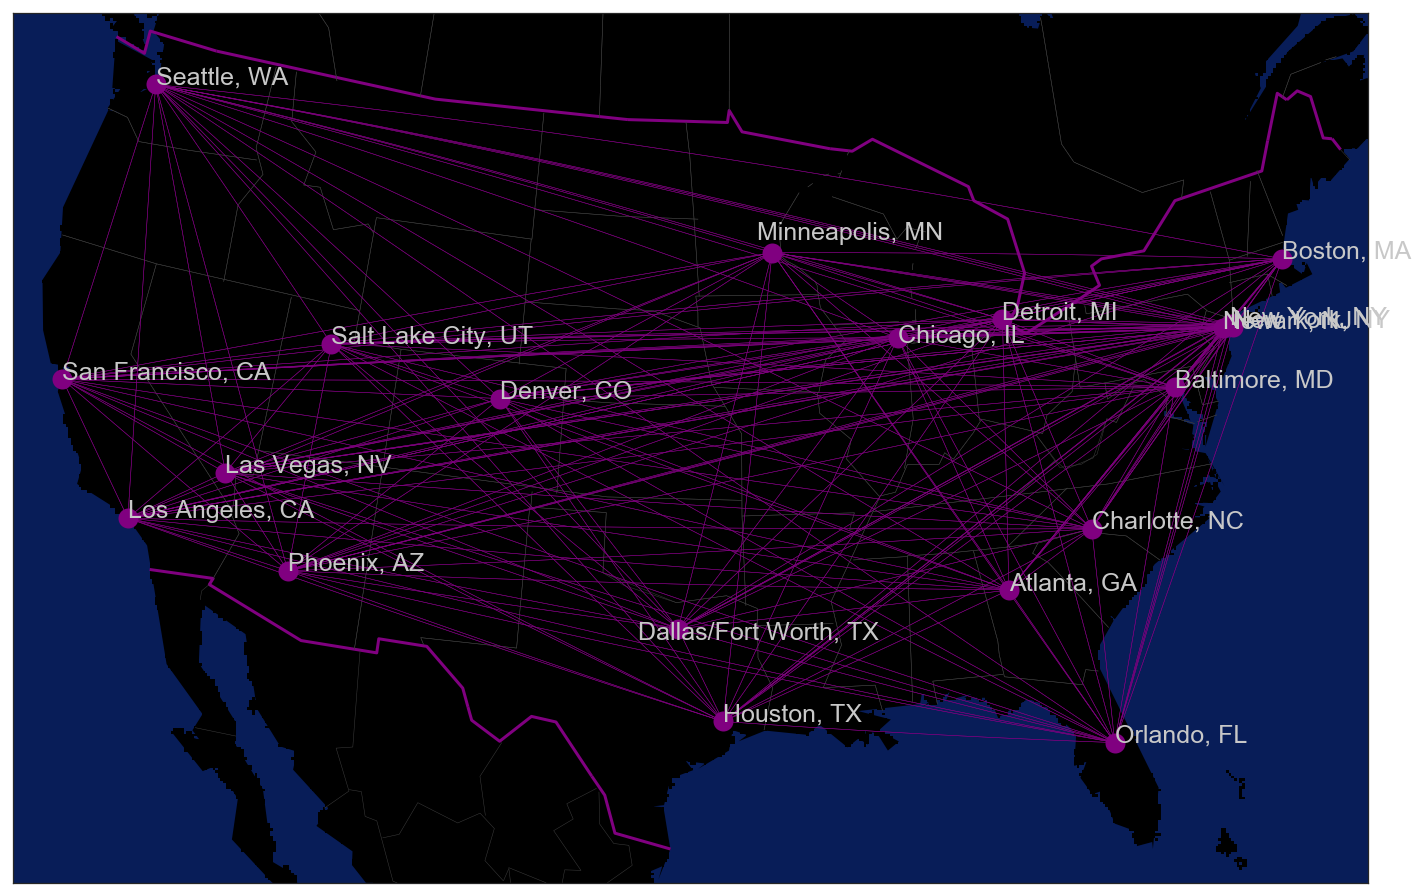

In [33]:
airports = list(set(df.Origin))
airports.sort()
cities = [df.OriginCityName[df.Origin == x].iloc[0] for x in airports]

scale = 1
#airports_map = cities.copy()
airports_map = airports.copy()
#Fixing some airport names for the map
airports_map[0] = "ATL GA"
airports_map[1] = "Boston airport"
airports_map[2] = "BWI MD"
airports_map[4] = "Denver airport"

m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49, projection='lcc',
            lat_1=33,lat_2=45,lon_0=-95)

plt.figure(figsize=(26,16))
m.bluemarble()
#m.shadedrelief()
m.drawcountries(linewidth=3, linestyle='solid', color="purple")
m.drawlsmask(land_color='black',ocean_color=(8/255.0, 29/255.0, 88/255.0), lakes=True)
m.fillcontinents(color="black", lake_color="black")
m.drawstates(color=(60/255.0, 60/255.0, 60/255.0))
# Get the location of each city and plot it
geolocator = Nominatim()
i = 0
latlist = []
lonlist = []
for airport in airports_map:
        loc = geolocator.geocode(airport)
        if not loc:
            print("Could not locate {}".format(airport))
            continue
        x, y = m(loc.longitude, loc.latitude)
        latlist.append(loc[1][0])
        lonlist.append(loc[1][1])
        m.plot(x,y,marker='o',color="purple",markersize=20)
        if (i==5):
            xy = (x-(0.06*x),y-(0.04*y))
        elif (i == 14):
            xy = (x-(0.02*x),y+(0.02*y))
        elif (i == 15):
            xy = (x,y-(0.01*y))
        else:
            xy = (x,y)
        plt.annotate(cities[i], xy = xy, size=25, color=(200/255.0, 200/255.0, 200/255.0))
        i = i + 1
for j in np.arange(len(latlist)):
    lat1 = latlist[j]
    lon1 = lonlist[j]
    for k in np.arange(len(latlist)):
        lat2 = latlist[k]
        lon2 = lonlist[k]
        m.drawgreatcircle(lon1, lat1, lon2, lat2, linewidth=0.5, color='purple')

#plt.title("Network of top 20 airports", size = 34
savefig("MilestoneReport/map.pdf")

These 20 airports network broadly covers the whole US. Note that due to close proximity, we are not able to distinguish LGA, JFK and EWR airports around New York City. The justification for selecting these 20 airports is discussed in detail in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/DataAcquisitionMerging/data_acquisition_merging.ipynb). In a nutshell, we could get the weather data for only few airports due to weather API limitations. So, we selected top 20 airports that observe highest landings and takeoffs in the US.

Discussing the data frame further, we have 90 columns. Though we have already taken care of all the missing values in the data cleaning step, let us calculate the fraction of nulls (or missing values), just to make sure that we do not have any missing values.

In [14]:
frac_nulls = {col: (sum(df[col].isnull())/len(df)) for col in df.columns}
frac_nulls = sorted(frac_nulls.items(), key = operator.itemgetter(1))
frac_nulls

[('Year', 0.0),
 ('Quarter', 0.0),
 ('Month', 0.0),
 ('DayofMonth', 0.0),
 ('DayOfWeek', 0.0),
 ('Carrier', 0.0),
 ('Origin', 0.0),
 ('OriginCityName', 0.0),
 ('OriginState', 0.0),
 ('OriginWac', 0.0),
 ('Dest', 0.0),
 ('DestCityName', 0.0),
 ('DestState', 0.0),
 ('DestWac', 0.0),
 ('CRSDepTime', 0.0),
 ('DepTimeBlk', 0.0),
 ('CRSArrTime', 0.0),
 ('ArrTimeBlk', 0.0),
 ('Cancelled', 0.0),
 ('Diverted', 0.0),
 ('Distance', 0.0),
 ('DistanceGroup', 0.0),
 ('DivAirportLandings', 0.0),
 ('Nflights_10', 0.0),
 ('DepDelayMedian_10', 0.0),
 ('DepDelayMax_10', 0.0),
 ('ArrDelayMedian_10', 0.0),
 ('ArrDelayMax_10', 0.0),
 ('TaxiOutMedian_10', 0.0),
 ('TaxiInMedian_10', 0.0),
 ('Ncan_10', 0.0),
 ('Ndiv_10', 0.0),
 ('Nflights_20', 0.0),
 ('DepDelayMedian_20', 0.0),
 ('DepDelayMax_20', 0.0),
 ('ArrDelayMedian_20', 0.0),
 ('ArrDelayMax_20', 0.0),
 ('TaxiOutMedian_20', 0.0),
 ('TaxiInMedian_20', 0.0),
 ('Ncan_20', 0.0),
 ('Ndiv_20', 0.0),
 ('Nflights_30', 0.0),
 ('DepDelayMedian_30', 0.0),
 ('DepDela

We do not have any column with any missing values, which is great. Details about each column can be found [here](https://www.transtats.bts.gov/Fields.asp?Table_ID=236) and [here](https://www.wunderground.com/weather/api/d/docs?d=resources/phrase-glossary) and some in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/DataAcquisitionMerging/history_calc.ipynb) and [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/DataCleaning/data_cleaning.ipynb). The "Cancelled" column has two values: 1 for canceled flights and 0 for not-canceled flights. What is the fraction of those 2.8+ million flights (at 20 airports) that got canceled in the years 2015 - 2016? 

In [15]:
print(100*sum(df.Cancelled == 1)/len(df), "% of the total flights were cancelled in years 2015-2016 at top 20 airports in the US.")

1.1486665507 % of the total flights were cancelled in years 2015-2016 at top 20 airports in the US.


This does not seem like a large number but such rare events cause a lot of troubles to passengers, and cost lot of money to airline industries. Therefore, it is important to understand where, when and how this small events occur. To start with, we plot the total number of flights on a daily basis and see how many flights got cancelled (on a daily basis).

In [16]:
# FlightDateTime is the scheduled date and time of the flight at the origin airport 
df["FlightDateTime"] = pd.to_datetime(df["FlightDateTime"])

In [17]:
def hide_topright(ax):
    """ This function removes the top and right border lines from a figure.
    
    Parameters
    ----------
    ax : An instance of Axes
    """
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

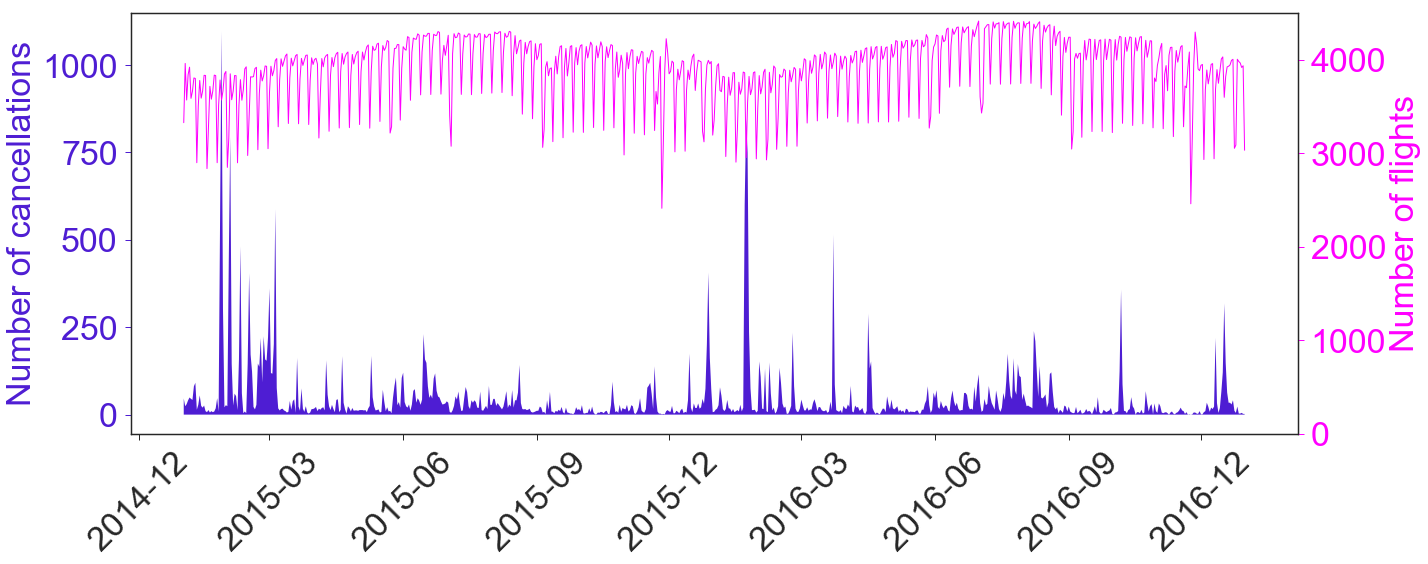

In [19]:
fig, ax1 = plt.subplots(figsize=(20,8))
d1 = df.groupby(df.set_index("FlightDateTime").index.date)["Cancelled"].sum()
ax1.fill_between(d1.index, d1.values, np.min(d1.values), 
                facecolor=(78/255.0, 29/255.0, 211/255.0), linewidth =0.1)
plt.xlim(('2015-01-01', '2016-12-31'))
ax1.set_ylabel("Number of cancellations", size=34, color=(78/255.0, 29/255.0, 211/255.0))
plt.xticks(fontsize=34)
plt.setp( ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.tick_params('y', colors=(78/255.0, 29/255.0, 211/255.0), labelsize=34)

ax2 = ax1.twinx()
d2 = df.groupby(df.set_index("FlightDateTime").index.date)["Cancelled"].count()
ax2.plot(d2.index, d2.values, color="magenta", linewidth = 1)
ax2.set_ylabel("Number of flights", size=34, color="magenta")
ax2.tick_params('y', colors="magenta", labelsize = 34)
ax2.set_ylim([0,4500])

fig.tight_layout()
savefig('MilestoneReport/daily_flights_cancellations.pdf')

The daily total number of flights remain almost steady with regular and periodic troughs. The number of cancelled flights has no steady trend but has some big spikes. Knowing the number of flights and number of cancellations, we can calculate the cancellation rate for a given day. We define the cancellation rate as, 

$$ \text{Flight cancellation rate} = \frac{\text{Number of flights cancelled for a given scenario}}{\text{Total number of flights for a given scenario}},$$

where a "scenario" can refer to a class of a field. In the plot above, a scenario would refer to a date, say June 24th 2015. Lets visualize the daily cancellation rates now.

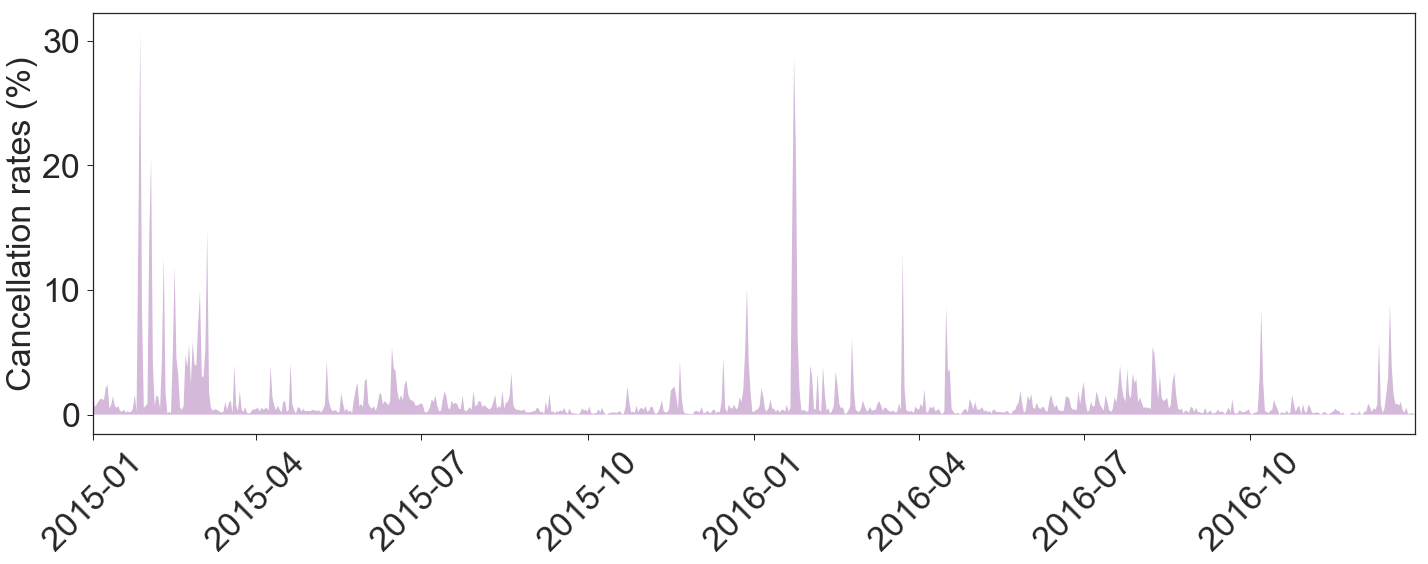

In [20]:
fig, ax1 = plt.subplots(figsize=(20,8))
d3 = 100*df.groupby(df.set_index("FlightDateTime").index.date)["Cancelled"].sum() / df.groupby(df.set_index("FlightDateTime").index.date)["Cancelled"].count()

ax1.fill_between(d3.index, d3.values, np.min(d3.values), 
                facecolor=(212/255.0, 185/255.0, 218/255.0), linewidth =0.1)
plt.xlim(('2015-01-01', '2016-12-31'))
ax1.set_ylabel("Cancellation rates (%)", size=34)
plt.xticks(fontsize=34)
plt.setp( ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.tick_params('y', labelsize=34)

fig.tight_layout()
savefig('MilestoneReport/daily_canrate.pdf')

Big spikes in the cancelation rates are mainly caused when the winter storms struck. There are some spikes in cancellation activities in some summer months too.


We can discuss some other examples for cancellation rates also. For instance, if the field is weather condition which has classes such as Heavy Snow, Rain, Clear Sky etc.., a scenario can be one of these weather conditions. We then count the number of flights operating under such a scenario (say Heavy Snow) and also count the number of flights that got cancelled under the same scenario. The cancellation rate equation can then be used to calculate the cancellation rate when the weather condition is Heavy Snow.

## Exploring all columns

Let us now explore the relationships between cancellation rate and all other variables that we have in the data frame. There are broadly three kinds of data in our data frame.

1. Flight data

2. Flight historical performance data

3. Weather data

Going forward from the plot above, let us first explore the temporal variability for cancellation rates. 


#### Year

Lets create a generic function to make plots for cancellation rates by given temporal categorical variable.

In [22]:
def plot_canrate_by_temp_cat(df, by, xlab, ylab, title, ylim, width, height, tbl):
    """ This function plots the bar chart for cancellation rates for all classes present in a 
    categorical variable
    
    Parameters
    ----------
    df (dtype: pd.DataFrame) : The data frame containing the categorical variable and the "Cancelled" column
    by (dtype: str): The name (in string format) of the categorical variable which is to be plotted
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title for the plot
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [2.5, 40]
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    tbl (dtype: int): An integer number from 0 to 19, to pick colors from tableau20
    """
    plt.subplots(1, 1, figsize=(width, height))

    ax = plt.subplot(1, 1, 1)
    (100*df.groupby(by)["Cancelled"].sum() / df.groupby(by)["Cancelled"].count()).plot(kind="bar", 
                                                                                         color=tableau20[tbl])    
    
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(ylim)
    plt.title(title, fontsize=20)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    hide_topright(ax)

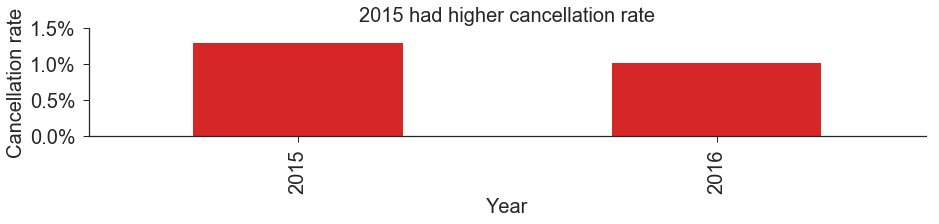

In [27]:
plot_canrate_by_temp_cat(df, "Year", "Year", "Cancellation rate", 
                         "2015 had higher cancellation rate", [0, 1.5], width=15, height=2, tbl=6) 

#### Quarter

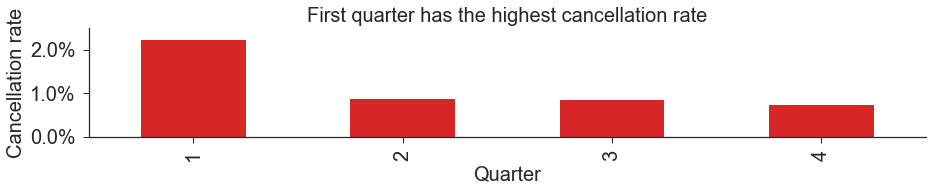

In [29]:
plot_canrate_by_temp_cat(df, "Quarter", "Quarter", "Cancellation rate", 
                         "First quarter has the highest cancellation rate", [0, 2.5], width=15, height=2, tbl=6) 

The highest rate of cancellation (about 2.2%) is seen in the first quarter. The other quarters have lower and quite similar cancellation rates, about 0.5-1%. The highest rate in the first quarter may be due to the bad weather/winter storms, as also observed in the previous plot. We can zoom-in into the first quarter or all of them by fine-graining this observation, let us see the monthly cancellation rates.

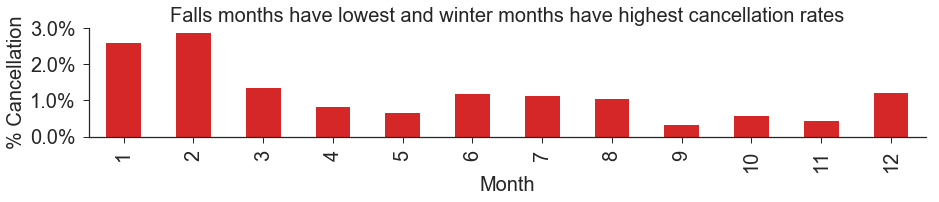

In [31]:
plot_canrate_by_temp_cat(df, "Month", "Month", "% Cancellation", 
                         "Falls months have lowest and winter months have highest cancellation rates", [0, 3],
                         width=15, height=2, tbl=6)

February was the worst in the first quarter followed by January and March. So far we have been thinking that bad weather plays a major role in flight cancellations. We should look at the effect of weather condition on cancellation rate for each quarter or month or even season. Before that lets just plot the cancellation rate by weather condition at the origin and deestination airports for the whole data.    

In [34]:
def plot_canrate_by_cat(df, by, xlab, ylab, title, sort, diffColor, top10, width, height, tbl, xlim, vertline):
    """ This function plots the bar chart in horizontal fashion for cancellation rates for all classes present in a 
    categorical variable. This function is very much similar to plot_canrate_by_temp_cat() with many added features.
    
    Parameters
    ----------
    df (dtype: pd.DataFrame) : The data frame containing the categorical variable and the "Cancelled" column
    by (dtype: str): The name (in string format) of the categorical variable which is to be plotted
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title for the plot
    sort: (dtype: boolean): True: if you want to sort the data and then plot, False: otherwise
    diffColor (dtype: boolean): True: if you want different colors for top 8 (this number can be changed), False: otherwise
    top10 (dtype: boolean): True: if you want to show only top 10 classes, False: otherwise
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    tbl (dtype: int): An integer number from 0 to 19, to pick colors from tableau20
    xlim (dtype: list): The list of numbers to limit x-axis. Example: [0, 12.5]
    vertline (dtype: boolean): True: if you want to draw a vertical line at value = 10 (this number can be changed)
    """
    fig, ax = plt.subplots(1, 1, figsize=(width, height))
    can_rate = (100*df.groupby(by)["Cancelled"].sum() / df.groupby(by)["Cancelled"].count())
    if top10:
        can_rate_sorted = can_rate.sort_values(ascending=True).tail(10)
    else:
        can_rate_sorted = can_rate.sort_values(ascending=True)
    
    total = len(list(can_rate_sorted.index))
    
    if diffColor:
        bottomn = 7
        topn = total - bottomn
        colors = [tableau20[tbl+1]]*topn
        colors = colors + [tableau20[tbl]]*bottomn
    else:
        colors = [tableau20[tbl]]*total
    
    if sort:
        ax = can_rate_sorted.plot(kind='barh',color=colors, zorder=0)
    else:
        ax = can_rate.plot(kind='barh',color=colors, zorder=0)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    plt.title(title, size=24)
    plt.xlim(xlim)
    hide_topright(ax)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=14)
    ax.grid(True, which='major', axis='x', color=(250/255.0, 250/255.0, 250/255.0), linewidth=3, zorder=1)
    if vertline:
        plt.axvline(x=10, color="blue", linestyle='--', linewidth=1)
    else:
        pass
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:3.0f}%'.format(x) for x in vals])
    #plt.setp( ax.xaxis.get_majorticklabels(), rotation=90)
    #ax.invert_yaxis()
    return(fig)

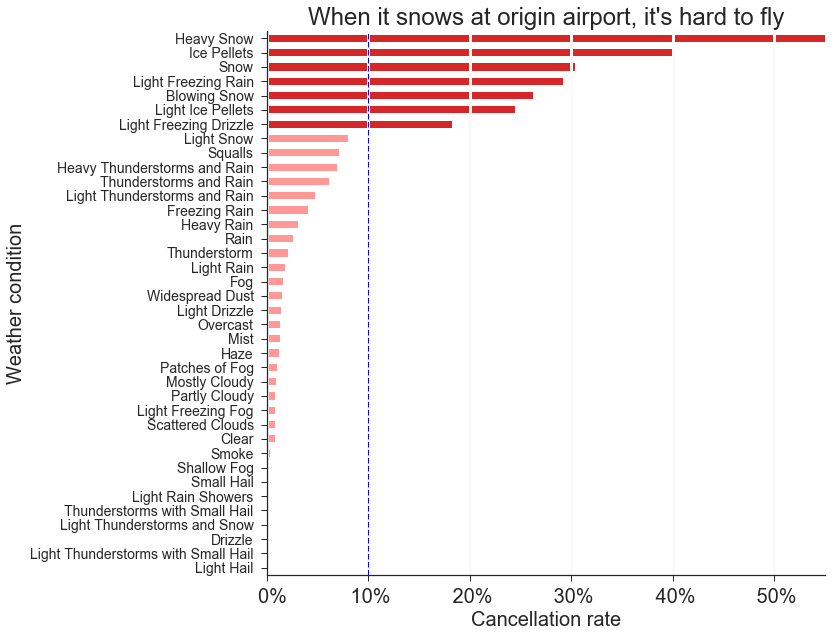

In [35]:
plot_canrate_by_cat(df, "Condition_Origin", "Cancellation rate", "Weather condition", 
                    "When it snows at origin airport, it's hard to fly", 
                    sort=True, diffColor=True, top10=False, width=10, height=10, tbl=6, xlim=[0, 55], vertline=True);

The cancellation rate here means the total cancellations for a chosen category devided by the total flights for thatsame category. For example, when there was heavy snow at origin airports, about 55% of the flights got cancelled. The dark red bars above indicate when the cancellation rate is more than 10%. We can see that the cancellation rates are pretty high when there is snow related activity. Rain with some thunderstorms also has high cancellation rates.  Interestingly, the cancellation rate is almost 0 when there is any kind of hail. We would expect that there would be disreuptions where are is hail. A possible reason could be that there are very few flights with hail condition at the origin airport.

In [36]:
sum(df.Condition_Origin.str.contains("Hail"))

69

Out of 2.8+ million flights, there are only 56 with some type of hail condition. So, we do not have much instances of hail to make any comment about it. Lets now  look at the destination airport weather conditions.

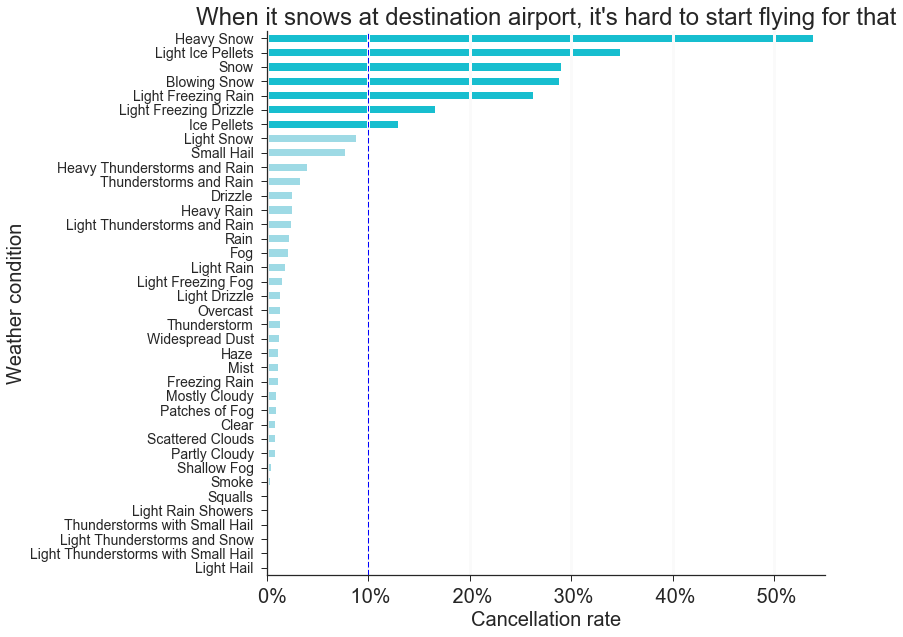

In [37]:
plot_canrate_by_cat(df, "Condition_Dest", "Cancellation rate", "Weather condition", 
                    "When it snows at destination airport, it's hard to start flying for that", 
                    sort=True, diffColor=True, top10=False, width=10, height=10, tbl=18, xlim=[0, 55], vertline=True);

We observe similar top weather factors where the cancellation rates are high. There is one weather condition called "Squalls" which has very low cancellation rate if that that condition is at destination airport. The same condition has high cancellation rate if it is at origin airport. Again, there could be very small number of instances of "Squalls" to make any comment.

In [38]:
sum(df.Condition_Origin.str.contains("Squalls"))

28

Overall, whenever there are snow or ice related weather events either at origin or destination airports, the cancellation rates are high. However, such conditions occur only in few winter months. We should look at similar plots but for non-winter months too. In order to be precise and save space , we can focus on top 10 weather conditions for which the cancellation rates are high. We can also look at four seasons: winter, spring, summer and falls. 

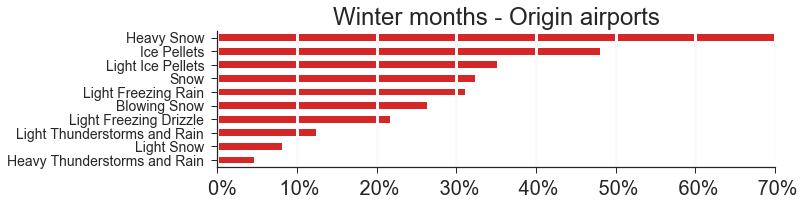

In [44]:
plot_canrate_by_cat(df[df.Month.isin([12,1,2])], "Condition_Origin", "", "", "Winter months - Origin airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=6, xlim=[0, 70], vertline=False);

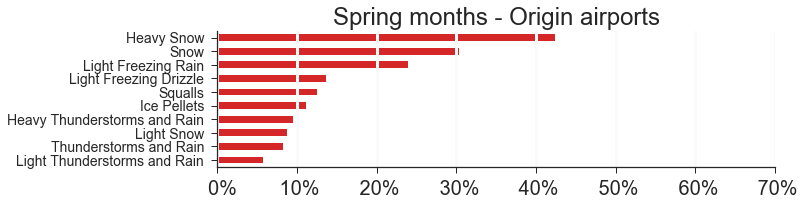

In [45]:
plot_canrate_by_cat(df[df.Month.isin([3,4,5])], "Condition_Origin", "", "", "Spring months - Origin airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=6, xlim=[0, 70], vertline=False);

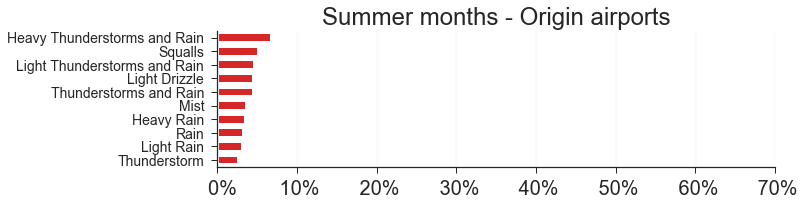

In [46]:
plot_canrate_by_cat(df[df.Month.isin([6,7,8])], "Condition_Origin", "", "", "Summer months - Origin airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=6, xlim=[0, 70], vertline=False);

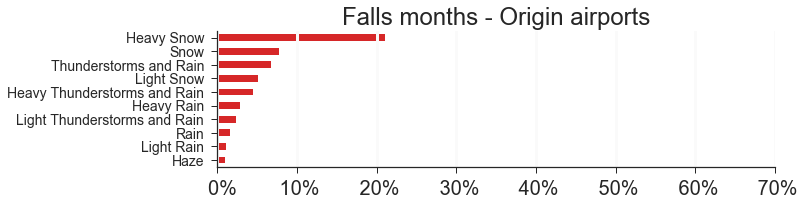

In [47]:
plot_canrate_by_cat(df[df.Month.isin([9,10,11])], "Condition_Origin", "", "", "Falls months - Origin airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=6, xlim=[0, 70], vertline=False);

In summer, thunderstorms and mist have the highest cancellation rates. In all other three seasons, the snow related factors dominate. This means that when there is snow related events in winter, spring or falls then there is high chance of flight cancellations. Also, when there is mist and thunderstorm related events in summer then there is high chance of cancellations. Does this hold true if we look at destination airports? 

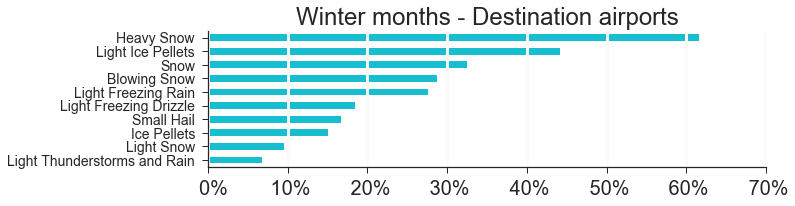

In [49]:
plot_canrate_by_cat(df[df.Month.isin([12,1,2])], "Condition_Dest", "", "", "Winter months - Destination airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=18, xlim=[0, 70], vertline=False);

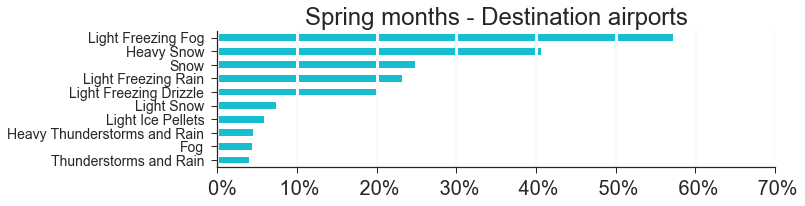

In [50]:
plot_canrate_by_cat(df[df.Month.isin([3,4,5])], "Condition_Dest", "", "", "Spring months - Destination airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=18, xlim=[0, 70], vertline=False);

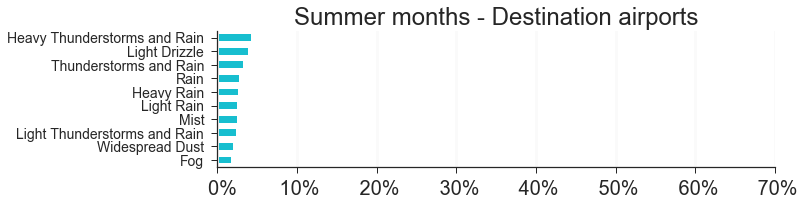

In [51]:
plot_canrate_by_cat(df[df.Month.isin([6,7,8])], "Condition_Dest", "", "", "Summer months - Destination airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=18, xlim=[0, 70], vertline=False);

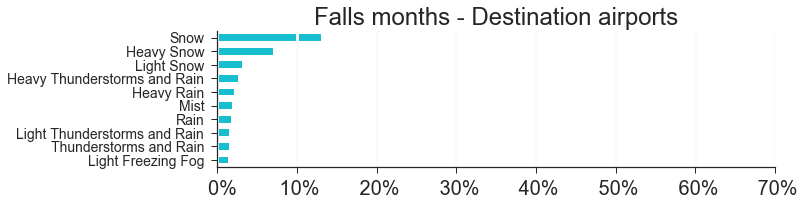

In [52]:
plot_canrate_by_cat(df[df.Month.isin([9,10,11])], "Condition_Dest", "", "", "Falls months - Destination airports", sort=True, diffColor=False, top10=True, width=10, height=2.5, tbl=18, xlim=[0, 70], vertline=False);

The story is almost same for destination too. Clearly, both weather factors and months affect the cancellation rates. There is some interaction between months and weather factors. All these high cancellation rates that we saw was for some weather factors which occur quite infrequently as comapred with "Overcast", "Clear" etc. These high frequent weather factors dominate the data and have very low flight cancellation rates. 

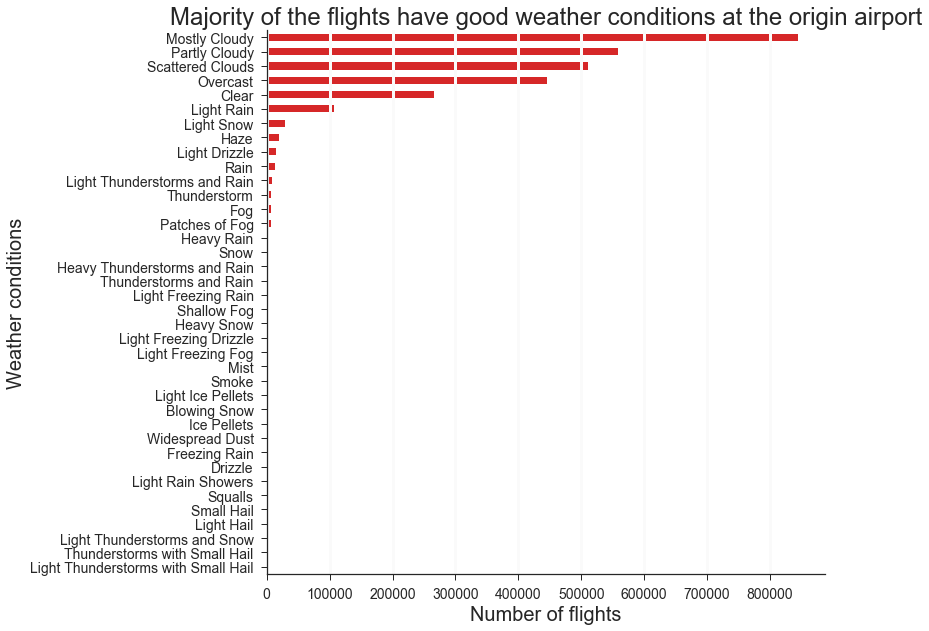

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df.groupby("Condition_Origin")["Condition_Origin"].count().sort_values(ascending=True).plot(kind="barh", 
                                                                                            zorder=0,
                                                                                           color=tableau20[6])
plt.xlabel("Number of flights", fontsize=20)
plt.ylabel("Weather conditions", fontsize=20)
plt.title("Majority of the flights have good weather conditions at the origin airport", size=24)
hide_topright(ax)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(fontsize=14)
ax.grid(True, which='major', axis='x', color=(250/255.0, 250/255.0, 250/255.0), linewidth=3, zorder=1)

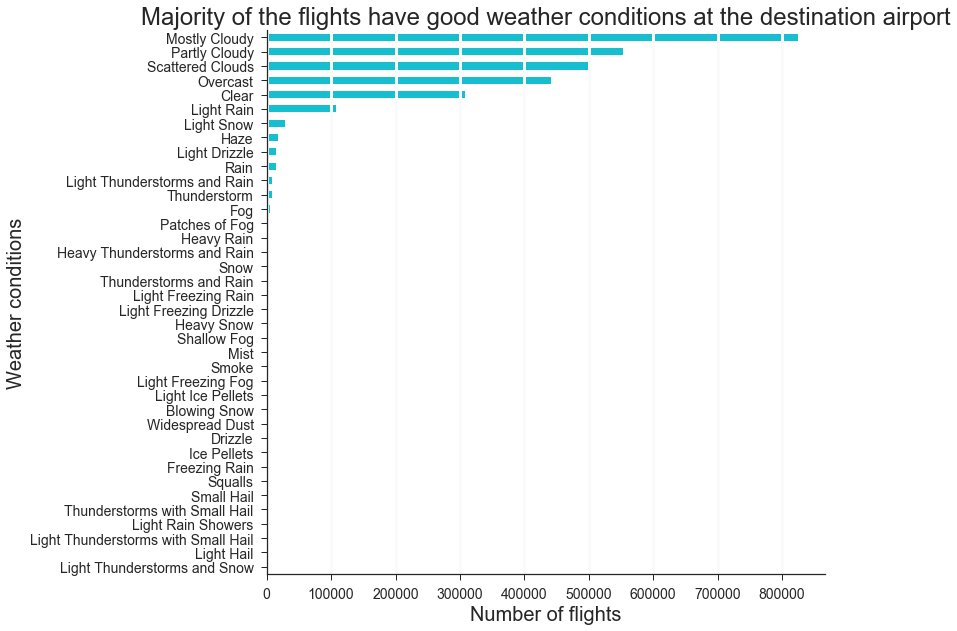

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df.groupby("Condition_Dest")["Condition_Dest"].count().sort_values(ascending=True).plot(kind="barh", 
                                                                                            zorder=0,
                                                                                           color=tableau20[18])
plt.xlabel("Number of flights", fontsize=20)
plt.ylabel("Weather conditions", fontsize=20)
plt.title("Majority of the flights have good weather conditions at the destination airport", size=24)
hide_topright(ax)
plt.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True, which='major', axis='x', color=(250/255.0, 250/255.0, 250/255.0), linewidth=3, zorder=1)

Majority of flights were operated at normal weather conditions such as "Mostly Cloudy", "Scattered Clouds", "Partly Cloudy", "Overcast" and "Clear". At these weather conditions, we found very low cancellations rates. On the other hand, the weather conditions, in which the cancellation rates were pretty high, we see a very small number of flights. 
There are three weather factors: Light Rain, Light Snow, Light Drizzle for which the number of flights are not that low but have considerable cancellation rates in either seasons.

Moving ahead, lets explore another temporal variable:

#### DayofMonth

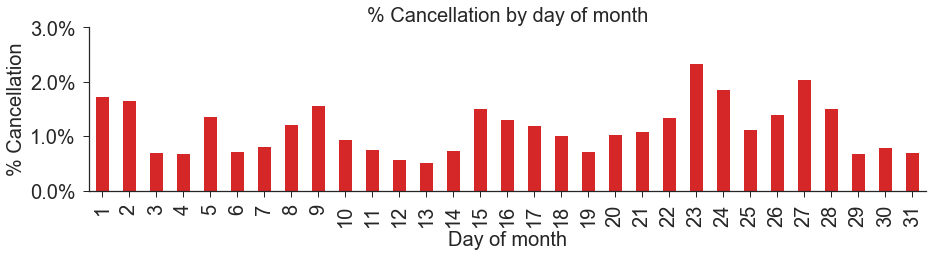

In [56]:
plot_canrate_by_temp_cat(df, "DayofMonth", "Day of month", "% Cancellation", "% Cancellation by day of month", [0, 3], 
                         width=15, height=3, tbl=6)

There seems to be more cancellation in the last week of the month, however the trend is not very clear. We may omit this factor in any further analysis.

#### DayOfWeek

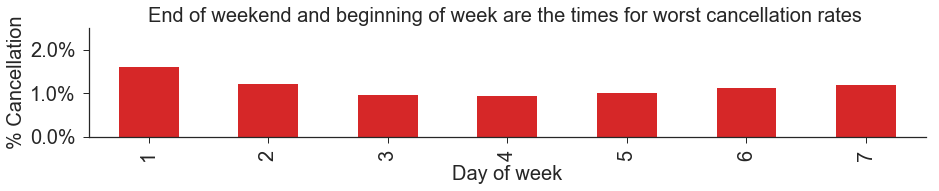

In [57]:
plot_canrate_by_temp_cat(df, "DayOfWeek", "Day of week", "% Cancellation", 
                         "End of weekend and beginning of week are the times for worst cancellation rates ", [0, 2.5], 
                         width=15, height=2, tbl=6)

Here, 1 is for Monday. The lowest cancellation rate (less than 1%) is seen beetween Wednesday to Saturday. From Sunday onwards the rate increases and peaks on Monday to about 1.8%, and then drops on coming days. We can definitely keep "DayOfWeek" for future analysis.

Do we see the same weekly trend in all seasons? The above chart is for the whole data, lets create a similar figure for winter months and see if the trend changes.

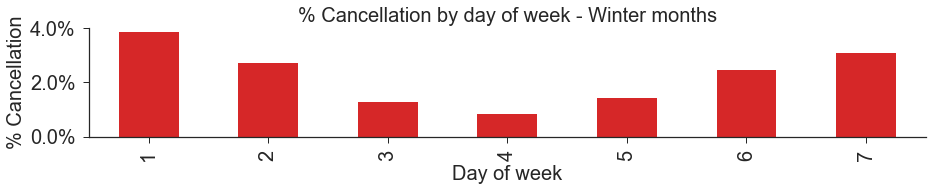

In [59]:
plot_canrate_by_temp_cat(df[df.Month.isin([12,1,2])], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - Winter months", [0,4], width=15, height=2, tbl=6)

The cancellation rates are much higher (due to bad weathers we discussed before) but the trend is quite similar to overall data. How about other seasons?

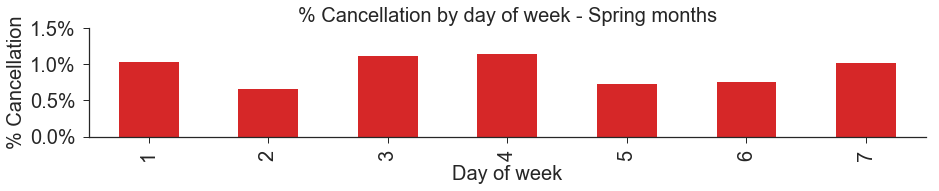

In [61]:
plot_canrate_by_temp_cat(df[df.Month.isin([3,4,5])], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - Spring months", [0, 1.5], width=15, height=2, tbl= 6)

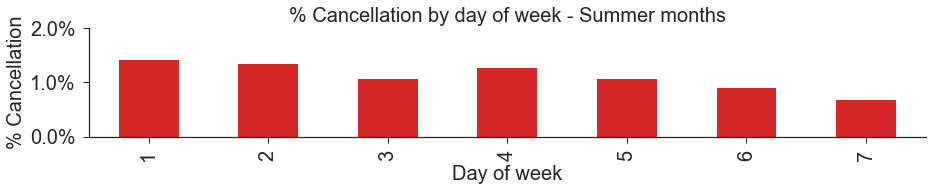

In [65]:
plot_canrate_by_temp_cat(df[df.Month.isin([6,7,8])], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - Summer months", [0, 2], width=15, height=2, tbl= 6)

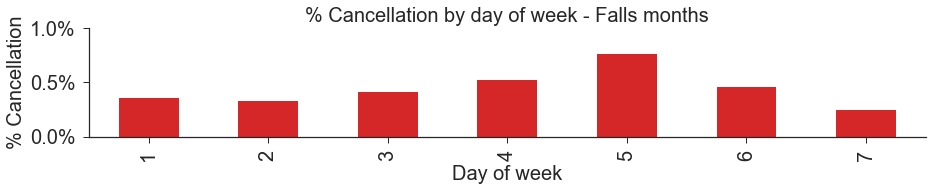

In [66]:
plot_canrate_by_temp_cat(df[df.Month.isin([9,10,11])], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - Falls months", [0,1],width=15, height=2, tbl= 6)

Actually, there are differences in trends from season to season. In spring months, highest cancellation rate is observed on Thursday. In summer months, there is almost a monotonic decay in cancellation rate from Monday to Sunday. The Falls months' cancellation rate distribution is pretty uniform, except a bit lower rate on Sunday.

Clearly, the day of week alone is not telling the whole story. This variable in cambination with "season" or more accurately with "Month" tells much more details. This shows an interesting interaction between two calander variables. The trend for the whole data is similar to that for the winter months because the cancellation rates are highest and much higher than the rates in other months. 


It is also possible that there are interactions between the day of week and weather condition. What happens to the weekly trend for cancellation rate when the weather condition is, say "Rain" at origin airport?

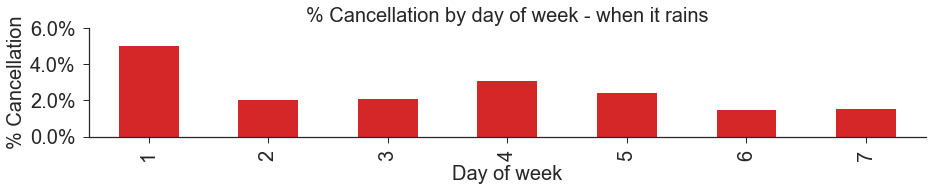

In [68]:
plot_canrate_by_temp_cat(df[df.Condition_Origin == "Rain"], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - when it rains", [0, 6], width=15, height=2, tbl= 6)

Monday is worst when it rains. How about when the sky is clear?

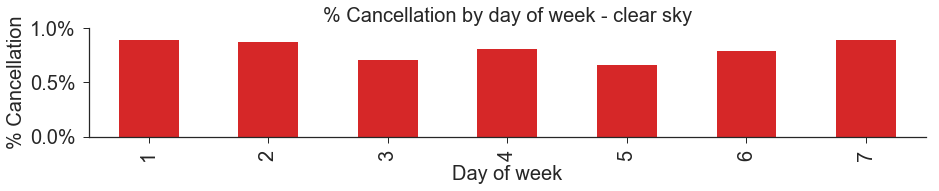

In [70]:
plot_canrate_by_temp_cat(df[df.Condition_Origin == "Clear"], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - clear sky", [0, 1], width=15, height=2, tbl= 6)

For clear sky, the rates are pretty small and the distribution is close to being uniform. How about "Heavy Snow"?

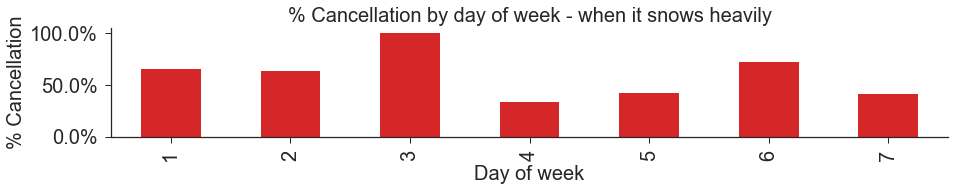

In [72]:
plot_canrate_by_temp_cat(df[df.Condition_Origin == "Heavy Snow"], "DayOfWeek", "Day of week", "% Cancellation", "% Cancellation by day of week - when it snows heavily", [0, 105], width=15, height=2, tbl= 6)

Wednesday is the worst when it snows heavily. Monday, Tuesday and Saturday see high cancellation rates too. This conclusion may not be very general because it may be due to coincidence that heavy snow happended only on Monday and Tuesday in 2015-2016 winter months.

We can similarly explore the day of week at destination airport too, since there are flights during which the date chamges.


#### DayOfWeek_Dest

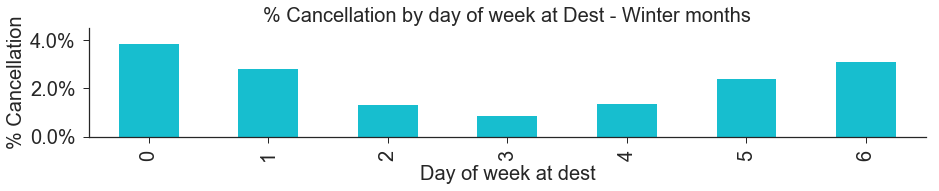

In [75]:
plot_canrate_by_temp_cat(df[df.Month_Dest.isin([12,1,2])], "DayOfWeek_Dest", "Day of week at dest", "% Cancellation", "% Cancellation by day of week at Dest - Winter months", [0, 4.5], width=15, height=2, tbl= 18)

There seems to be a problem with the values in DayOfWeek_Dest column. For "DayOfWeek", we had value 1 representing Monday and 7 representing Sunday. We can fix DayOfWeek_Dest by adding 1 to all its rows.

In [76]:
df.DayOfWeek_Dest = df.DayOfWeek_Dest + 1

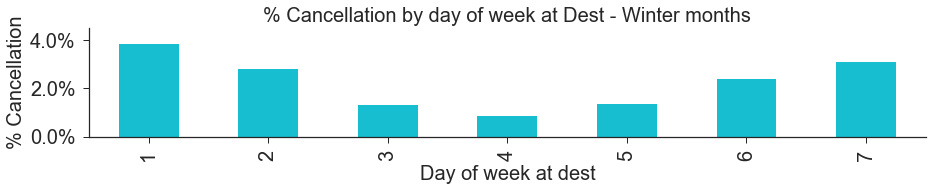

In [77]:
plot_canrate_by_temp_cat(df[df.Month_Dest.isin([12,1,2])], "DayOfWeek_Dest", "Day of week at dest", "% Cancellation", "% Cancellation by day of week at Dest - Winter months", [0, 4.5], width=15, height=2, tbl= 18)

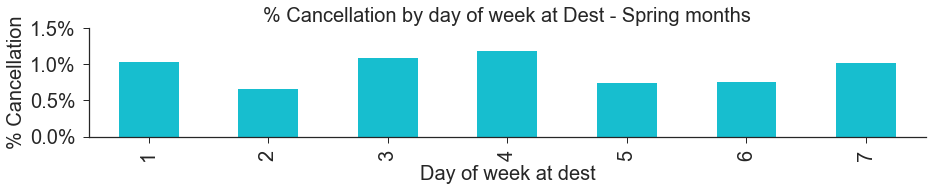

In [79]:
plot_canrate_by_temp_cat(df[df.Month_Dest.isin([3,4,5])], "DayOfWeek_Dest", "Day of week at dest", "% Cancellation", "% Cancellation by day of week at Dest - Spring months", [0, 1.5], width=15, height=2, tbl= 18)

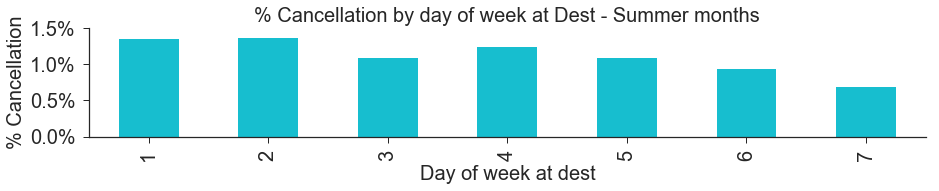

In [80]:
plot_canrate_by_temp_cat(df[df.Month_Dest.isin([6,7,8])], "DayOfWeek_Dest", "Day of week at dest", "% Cancellation", "% Cancellation by day of week at Dest - Summer months", [0, 1.5], width=15, height=2, tbl= 18)

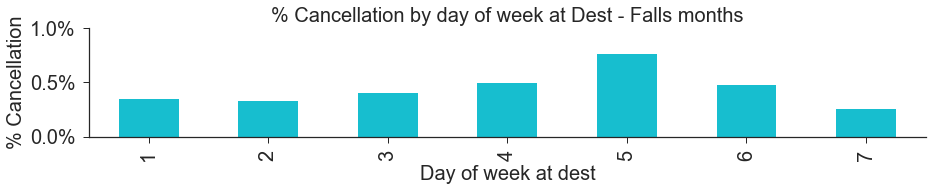

In [82]:
plot_canrate_by_temp_cat(df[df.Month_Dest.isin([9,10,11])], "DayOfWeek_Dest", "Day of week at dest", "% Cancellation", "% Cancellation by day of week at Dest - Falls months", [0, 1], width=15, height=2, tbl= 18)

Okay, so there is no difference in patters if we look at the origin airport or destination airport's day of week.

There is another temporal variable "CRSDepHr", which might be a good predictor for cancellation rates. This variable contains the scheduled departure hour of the day.

#### CRSDepHr

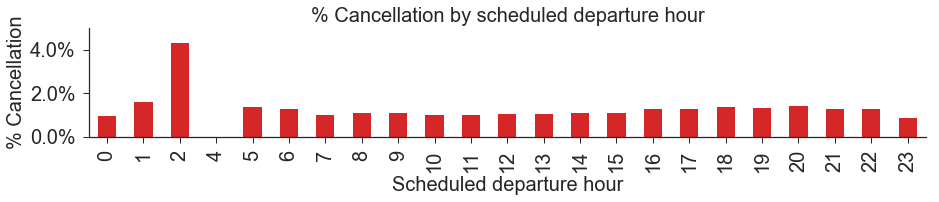

In [84]:
plot_canrate_by_temp_cat(df, "CRSDepHr", "Scheduled departure hour", "% Cancellation", "% Cancellation by scheduled departure hour", [0, 5], width=15, height=2, tbl= 6)

For all hours, the cancellation rates are below 2%. However, something heppens between 2 - 3 AM in the morning when the cancellation rate is more than 4%. Do we see this same trend for CRSArrHr (scheduled arrival hour)?

#### CRSArrHr

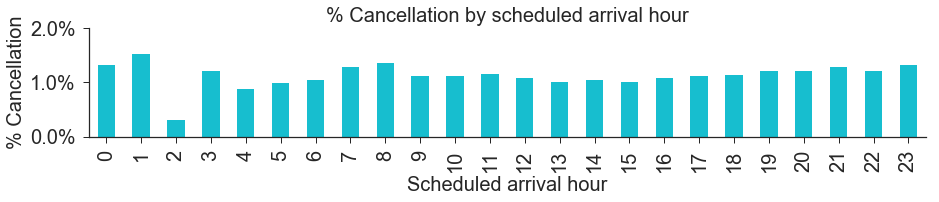

In [86]:
plot_canrate_by_temp_cat(df, "CRSArrHr", "Scheduled arrival hour", "% Cancellation", "% Cancellation by scheduled arrival hour", [0, 2], width=15, height=2, tbl= 18)

We do not see any big peak for cancellation rate in CRSArrHr. Let us try to understand why do we see a big spike in cancellation rate at 2 - 3 AM CRSDepHr? Since the cancellation rate is a ratio of the number of flights cancelled to total number of flights for a given scenario, it is highly likely that the number of flights is pretty small for 2 - 3 AM CRSDepHr flight scenario. Lets check the distribution of number of flghits at all CRSDepHr.

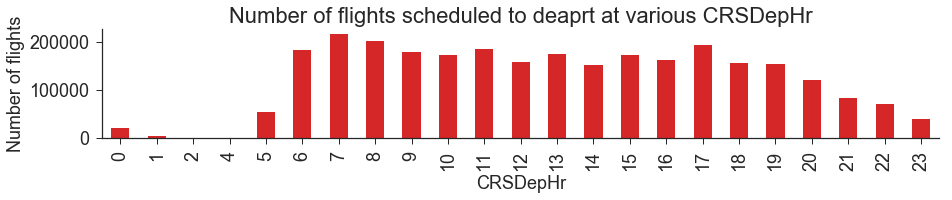

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2))
df.groupby("CRSDepHr")["CRSDepHr"].count().plot(kind="bar", zorder=0, color=tableau20[6])
plt.ylabel("Number of flights", fontsize=18)
plt.xlabel("CRSDepHr", fontsize=18)
plt.title("Number of flights scheduled to deaprt at various CRSDepHr", size=22)
hide_topright(ax)
plt.tick_params(axis='both', which='major', labelsize=18)

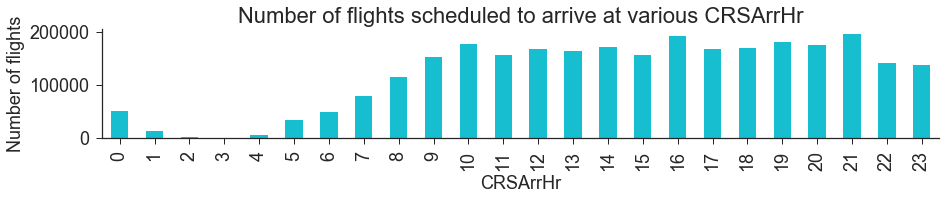

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2))
df.groupby("CRSArrHr")["CRSArrHr"].count().plot(kind="bar", zorder=0, color=tableau20[18])
plt.ylabel("Number of flights", fontsize=18)
plt.xlabel("CRSArrHr", fontsize=18)
plt.title("Number of flights scheduled to arrive at various CRSArrHr", size=22)
hide_topright(ax)
plt.tick_params(axis='both', which='major', labelsize=18)

It is indeed the truth. How many flights were scheduled to depart between 2 - 3 AM at top 20 airports?

In [89]:
print("Out of",sum(df.CRSDepHr == 2), "flights", sum((df.CRSDepHr == 2) & (df.Cancelled == 1)), "were canceled")

Out of 210 flights 9 were canceled


There are some other times (3 - 5 AM) when not even a single flight was scheduled to depart. 


Overall, we think both CRSDepHr and CRSArrHr could be good predictors for predictiong cancellation rates.

So far we have looked calander variables. Lets now explore some spatial variables like airport location, state, type etc.

#### Origin

In [90]:
def plot_canrate_by_cat1(df, by, xlab, ylab, title, sort, width, height, tbl, ylim):
    """ This function plots the bar chart for cancellation rates for all classes present in a 
    categorical variable. This function is very much similar to plot_canrate_by_cat() with some added features.
    
    Parameters
    ----------
    df (dtype: pd.DataFrame) : The data frame containing the categorical variable and the "Cancelled" column
    by (dtype: str): The name (in string format) of the categorical variable which is to be plotted
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title for the plot
    sort: (dtype: boolean): True: if you want to sort the data and then plot, False: otherwise
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    tbl (dtype: int): An integer number from 0 to 19, to pick colors from tableau20
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [2.5, 4]
    """
    fig, ax = plt.subplots(1, 1, figsize=(width, height))
    can_rate = (100*df.groupby(by)["Cancelled"].sum() / df.groupby(by)["Cancelled"].count())
    
    can_rate_sorted = can_rate.sort_values(ascending=False)
    
    colors = [tableau20[tbl]]
    
    if sort:
        ax = can_rate_sorted.plot(kind='bar',color=colors, zorder=0)
    else:
        ax = can_rate.plot(kind='bar',color=colors, zorder=0)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title, size=20)
    plt.ylim(ylim)
    hide_topright(ax)
    plt.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=60)
    #ax.invert_yaxis()
    return(fig)

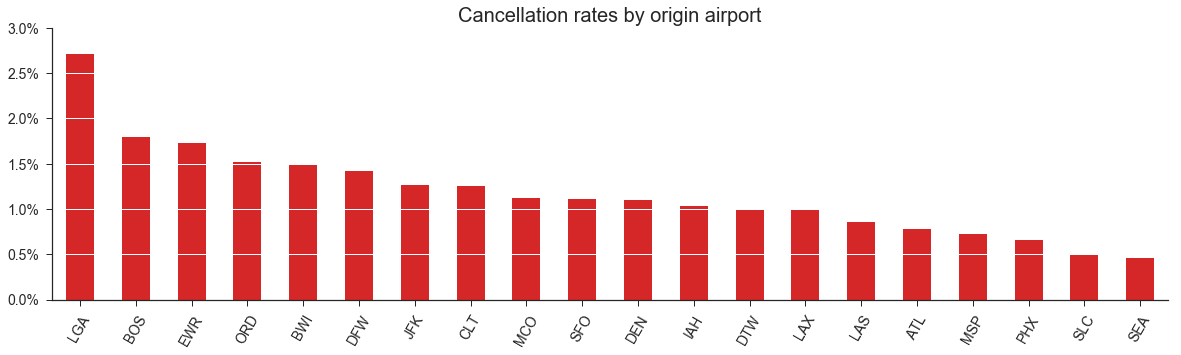

In [92]:
plot_canrate_by_cat1(df, "Origin", "", "", "Cancellation rates by origin airport", sort=True, width=20, 
                     height=5, tbl=6, ylim=[0, 3]);

In case the reader is not familiar with these airport codes, following is the mapping between codes and names:

ATL - Hartsfield Jackson Atlanta International

BOS - General Edward Lawrence Logan International	Boston

BWI - Baltimore/Washington International Thurgood Marshall	Baltimore

CLT - Charlotte Douglas International	Charlotte

DEN - Denver International	Denver

DFW - Dallas Fort Worth International	Dallas-Fort Worth

DTW - Detroit Metropolitan Wayne County	Detroit	

EWR - Newark Liberty International	Newark

IAH - George Bush Intercontinental Houston	Houston

JFK - John F Kennedy International	New York

LAS - McCarran International	Las Vegas

LAX - Los Angeles International	Los Angeles	

LGA - La Guardia	New York

MCO - Orlando International	Orlando	

MSP - Minneapolis-St Paul International/Wold-Chamberlain	Minneapolis	

ORD - Chicago O’Hare International	

PHX - Phoenix Sky Harbor International	Phoenix

SEA - Seattle Tacoma International	Seattle

SFO - San Francisco International	San Francisco	

SLC - Salt Lake City International	Salt Lake City	

The flights departing from LGA have the highest cancellation rate whereas the flights departing from SEA have lowest rate. Lets also have a look at the number of flights departed from top 20 airports for those same top 20 airports.

In [93]:
print(df.groupby("Origin")["Origin"].count().sort_values(ascending=False))

Origin
LAX    237866
ORD    215252
ATL    206524
SFO    190729
DEN    186129
DFW    162948
LAS    155990
PHX    150981
BOS    140143
SEA    133374
MCO    126128
CLT    118741
MSP    114063
IAH    111876
EWR    109259
DTW    107400
JFK    107288
LGA    103554
SLC    101636
BWI     77258
Name: Origin, dtype: int64


It is possible that the above trend will be different at different time of the year. Lets check out the pattern for all four major seasons.

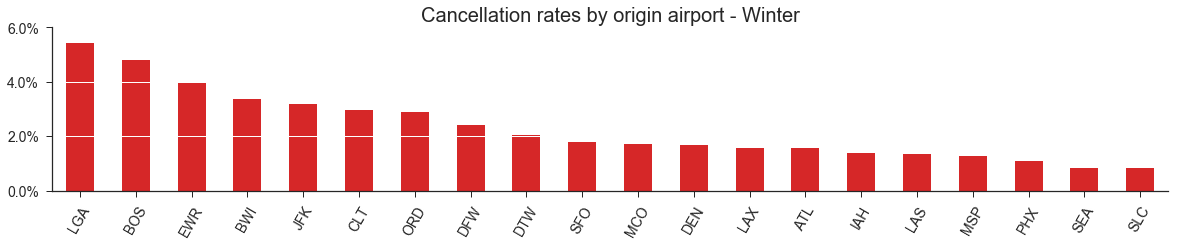

In [95]:
plot_canrate_by_cat1(df[df.Month.isin([12,1,2])], "Origin", "", "", "Cancellation rates by origin airport - Winter", sort=True, width=20, height=3, tbl=6, ylim=[0, 6]);

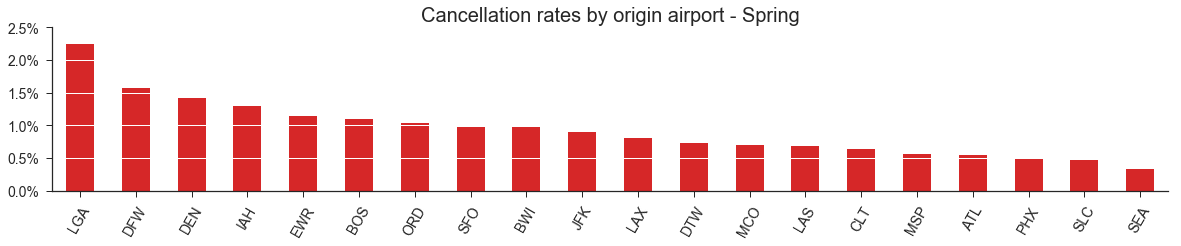

In [97]:
plot_canrate_by_cat1(df[df.Month.isin([3,4,5])], "Origin", "", "", "Cancellation rates by origin airport - Spring", sort=True, width=20, height=3, tbl=6, ylim=[0, 2.5]);

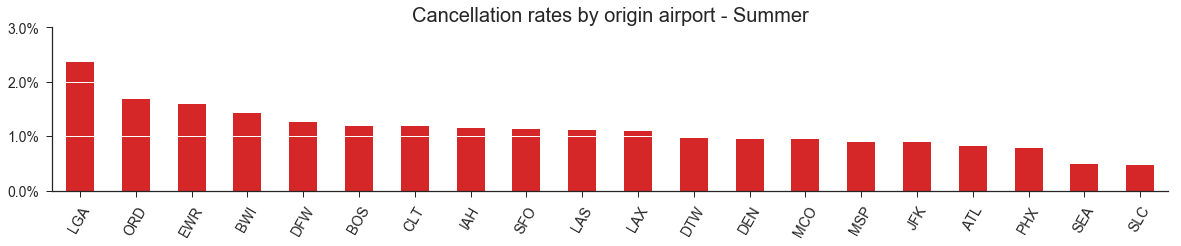

In [98]:
plot_canrate_by_cat1(df[df.Month.isin([6,7,8])], "Origin", "", "", "Cancellation rates by origin airport - Summer", sort=True, width=20, height=3, tbl=6, ylim=[0, 3]);

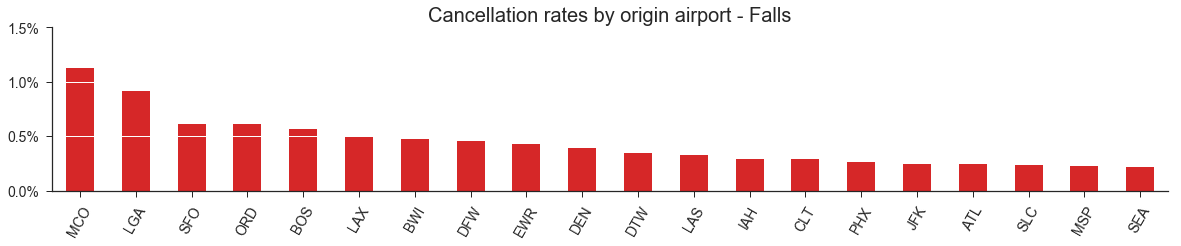

In [100]:
plot_canrate_by_cat1(df[df.Month.isin([9,10,11])], "Origin", "", "", "Cancellation rates by origin airport - Falls", sort=True, width=20, height=3, tbl=6, ylim=[0, 1.5]);

Usually, LaGuardia is the worst thoroughout the year, and Seattle and Salt Lake City are the best ones. Clearly, there is interaction between the season (or months) and the origin airport. 

How about the destination location?

#### Dest

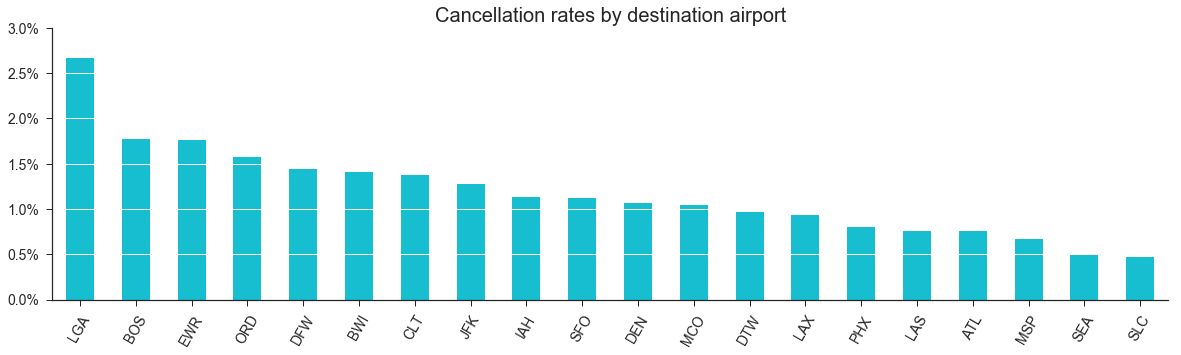

In [102]:
plot_canrate_by_cat1(df, "Dest", "", "", "Cancellation rates by destination airport", sort=True, width=20, 
                     height=5, tbl=18, ylim=[0, 3]);

The top 2 and the botton 2 remains the same whether we are looking at origin or destination airport. We can also look at origin and destination states too. We have considered 1 airport from each state, except for NY, CA and TX where we considered 2 airports. So, the bar chart by state will look very similar to above plots. Lets visualize them.

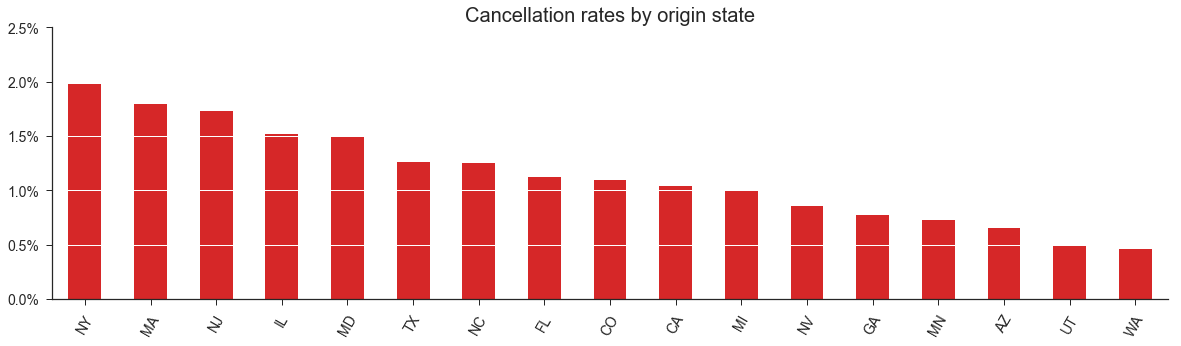

In [103]:
plot_canrate_by_cat1(df, "OriginState", "", "", "Cancellation rates by origin state", sort=True, width=20, 
                     height=5, tbl=6, ylim=[0, 2.5]);

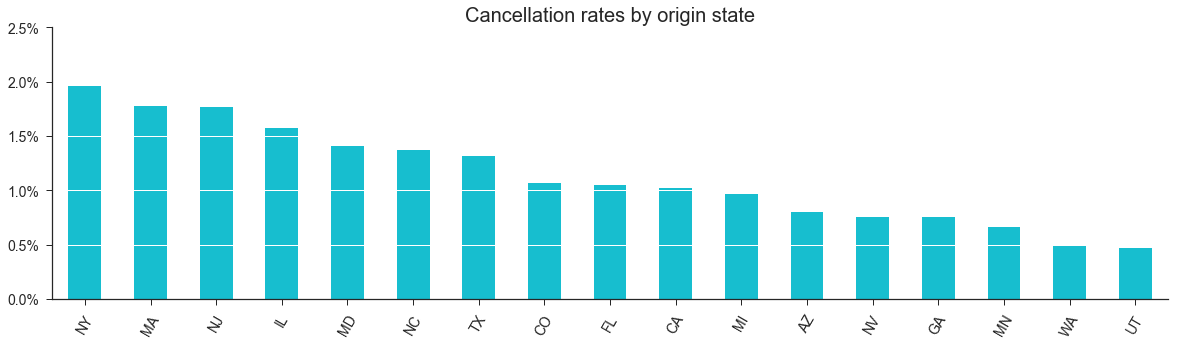

In [104]:
plot_canrate_by_cat1(df, "DestState", "", "", "Cancellation rates by origin state", sort=True, width=20, 
                     height=5, tbl=18, ylim=[0, 2.5]);

We observe pretty much the same pattern. Therefore, rather than state, we should keep Origin and Dest in the model. 

Lets us now look at how different airlines hae different cancellation rates.


#### Carrier

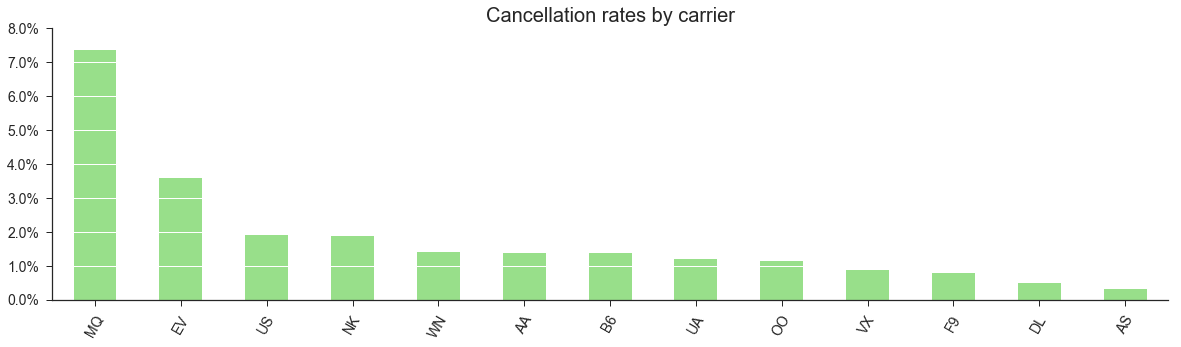

In [105]:
plot_canrate_by_cat1(df, "Carrier", "", "", "Cancellation rates by carrier", sort=True, width=20, 
                     height=5, tbl=5, ylim=[0, 8]);

Lets first get the name of airlines:

MQ - Envoy Air

EV - ExpressJet Airlines

US - US Airways

NK - Spirit Airlines

AA - American Airlines

B6 - Jetblue Airways 

UA - United Airlines

OO - SkyWest Airlines

WN - Southwest Airlines

VX - Virgin America

DL - Delta Air Lines

F9 - Frontier Airlines

AS - Alaska Airlines

The highest cancellation rate is seen for the Envoy Air, and lowest is seen for the Alaska Airlines. Again, these numbers are the ratios. We should also look at the actual number of flights by each airlines. 

In [106]:
print(df.groupby("Carrier")["Carrier"].count().sort_values(ascending=False))

Carrier
DL    659150
AA    617528
UA    536030
WN    308144
B6    139793
OO    124421
NK    112778
AS     94056
VX     79338
US     74160
F9     72010
EV     27927
MQ     11804
Name: Carrier, dtype: int64


Cancellation rates are high for both Envoy Air and ExpressJet Airlines but the actual number of flights are lowest for these two carriers. If we look at Delta Air Lines, it has low cancellation rate with highest number of flights. So, DL performs the best amongst its competetors, in terms of cncellation rates. 


Also, DL's network is distributed nationwide. Lets see how many airports does the DL flight depart from? 

In [107]:
len(df.Origin[df.Carrier == "DL"].unique())

20

From all airports in the dataset! How about MQ?

In [108]:
len(df.Origin[df.Carrier == "MQ"].unique())

11

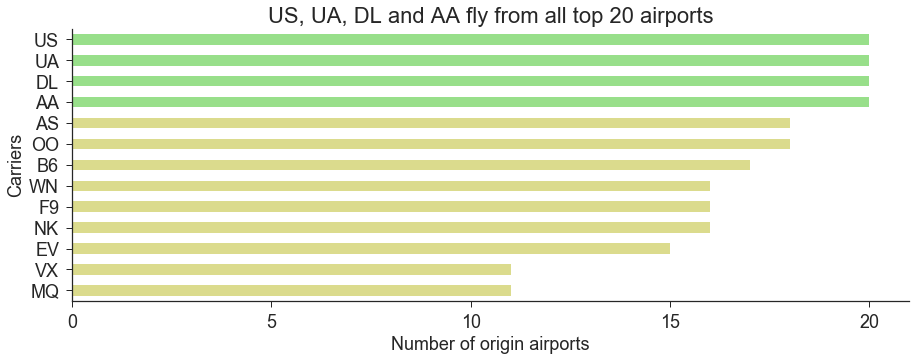

In [109]:
#fig = plt.subplots(1, 1, figsize=(15, 5))
total = len(df.Carrier.unique())
bottomn = 4
topn = total - bottomn
colors = [tableau20[17]]*topn
colors = colors + [tableau20[5]]*bottomn
ax = pd.DataFrame([{"Carrier": cr, "Origin airports": len(df.Origin[df.Carrier == cr].unique())} 
              for cr in list(df.Carrier.unique())]).sort_values("Origin airports").plot("Carrier", 
                                                                                        "Origin airports",
                                                                                       kind="barh", zorder=0,
                                                                                       color=colors, legend=None)
plt.xlabel("Number of origin airports", fontsize=18)
plt.ylabel("Carriers", fontsize=18)
plt.title("US, UA, DL and AA fly from all top 20 airports", size=22)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xticks([0, 5, 10, 15, 20])
hide_topright(ax)

So, airlines with the highest cancellation rates are the ones that do not cover the whole US, they are type of regional airlines. Lets create a dictionary for the airlines and their types. We would then be able to see if the cancellation rates really depend onthe type of the airlines. We can get the types from [this link](https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States).

MQ - Regional

EV - Regional

US - Mainline (note that US airways was ceased to operate in October 2015)

NK - Mainline

AA - Mainline

B6 - Mainline 

UA - Mainline

OO - Regional

WN - Mainline

VX - Mainline

DL - Mainline

F9 - Mainline

AS - Mainline

In [110]:
airline_type = {"MQ": "Regional", "EV": "Regional", "US": "Mainline", "NK": "Mainline", "AA": "Mainline",
               "B6": "Mainline", "UA": "Mainline", "OO": "Regional", "WN": "Mainline", "VX": "Mainline",
               "DL": "Mainline", "F9": "Mainline", "AS": "Mainline"}

In [111]:
df["AirlineType"] = df.Carrier.map(airline_type)

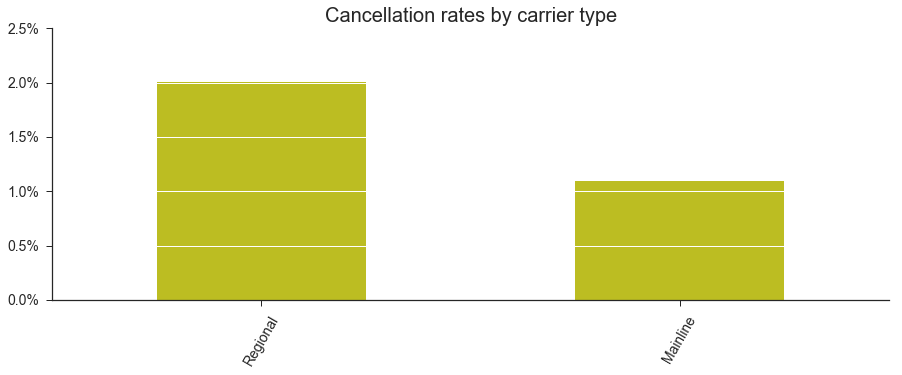

In [113]:
plot_canrate_by_cat1(df, "AirlineType", "", "", "Cancellation rates by carrier type", sort=True, width=15, 
                     height=5, tbl=16, ylim=[0, 2.5]);

Cancellation rate for regional carriers is almost twice compared with mainline carriers.

Type and name of airlines, and name of airport definitely affects the cancellation rate. Lets now see if the "Distance" of the flight has any influence on cancellation rates.

#### Distance

How does the distribution of Distance look like?

(0, 3000)

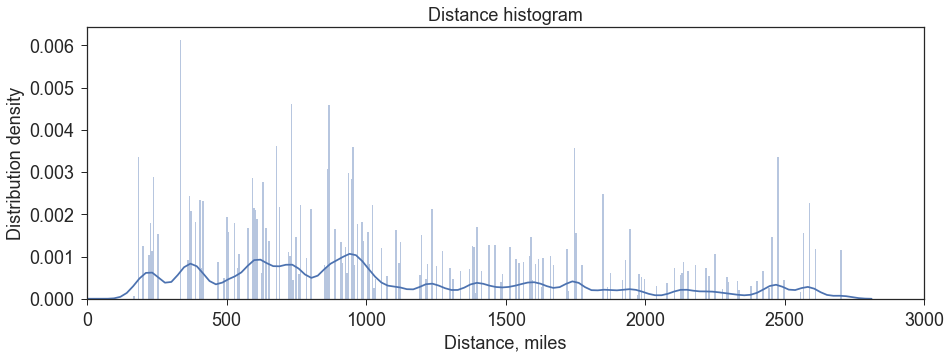

In [114]:
sns.distplot(df.Distance, norm_hist=False, kde = True, bins=500)
plt.xlabel("Distance, miles", fontsize=18)
plt.ylabel("Distribution density", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Distance histogram", fontsize=18)
plt.xlim([0, 3000])

In [115]:
df.Distance.describe()

count    2.857139e+06
mean     1.090059e+03
std      6.603561e+02
min      2.100000e+01
25%      5.990000e+02
50%      9.360000e+02
75%      1.546000e+03
max      2.704000e+03
Name: Distance, dtype: float64

The distribution is not normal and is highly skewed on the right side. There are flights with distance of as short as 21 miles and also as long as 2700 miles!

Lets now plot the cancellation rate as a function of the distance.

In [116]:
def create_canrate_by_contvar_df(contvar, df):
    """ This function is used to create a data frame containing two columns:
    
    1. Given continuous variable
    
    2. Cancellation rate (in %)
    
    Parameters
    ----------
    contvar (dtype: str): Continuous variable
    df (dtype: pd.DataFrame): original data frame from which to extract the small resultant data frame
    
    Return
    ----------    
    return (dtype: pd.DataFrame): small resultant data frame containing two columns
    """
    dfd = pd.DataFrame({contvar: 
                        df.groupby(contvar)[contvar].head(1).reset_index().drop(["index"], axis=1),
                        "CanRate": 
                        100*df.groupby(contvar)["Cancelled"].sum() / df.groupby(contvar)["Cancelled"].count().get_values()})
    return(dfd.drop(contvar, axis=1).reset_index())

In [117]:
dfd = create_canrate_by_contvar_df("Distance", df)

In [118]:
def plot_canrate_by_contvar(contvar, dft, xlab, ylab, title, xlim, ylim, xlog, tbl, width, height):
    """ This function plots the scatter plot for cancellation rates as a function of a given continuous vaiable. This function 
    not only requires the name of the continuous variable but also a small data frame containing the continuous
    variable and cancellation rate. This small data frame is obtained using the function create_canrate_by_contvar_df().
    
    Parameters
    ----------
    contvar (dtype: str): Continuous variable
    dft (dtype: pd.DataFrame): a small data frame obtained by running create_canrate_by_contvar_df()
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title of the plot
    xlim (dtype: list): The list of numbers to limit x-axis. Example: [2.5, 4]
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [0, 12.5]
    xlog (dtype: boolean): True: if you want log scale on x-axis, False: linear scale
    tbl (dtype: int): An integer number from 0 to 19, to pick colors from tableau20
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    
    Return
    ----------
    return: figure
    """
    fig, ax = plt.subplots(figsize=(width,height))
    #ax.scatter(dft[[0]], dft[[1]], color=tableau20[tbl], s=80, alpha=0.8)
    ax.scatter(dft.iloc[:,0], dft.iloc[:,1], color=tableau20[tbl], s=80, alpha=0.8)
    ax.set_xlabel(xlab, size=20)
    ax.set_ylabel(ylab, size=20)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.tick_params(direction='out', length=6, width=2, colors='k')
    plt.xticks(size=20)
    plt.yticks(size=20)
    if xlog:
        ax.set_xscale('log')
    else:
        pass
    hide_topright(ax)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    return(fig)

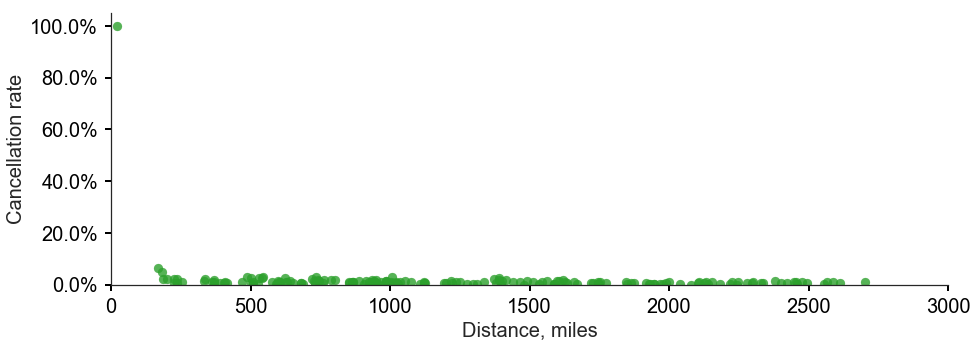

In [119]:
plot_canrate_by_contvar(contvar="Distance", dft=dfd, xlab="Distance, miles", ylab="Cancellation rate",
                        title = "", xlim=[0, 3000], ylim=[0, 105], xlog=False, tbl=4, width=15, height=5);

Note that there is a data point for Distance = 21 miles for which the cancellation rate was 100%. In order to see the clear trend for all other data points, we will not plot the point for 21 miles. 

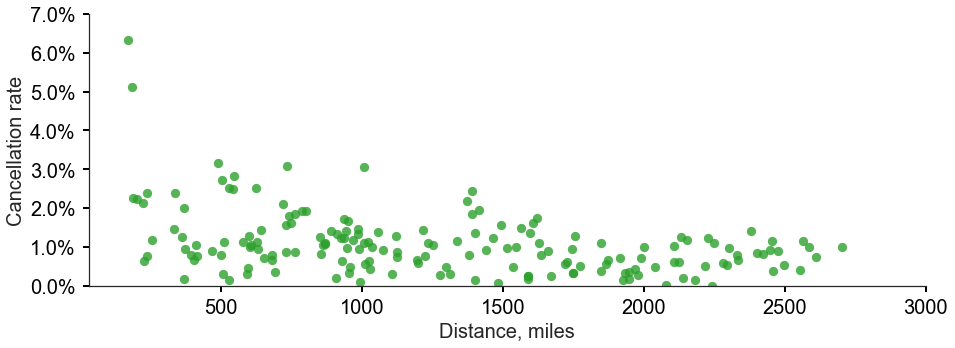

In [120]:
plot_canrate_by_contvar(contvar="Distance", dft=dfd, xlab="Distance, miles", ylab="Cancellation rate",
                        title = "", xlim=[30, 3000], ylim=[0, 7], xlog=False, tbl=4, width=15, height=5);

We can see that the cancellation rates are higher for short distance flgihts and low for long distance flights. We should keep in mind that the number of flights having very short and very long distances are much lower compared with the number of flights with around 1000 miles (refer to the density plot above). 

Lets now perform a quick hypothesis test to confirm a relationship between cancellation rate and distance. We can use Pearson's r to test the relationship but before that we need to make sure that both variables are normally distributed.

In [121]:
stats.normaltest(dfd.Distance)

NormaltestResult(statistic=33.248222298657822, pvalue=6.0289302757186669e-08)

In [122]:
stats.normaltest(dfd.CanRate)

NormaltestResult(statistic=381.22817706743422, pvalue=1.6495032546352589e-83)

Both variables are not normally distributed, so we cannot use Pearson's R. Lets rather use a non-parameteric test. We can calculate Spearman's $\rho$ and associated p-value to confirm the strength of a monotonic behaviour.

In [123]:
stats.spearmanr(dfd.Distance, dfd.CanRate)

SpearmanrResult(correlation=-0.38591580832960148, pvalue=1.3321765899406773e-07)

This test shows that there is a weak negative correlation with correlation coefficient of -0.386, and this number is statistically significant. We can also try with setting the x axis a logscale and plot the scatter plot, and then calculate Spearman's $\rho$.

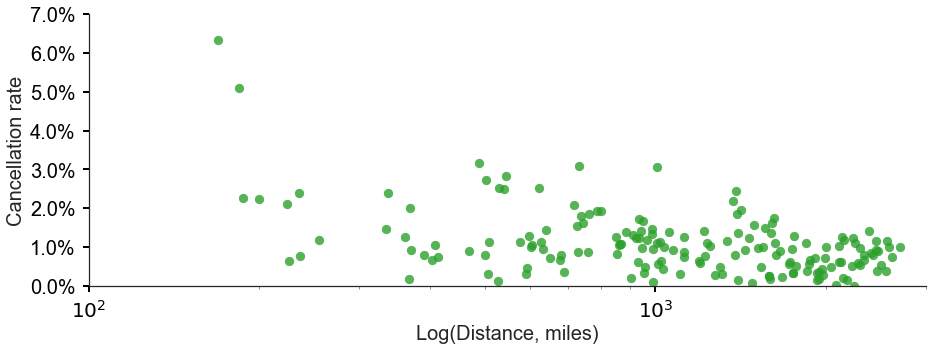

In [124]:
plot_canrate_by_contvar(contvar="Distance", dft=dfd, xlab="Log(Distance, miles)", ylab="Cancellation rate",
                        title = "", xlim=[100, 3000], ylim=[0, 7], xlog=True, tbl=4, width=15, height=5);

In [125]:
stats.spearmanr(np.log(dfd.Distance), dfd.CanRate)

SpearmanrResult(correlation=-0.38591580832960148, pvalue=1.3321765899406773e-07)

The plot with log scale looks better (closer to linear), however, the correlation coefficients are exactly the same.

So, we can confirm a weak relationship between the two variables. In other words, the likelihhod of cancellation is higher for short distance flights, and vice versa.

We have many more columns to explore. The remaining columns are either weather related fields or flight history related fields. Lets first understand the influence of historical performance on cancellation rates.

### Historical Performances

We have calculated the historical performances for 3 periods: (i) 10 days, (ii) 20 days, and (iii) 30 days. For example, for 10 days, we look at the flight delay summary, flight cancellations, number of flights etc., for last 10 days of the flight in question. There are 9 columns for each period.

#### Nflight_10

This is the number of flights in last 10 days for a given unique flight. Note that the unique flight is defined based on a unique carrier, unique origin-destination pair, and a unique scheduled departure time window. The minimum value of Nflights_10 can be 0. If the value of Nflights_10 is 0, then it means that there was no such similar flight in last 10 days. We will call such flights as "temporary" flight later. But for the time being, lets just start exploring Nflights_10. 

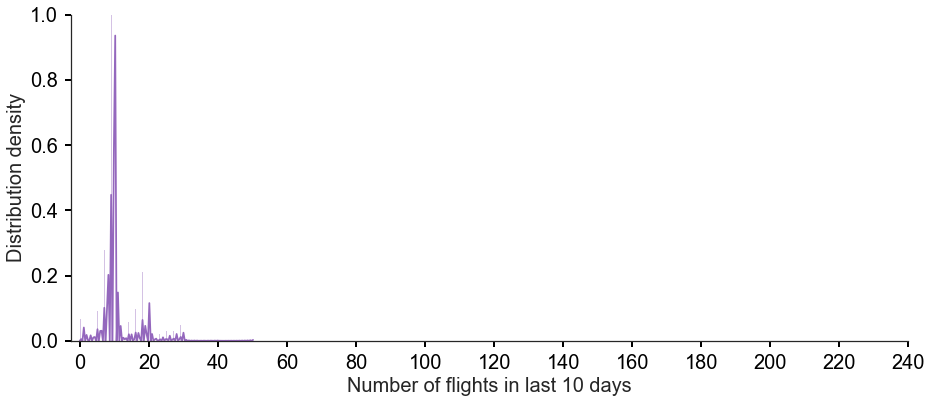

In [128]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.Nflights_10, norm_hist=False, kde = True, bins=500, color=tableau20[8])
plt.xlabel("Number of flights in last 10 days", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
plt.xticks([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,1])
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

In [129]:
df.Nflights_10.describe()

count    2.857139e+06
mean     1.084372e+01
std      4.832314e+00
min      0.000000e+00
25%      9.000000e+00
50%      1.000000e+01
75%      1.000000e+01
max      5.000000e+01
Name: Nflights_10, dtype: float64

We can see a trimodal distribution for Nflights_10. Since we define a time window of 60 minutes (both before and after, so actual window is 120 mins) in feature engineering stage, we can have multiple unique flights in a single day. This is why we have the value of Nflighs_10 to be as large as 50. The peaks in the distribution are at about 10, 20 and 30. This might mean that we have 1, 2, and 3 flights (of the same type) in a 60 mins window in last 10 days.


Lets now consider the Nflights_10 as a continuous variable, and plot cancellation rate against it.

First we create a data frame containing two columns: Nflights_10 and cancellation rate (in %). Basically, we want pick all the flights for which Nflights_10 is, say, 5. And then we count the number of such flights, and also the number of cancelled flights. The ratio will then give us the cancellation rate for Nflights_10 = 5.

In [130]:
dfd10 = create_canrate_by_contvar_df("Nflights_10", df)

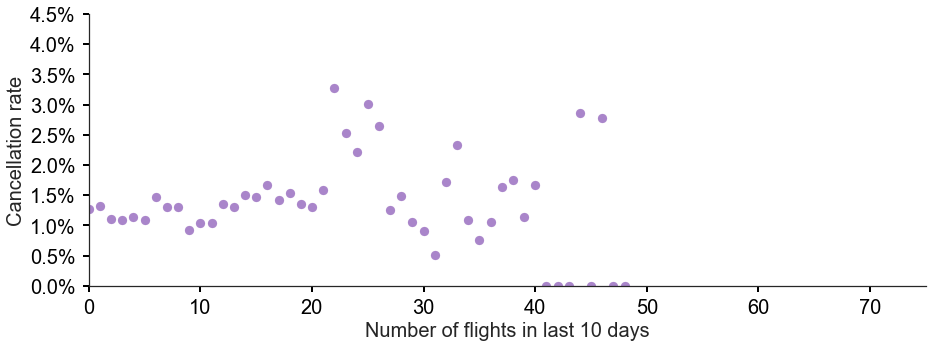

In [131]:
plot_canrate_by_contvar(contvar="Nflights_10", dft=dfd10, xlab="Number of flights in last 10 days", 
                        ylab="Cancellation rate", xlim=[0, 75], ylim=[0, 4.5], 
                        title = "", xlog=False, tbl=8, width=15, height=5);

We observe an oscillation behaviour with dips at multiples of 10. This directly corresponds to the peaks in the histogram above. To understand this better, lets pick one peak, say 10, which indicates that we are tracking flights (of the same type) that are scheduled only once a day. We have the most data points when the number of flights in last 10 days are 10, and least cancellation rate for 10 too. For less data points (or less distribution density), the cancellation rates are higher. A similar pattern is observed for other peaks too. However, after 30 the fluctuations are higher. For more than 60 number of flights in last 10 days, the cancellation rates are absolutely 0. Overall, we do not observe any linear or monotonic trend here, but there are periodic trends. Can we see a more general periodic trend? To see that, lets explore Nflghits_20 and Nflights_30, i.e. the number of flights in last 20 and 30 days, respectively. We can visualize all of them together.

#### Nflights_10, Nflights_20, Nflights_30

In [132]:
def dist_plot_all_ndays(df, col, width, height, xlab, ylab, title, xlim, ylim):
    """ This function plots the distribution of a historical performance column for all three ndays.
    
    Parameters
    ----------
    df (dtype: pd.DataFrame): The data frame which contains the historical performance columns
    col (dtype: str): The prefix of the name of the historical column
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title of the plot
    xlim (dtype: list): The list of numbers to limit x-axis. Example: [2.5, 4]
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [0, 12.5]
    """
    sns.set(rc={"figure.figsize": (width, height)})
    sns.set_style("white")
    ax = sns.distplot(df[col+"_10"], norm_hist=False, kde = True, bins=500, label="ndays = 10", color=tableau20[8])
    ax = sns.distplot(df[col+"_20"], norm_hist=False, kde = True, bins=500, label="ndays = 20", color=tableau20[0])
    ax = sns.distplot(df[col+"_30"], norm_hist=False, kde = True, bins=500, label="ndays = 30", color=tableau20[2])
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.title(title, fontsize=24)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.legend(fontsize=20)
    ax.tick_params(direction='out', length=6, width=2, colors='k')
    hide_topright(ax)

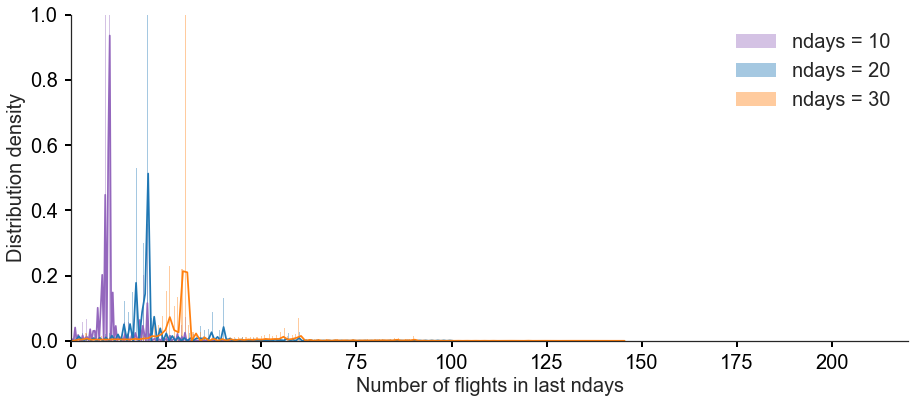

In [134]:
dist_plot_all_ndays(df, col="Nflights", width=15, height=6, 
                    xlab="Number of flights in last ndays", ylab="Distribution density", title="", 
                    xlim=[0,220], ylim=[0,1])

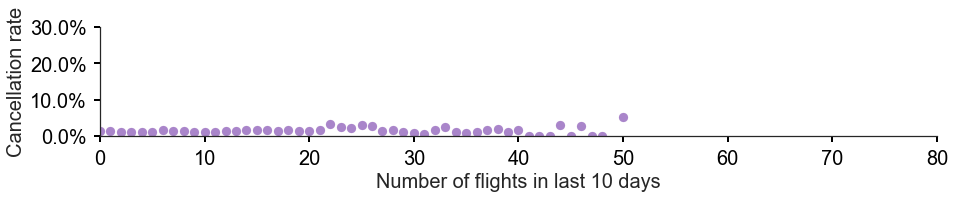

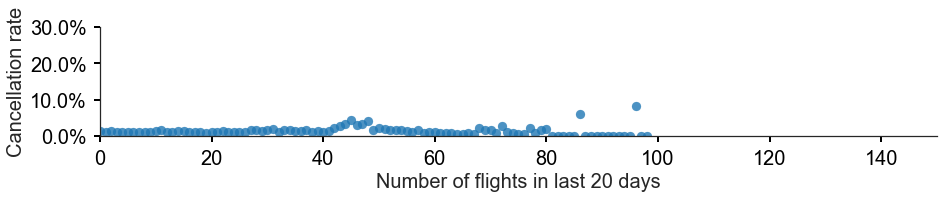

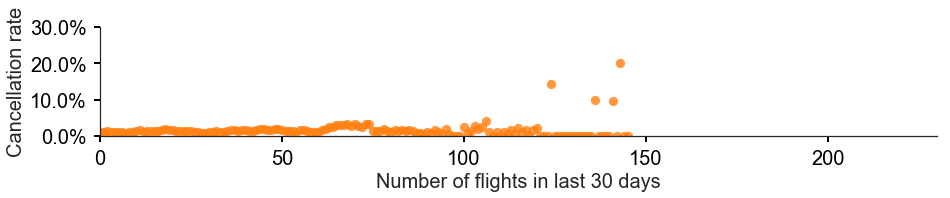

In [135]:
dfd20 = create_canrate_by_contvar_df("Nflights_20", df)
dfd30 = create_canrate_by_contvar_df("Nflights_30", df)
plot_canrate_by_contvar(contvar="Nflights_10", dft=dfd10, xlab="Number of flights in last 10 days", 
                        ylab="Cancellation rate", title="",xlim=[0, 80], ylim=[0, 30], xlog=False, tbl=8, width=15, height=2);
plot_canrate_by_contvar(contvar="Nflights_20", dft=dfd20, xlab="Number of flights in last 20 days", 
                        ylab="Cancellation rate", title="", xlim=[0, 150], ylim=[0, 30], xlog=False, tbl=0, width=15, height=2);
plot_canrate_by_contvar(contvar="Nflights_30", dft=dfd30, xlab="Number of flights in last 30 days", 
                        ylab="Cancellation rate", title="", xlim=[0, 230], ylim=[0, 30], xlog=False, tbl=2, width=15, height=2);

In order to see the trends clearly, lets ignore two data points for which the cancellation rates are higher than 8%.

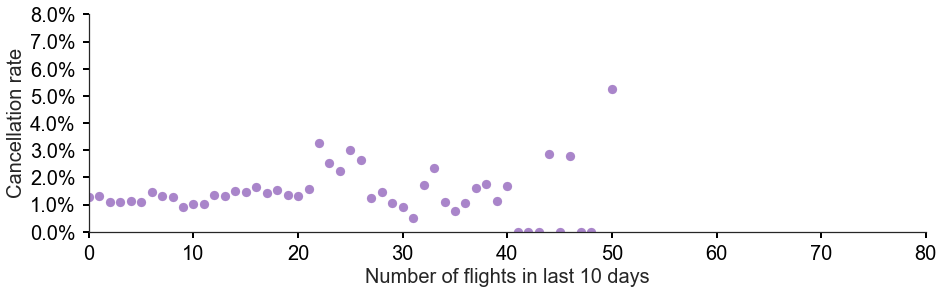

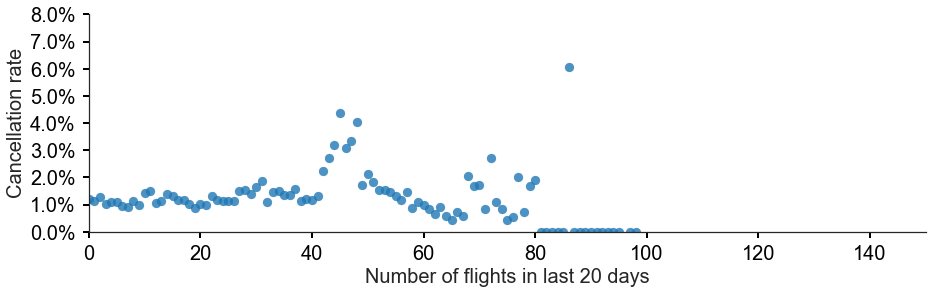

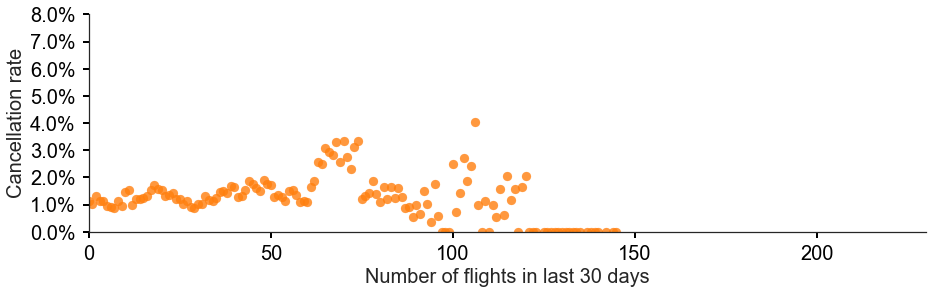

In [136]:
plot_canrate_by_contvar(contvar="Nflights_10", dft=dfd10, xlab="Number of flights in last 10 days", 
                        ylab="Cancellation rate", title = "", xlim=[0, 80], ylim=[0, 8], xlog=False, tbl=8, width=15, height=4);
plot_canrate_by_contvar(contvar="Nflights_20", dft=dfd20, xlab="Number of flights in last 20 days", 
                        ylab="Cancellation rate", title = "", xlim=[0, 150], ylim=[0, 8], xlog=False, tbl=0, width=15, height=4);
plot_canrate_by_contvar(contvar="Nflights_30", dft=dfd30, xlab="Number of flights in last 30 days", 
                        ylab="Cancellation rate", title = "", xlim=[0, 230], ylim=[0, 8], xlog=False, tbl=2, width=15, height=4);

A very similar trend is seen for 20 and 30 days history too. We see peaks in distribution at multiple of 20 and troughs in cancellation rates at same points when we look at 20 days history data. For 30 days history, the peaks in distribution are seen at multiple of 20 and troughs in cancellation rates are seen at same points. 


So, whether the history is for 10, 20 or 30 days, we observe a general periodic trend in cancellation rates with minimum at multiple of ndays (where ndays is the number of days we are looking the history for).

Lets now explore if the number of cancellations in last ndays has any effect on the likelhood of cancellation for today (or for the flight in question).

#### Ncan_10

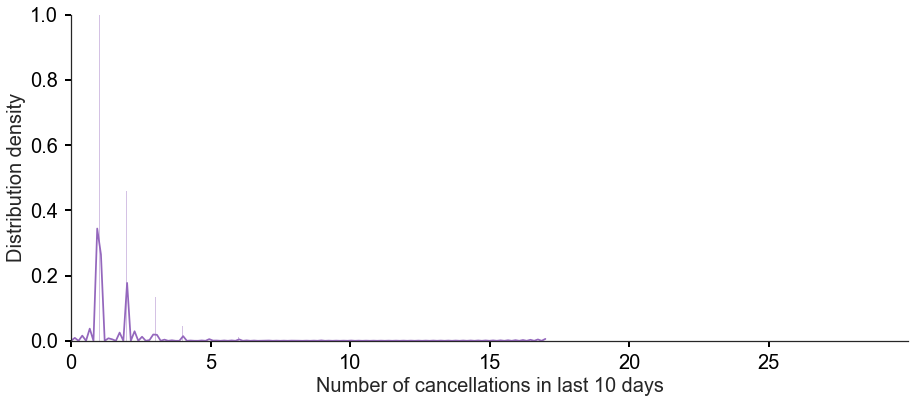

In [137]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.Ncan_10, norm_hist=False, kde = True, bins=500, color=tableau20[8])
plt.xlabel("Number of cancellations in last 10 days", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
plt.xticks([0, 5, 10, 15, 20, 25], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,1])
plt.xlim([0,30])
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

In [138]:
df.Ncan_10.describe()

count    2.857139e+06
mean     1.314378e-01
std      4.964101e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.700000e+01
Name: Ncan_10, dtype: float64

The majority of flights have only 1 cancelled flight in last 10 days. There are flights (or may be a flight) of the same type with 26 cancellations in last 10 days. We can plot similar type of scatter plots that we did for Nflights_ndays.

In [139]:
dfd10 = create_canrate_by_contvar_df("Ncan_10", df)

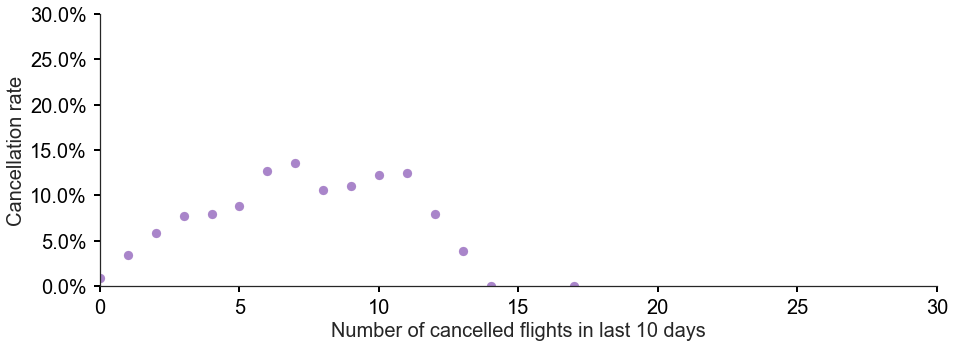

In [140]:
plot_canrate_by_contvar(contvar="Ncan_10", dft=dfd10, xlab="Number of cancelled flights in last 10 days", 
                        ylab="Cancellation rate", title="", xlim=[0, 30], ylim=[0, 30], xlog=False, tbl=8, width=15, height=5);

Lets try to understand this plot by picking one data point, say x = 2, y $\sim$ 6%. For this point, we get all the flights (or rows) for which the 10 days hostory tells us that 2 flights got cancelled in last 10 days. Out of all those selected flights, we then count the number of flights that got cancelled. The ratio of these the number of cancelled flights to the total number of selected flights is what we report on the y axis, in this case it is about 6%. We see a parabolic trend between the two variables with maximum cancellation rate occuring when the number of cancelled flights are about 10. 


Lets visualize the distributions for all ndays together.

#### Ncan_10, Ncan_20, Ncan_30

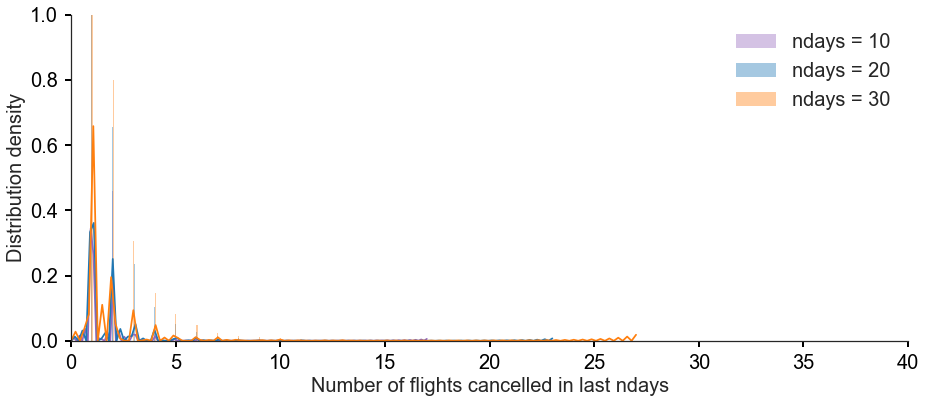

In [141]:
dist_plot_all_ndays(df, col="Ncan", width=15, height=6, 
                    xlab="Number of flights cancelled in last ndays", ylab="Distribution density", title="",
                    xlim=[0,40], ylim=[0,1])

How about the effect of the number of cancelled flights in last ndays on cancellation rates for all three values of ndays?

In [142]:
dfd20 = create_canrate_by_contvar_df("Ncan_20", df)
dfd30 = create_canrate_by_contvar_df("Ncan_30", df)

In [143]:
def scatter_plot_all_ndays(dfd10, dfd20, dfd30, width, height, xlab, ylab, title, xlim, ylim):
    """ This function plots the scatter plot for cancellation rates as a function of given historical feield 
    for all three values of ndays.
    
    Parameters
    ----------
    dfd10 (dtype: pd.DataFrame): The small data frame for ndays = 10
    dfd20 (dtype: pd.DataFrame): The small data frame for ndays = 20
    dfd30 (dtype: pd.DataFrame): The small data frame for ndays = 30
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title of the plot
    xlim (dtype: list): The list of numbers to limit x-axis. Example: [2.5, 4]
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [0, 12.5]
    """
    fig, ax = plt.subplots(figsize=(width,height))
    #ax.scatter(dfd10[[0]], dfd10[[1]], color=tableau20[8], s=80, alpha=0.3, label="ndays = 10")
    #ax.scatter(dfd20[[0]], dfd20[[1]], color=tableau20[0], s=150, alpha=0.3, label="ndays = 20")
    #ax.scatter(dfd30[[0]], dfd30[[1]], color=tableau20[2], s=210, alpha=0.3, label="ndays = 30")

    ax.scatter(dfd10.iloc[:,0], dfd10.iloc[:,1], color=tableau20[8], s=80, alpha=0.3, label="ndays = 10")
    ax.scatter(dfd20.iloc[:,0], dfd20.iloc[:,1], color=tableau20[0], s=150, alpha=0.3, label="ndays = 20")
    ax.scatter(dfd30.iloc[:,0], dfd30.iloc[:,1], color=tableau20[2], s=210, alpha=0.3, label="ndays = 30")

    ax.set_xlabel(xlab, size=20)
    ax.set_ylabel(ylab, size=20)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title, size=24)
    ax.tick_params(direction='out', length=6, width=2, colors='k')
    plt.xticks(size=20)
    plt.yticks(size=20)
    hide_topright(ax)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    plt.legend(fontsize=20)

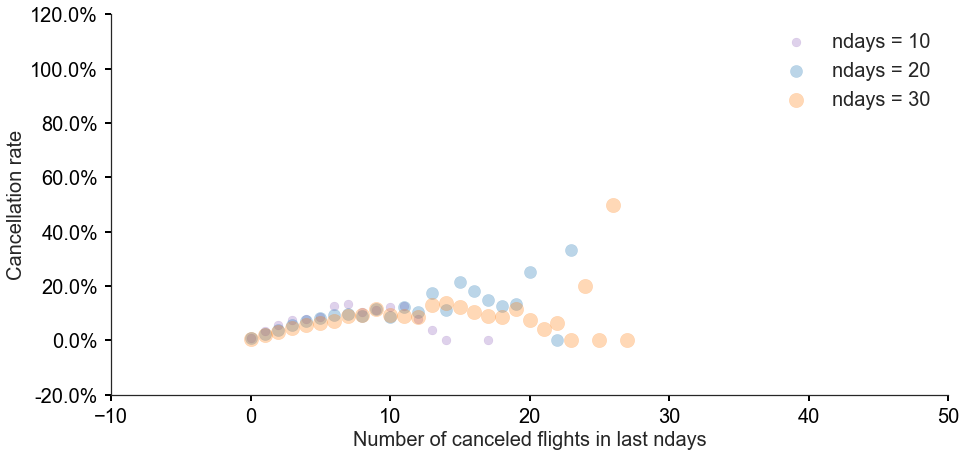

In [144]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, 
                       xlab="Number of canceled flights in last ndays", 
                       ylab="Cancellation rate", title="", xlim=[-10,50], ylim=[-20, 120])

For all ndays, we observe a parabolic pattern with maximum in cancellation occuring at different values of the number of cancellations in last ndays. There also appears to be some outliers in all three cases, usually at higher values of the number of cancellations in last ndays. 

#### Ndiv_10

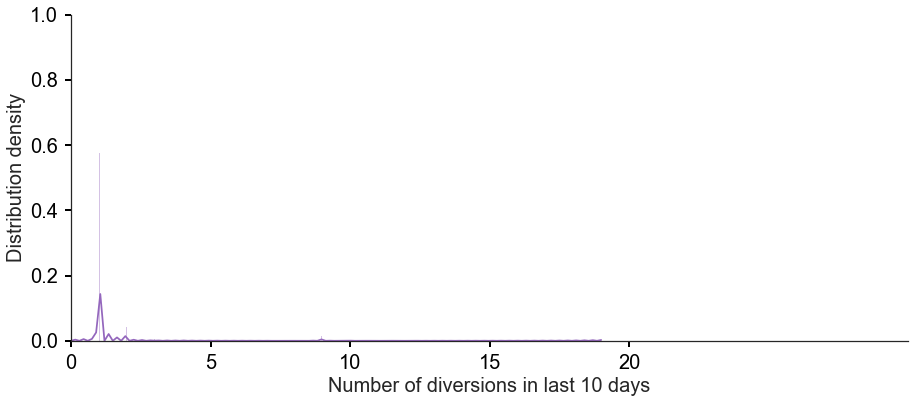

In [145]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.Ndiv_10, norm_hist=False, kde = True, bins=500, color=tableau20[8])
plt.xlabel("Number of diversions in last 10 days", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
plt.xticks([0, 5, 10, 15, 20], fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,1])
plt.xlim([0,30])
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

In [146]:
df.Ndiv_10.describe()

count    2.857139e+06
mean     3.109719e-02
std      2.794021e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.900000e+01
Name: Ndiv_10, dtype: float64

The majority of flights have only 1 diverted flight in last 10 days. There are flights (or may be a flight) of the same type with 19 diversions in last 10 days. We can plot similar type of scatter plots that we did for Ncan_ndays.

In [147]:
dfd10 = create_canrate_by_contvar_df("Ndiv_10", df)

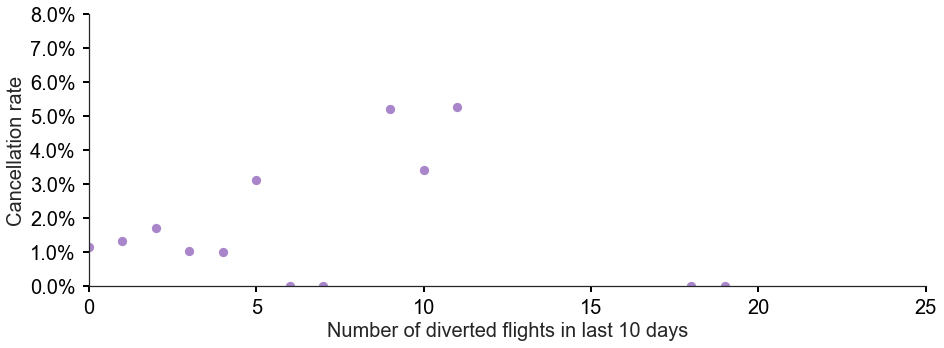

In [149]:
plot_canrate_by_contvar(contvar="Ndiv_10", dft=dfd10, xlab="Number of diverted flights in last 10 days", 
                        ylab="Cancellation rate", title = "", xlim=[0, 25], ylim=[0, 8], xlog=False, tbl=8, width=15, height=5);

Similar to Nflights_ndays and Ncan_ndays, lets look at all ndays history together.

#### Ndiv_10, Ndiv_20, Ndiv_30

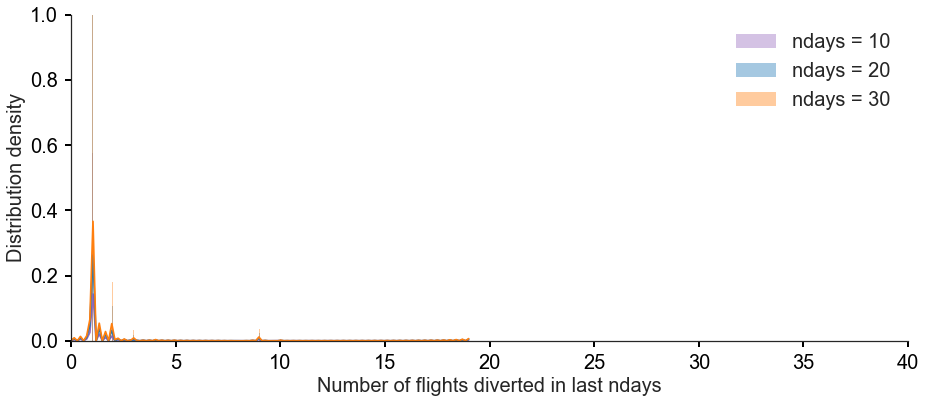

In [150]:
dist_plot_all_ndays(df, col="Ndiv", width=15, height=6, 
                    xlab="Number of flights diverted in last ndays", ylab="Distribution density", title="",
                    xlim=[0,40], ylim=[0,1])

In [151]:
dfd20 = create_canrate_by_contvar_df("Ndiv_20", df)
dfd30 = create_canrate_by_contvar_df("Ndiv_30", df)

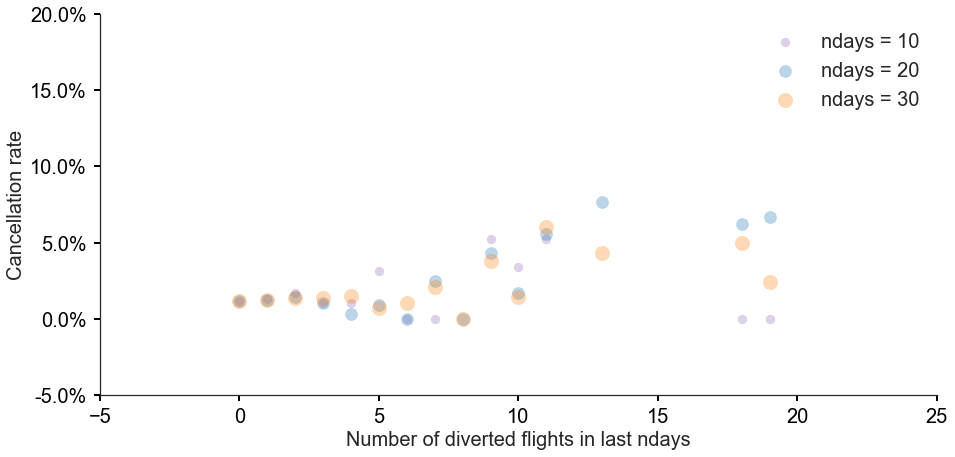

In [152]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, 
                       xlab="Number of diverted flights in last ndays", 
                       ylab="Cancellation rate", title="", xlim=[-5,25], ylim=[-5, 20])

Usually, the canellation likelihood for a flight is higher when the number of diversions of that flight in the last ndays are higher.


Having looked at various numbers, lets now look at some more intersting numbers related with historical performances. Sometimes, we come across a flight for which we do not find any history in ndays. We call such flights as temporary flights. The term "temporary" could be different for different ndays. For example, a flight can be temporary if looked at 10 days history but "routine" if looked at 30 days history. This is why we have three such fields: (i) TempFlight_10, (ii) TempFlight_20, and (iii) TempFlight_30 that have 0 and 1 indicating if the flight was temporary or not. Lets explore these indicator columns now.


#### TempFlight_10, TempFlight_20, TempFlight_30 

How many flights were temporary (based on ndays history)?

Is it the case that a temporary flight has high or low probability of cancellation?

Lets find answers to these questions.

In [153]:
print(100*sum(df.TempFlight_10 == 1)/len(df), "% of the total flights were temporary based on 10 days history")
print(100*sum(df.TempFlight_20 == 1)/len(df), "% of the total flights were temporary based on 20 days history")
print(100*sum(df.TempFlight_30 == 1)/len(df), "% of the total flights were temporary based on 30 days history")

0.0752501015876 % of the total flights were temporary based on 10 days history
0.0612150826404 % of the total flights were temporary based on 20 days history
0.0536200723871 % of the total flights were temporary based on 30 days history


The fractions of temporary flights are very small. However, do these very small number of temporary flights have high chance of getting cancelled? Lets find out.

In [154]:
def bar_plot_two_class_compare(df, col, xlab, ylab, title, legend_loc):
    """ This function creates a bar chart comparing cancellation rates for two classes
    
    Parameters
    ----------
    df (dtype: pd.DataFrame): The data frame
    col (dtype: str): The prefix of the historical indicator column
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title of the plot
    """
    ax = pd.concat([create_canrate_by_contvar_df(col+"_10", df), 
           create_canrate_by_contvar_df(col+"_20", df),
           create_canrate_by_contvar_df(col+"_30", df)], 
               axis=1).iloc[:, [1,3,5]].plot(kind="bar",
                                             color=[tableau20[8], tableau20[0], tableau20[2]], zorder=0)

    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(title, fontsize=22)
    plt.legend(["ndays = 10", "ndays = 20", "ndays = 30"], fontsize=20, loc=legend_loc)
    ax.tick_params(direction='out', length=6, width=2, colors='k')
    hide_topright(ax)
    ax.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])

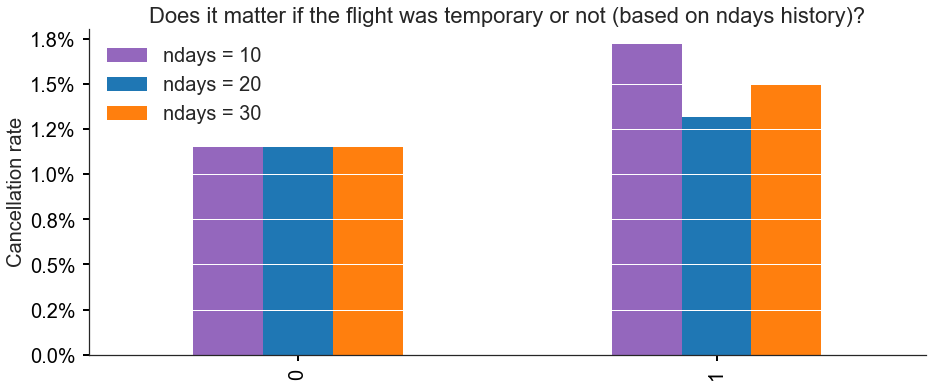

In [156]:
bar_plot_two_class_compare(df, "TempFlight", xlab="", 
                           ylab="Cancellation rate", 
                           title="Does it matter if the flight was temporary or not (based on ndays history)?",
                          legend_loc=2)

Here, 1 indicates the temporary flight. For any ndays, whether the flight was temporary or not, the cancellation rates are pretty small. However, the cancellation rates are little bit higher for temporary flights as compared with non-temporary (or routine) flights.

For some flights, all the similar flights in the last ndays got cancelled. If all the similar flights in last ndays got cancelled, is the current flight in question going to be cancelled as well? We track this information about the all flight cancellation in in last ndays by the following columns:


#### AllCanceled_10, AllCanceled_20, AllCanceled_30


These columns have value 1 if all the flights in last ndays got canceled, otherwise 0. The temporary flights are not included in these indicator columns. In other words, these columns have value 0 for temporary flights.

In [157]:
print(100*sum(df.AllCanceled_10 == 1)/len(df), "% of the total flights had 100% cancellation history based on last 10 days")
print(100*sum(df.AllCanceled_20 == 1)/len(df), "% of the total flights had 100% cancellation history based on last 20 days")
print(100*sum(df.AllCanceled_30 == 1)/len(df), "% of the total flights had 100% cancellation history based on last 30 days")

0.596575805377 % of the total flights had 100% cancellation history based on last 10 days
0.481950650633 % of the total flights had 100% cancellation history based on last 20 days
0.405405547297 % of the total flights had 100% cancellation history based on last 30 days


The fractions of the flights with 100 cancellation history in ndays are very small. However, do these very small number of such flights have high chance of getting cancelled? Lets find out.

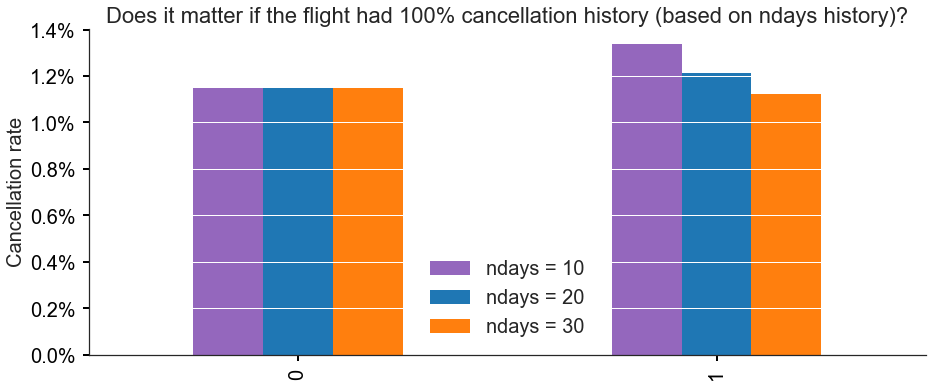

In [158]:
bar_plot_two_class_compare(df, "AllCanceled", xlab="", 
                           ylab="Cancellation rate", 
                           title="Does it matter if the flight had 100% cancellation history (based on ndays history)?",
                          legend_loc=0)

Looking at 30 days history, cancellation rate was slightly smaller for the flights with 100$\%$ cancellation history. However, when we look at 10 and 20 days history, then the flights have relatively higher cancellation rates if all the similar flights got cancelled in the last 10, 20 days.

Similar to AllCanceled_ndays, we also have AllDiverted_ndays. These columns indicate if, for a given flight, all the flights in last ndays got diverted. Lets explore these columns now.


#### AllDiverted_10, AllDiverted_20, AllDiverted_30


These columns have value 1 if all the flights in last ndays got diverted, otherwise 0. The "all canceled history" flights and temporary flights are not included in these indicator columns. In other words, these columns have value 0 for temporary flights and for flights that had 100% cancellation history.

In [159]:
print(100*sum(df.AllDiverted_10 == 1)/len(df), "% of the total flights had 100% diversion history based on last 10 days")
print(100*sum(df.AllDiverted_20 == 1)/len(df), "% of the total flights had 100% diversion history based on last 20 days")
print(100*sum(df.AllDiverted_30 == 1)/len(df), "% of the total flights had 100% diversion history based on last 30 days")

0.00255500344925 % of the total flights had 100% diversion history based on last 10 days
0.000770001039501 % of the total flights had 100% diversion history based on last 20 days
0.000595000803251 % of the total flights had 100% diversion history based on last 30 days


These numbers are really very small. Even then, lets see if it gives any interesting pattern.

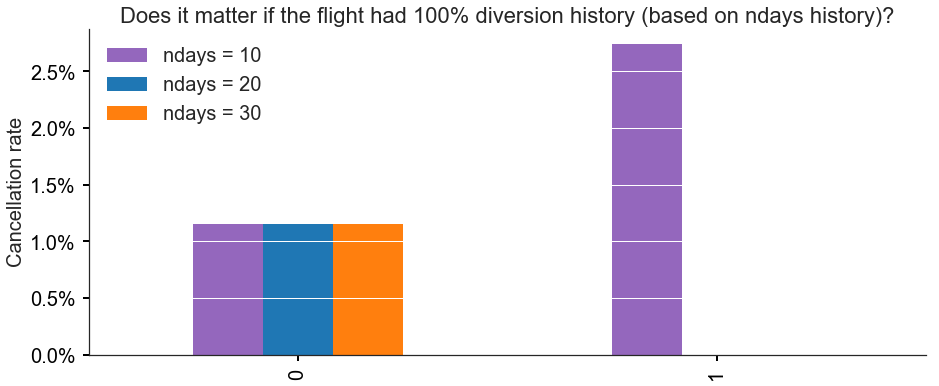

In [160]:
bar_plot_two_class_compare(df, "AllDiverted", xlab="", 
                           ylab="Cancellation rate", 
                           title="Does it matter if the flight had 100% diversion history (based on ndays history)?",
                          legend_loc=2)

If we look at 10 days history, it is about 2 times more likelihood for the cancellation of the flight that had 100% diversion history. For 20 and 30 days history, none of the flights, that had 100% diversion, got canceled.

Along the same lines, we also have AllCanDiv_ndays columns. These fields indicate if, for a given flight, all the flights in last ndays either cancelled OR diverted.


#### AllCanDiv_10, AllCanDiv_20, AllCanDiv_30

These columns have value 1 if all the flights in last ndays either got canceled or diverted, otherwise 0. The temporary flights, and the flights for which there was 100% cancellation or diversion history, are not included in these indicator columns. In other words, these columns have value 0 for temporary flights, all cancelled history flights and all diverted history flights.

In [161]:
print(100*sum(df.AllCanDiv_10 == 1)/len(df), "% of the total flights had 100% of the flights in last 10 days that either got canceled or diverted")
print(100*sum(df.AllCanDiv_20 == 1)/len(df), "% of the total flights had 100% of the flights in last 20 days that either got canceled or diverted")
print(100*sum(df.AllCanDiv_30 == 1)/len(df), "% of the total flights had 100% of the flights in last 30 days that either got canceled or diverted")

0.0 % of the total flights had 100% of the flights in last 10 days that either got canceled or diverted
0.000140000189 % of the total flights had 100% of the flights in last 20 days that either got canceled or diverted
0.0 % of the total flights had 100% of the flights in last 30 days that either got canceled or diverted


The fractions are actually 0 for 10 and 30 days history but very small fraction for 20 days history. 

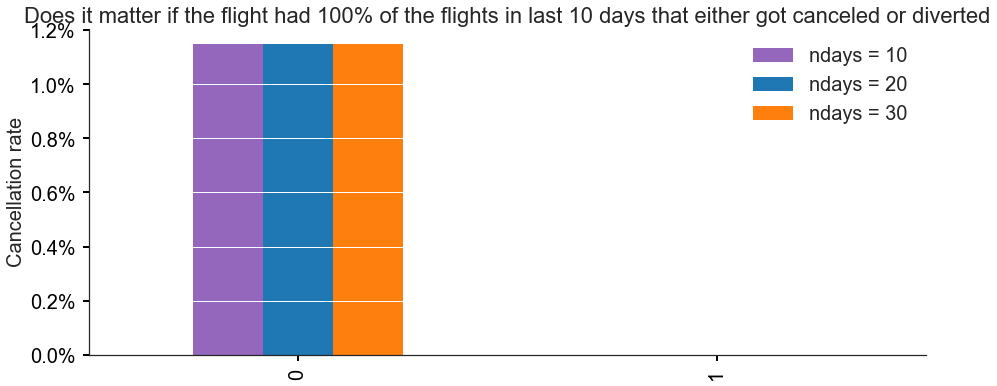

In [162]:
bar_plot_two_class_compare(df, "AllCanDiv", xlab="", 
                           ylab="Cancellation rate", 
                           title="Does it matter if the flight had 100% of the flights in last 10 days that either got canceled or diverted",
                          legend_loc=0)

When a "routine "flight has a history such that all the similar flights in last ndays got either canceled or diverted (but no 100% cancellation and no 100% diversion), then its cancellation rate was 0.


Having looked at numbers of flights in various scenarios, lets focus on some historical statistics such as median, and max values of delays, taxi time etc.

#### DepDelayMedian_10

This is the median value of the departure delays (in minutes) in last 10 days.

In [163]:
df.DepDelayMedian_10.describe()

count    2.857139e+06
mean     1.900754e+00
std      1.084552e+01
min     -2.100000e+01
25%     -3.000000e+00
50%     -1.000000e+00
75%      3.000000e+00
max      1.372000e+03
Name: DepDelayMedian_10, dtype: float64

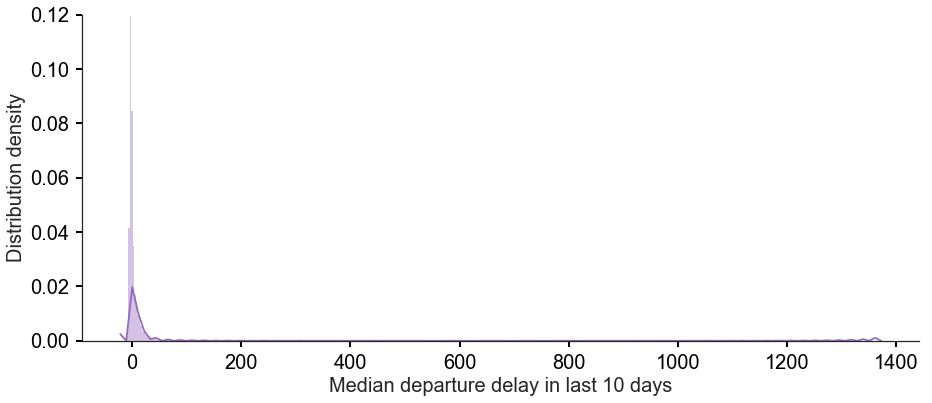

In [166]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_style("white")
ax = sns.distplot(df.DepDelayMedian_10, norm_hist=False, kde = True, bins=500, color=tableau20[8])
plt.xlabel("Median departure delay in last 10 days", fontsize=20)
plt.ylabel("Distribution density", fontsize=20)
#plt.xticks([0, 5, 10, 15, 20], fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim([0,0.12])
#plt.xlim([0,30])
ax.tick_params(direction='out', length=6, width=2, colors='k')
hide_topright(ax)

For most of the flights, the median dealy of the similar flights in last 10 days is close to 0. Ther are some flights for which the median delay of similar flights in last 10 days is even greater than 10 hours. However, number of such flights are very small as depicted in the tail of the above distribution. On the other extreme, there are flights that had very good historical performances. The history of these flights tell that there were early departures (on median) in last 10 days, but again the number of such flights were very small.

In [167]:
dfd10 = create_canrate_by_contvar_df("DepDelayMedian_10", df)

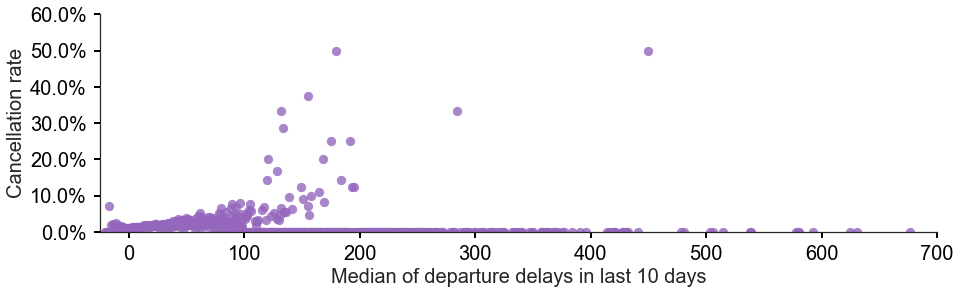

In [168]:
plot_canrate_by_contvar(contvar="DepDelayMedian_10", dft=dfd10, xlab="Median of departure delays in last 10 days", 
                        ylab="Cancellation rate", title = "", xlim=[-25, 700], ylim=[0, 60], xlog=False, tbl=8, width=15, height=4);

Cancellation rates are 0 when the medians of departure delays in last 10 days were greater than 200 minutes (except two instances). For less than 200 mins, there is a somewhat increasing cancellation rate as a function of median values. Lets visualize these plots for other ndays too.

#### DepDelayMedian_10, DepDelayMedian_20, DepDelayMedian_30

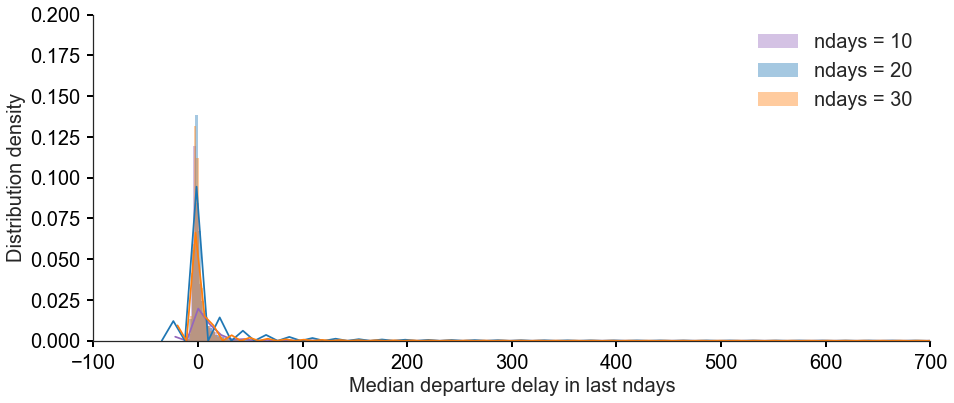

In [169]:
dist_plot_all_ndays(df, col="DepDelayMedian", width=15, height=6, xlab="Median departure delay in last ndays", 
                    ylab="Distribution density", title="", xlim=[-100,700], ylim=[0,0.2])

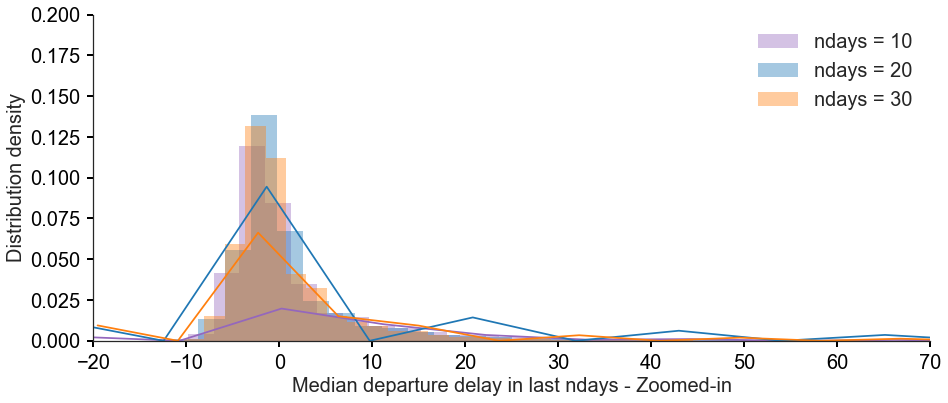

In [170]:
dist_plot_all_ndays(df, col="DepDelayMedian", width=15, height=6, 
                    xlab="Median departure delay in last ndays - Zoomed-in", 
                    ylab="Distribution density", title ="", xlim=[-20,70], ylim=[0,0.2])

In [171]:
dfd20 = create_canrate_by_contvar_df("DepDelayMedian_20", df)
dfd30 = create_canrate_by_contvar_df("DepDelayMedian_30", df)

We observe similar trends for all ndays cases.

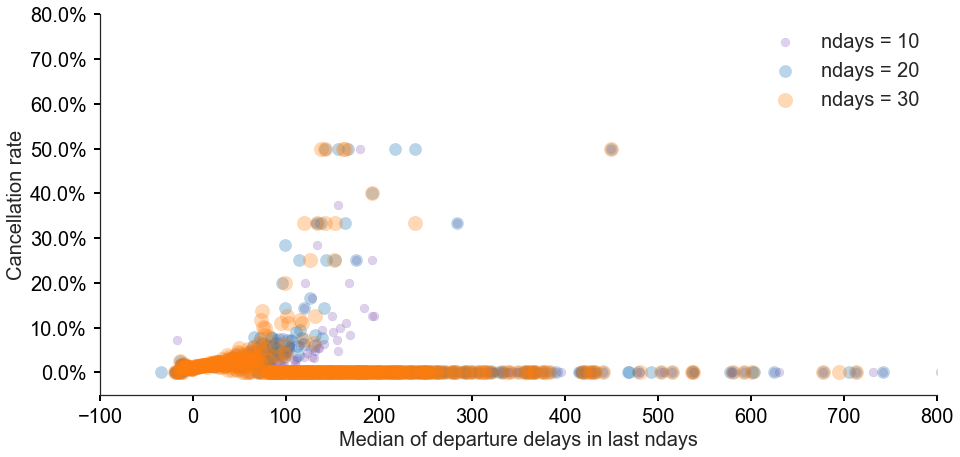

In [172]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, xlab="Median of departure delays in last ndays", 
                       ylab="Cancellation rate", title="", xlim=[-100,800], ylim=[-5,80])

We do not see any clear trend here, except some monotonicity for x < 70. Lets zoom-in the plot above and see if there is any pattern.

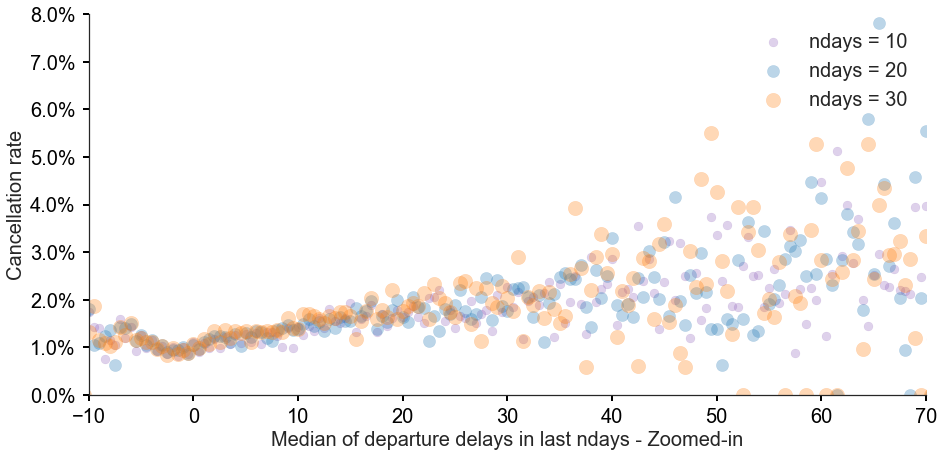

In [180]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, 
                       xlab="Median of departure delays in last ndays - Zoomed-in", 
                       ylab="Cancellation rate", title="", xlim=[-10,70], ylim=[0,8])

There seems to be some correlation when we zoom-in. Lets test these correlations using Spearman's $\rho$.

In [181]:
#stats.spearmanr(dfd10[(dfd10.DepDelayMedian_10 > -10) & (dfd10.DepDelayMedian_10 < 50)][[0]], 
#                dfd10[(dfd10.DepDelayMedian_10 > -10) & (dfd10.DepDelayMedian_10 < 50)][[1]])
stats.spearmanr(dfd10[(dfd10.DepDelayMedian_10 > -10) & (dfd10.DepDelayMedian_10 < 70)].iloc[:,0], 
                dfd10[(dfd10.DepDelayMedian_10 > -10) & (dfd10.DepDelayMedian_10 < 70)].iloc[:,1])

SpearmanrResult(correlation=0.77271315978027233, pvalue=8.368695040848129e-33)

In [182]:
#stats.spearmanr(dfd20[(dfd20.DepDelayMedian_20 > -10) & (dfd20.DepDelayMedian_20 < 50)][[0]], 
#                dfd20[(dfd20.DepDelayMedian_20 > -10) & (dfd20.DepDelayMedian_20 < 50)][[1]])
stats.spearmanr(dfd20[(dfd20.DepDelayMedian_20 > -10) & (dfd20.DepDelayMedian_20 < 70)].iloc[:,0], 
                dfd20[(dfd20.DepDelayMedian_20 > -10) & (dfd20.DepDelayMedian_20 < 70)].iloc[:,1])

SpearmanrResult(correlation=0.69193146917826109, pvalue=5.5869374138883425e-24)

In [183]:
#stats.spearmanr(dfd30[(dfd30.DepDelayMedian_30 > -10) & (dfd30.DepDelayMedian_30 < 50)][[0]], 
#                dfd30[(dfd30.DepDelayMedian_30 > -10) & (dfd30.DepDelayMedian_30 < 50)][[1]])
stats.spearmanr(dfd30[(dfd30.DepDelayMedian_30 > -10) & (dfd30.DepDelayMedian_30 < 70)].iloc[:,0], 
                dfd30[(dfd30.DepDelayMedian_30 > -10) & (dfd30.DepDelayMedian_30 < 70)].iloc[:,1])

SpearmanrResult(correlation=0.55019730533600364, pvalue=5.8117616030863277e-14)

There are pretty good correlations that are statistically significant. The range of medians that we picked above covers about 30% of all the data points as shown in the distribution plot.

In [184]:
print(len(dfd10[(dfd10.DepDelayMedian_10 > -10) & (dfd10.DepDelayMedian_10 < 70)])/len(dfd10))
print(len(dfd20[(dfd20.DepDelayMedian_20 > -10) & (dfd20.DepDelayMedian_20 < 70)])/len(dfd20))
print(len(dfd30[(dfd30.DepDelayMedian_30 > -10) & (dfd30.DepDelayMedian_30 < 70)])/len(dfd30))

0.26949152542372884
0.28597122302158273
0.318


Lets now look at the maximum values of departures delays in last n days.

#### DepDelayMax_10, DepDelayMax_20, DepDelayMax_30

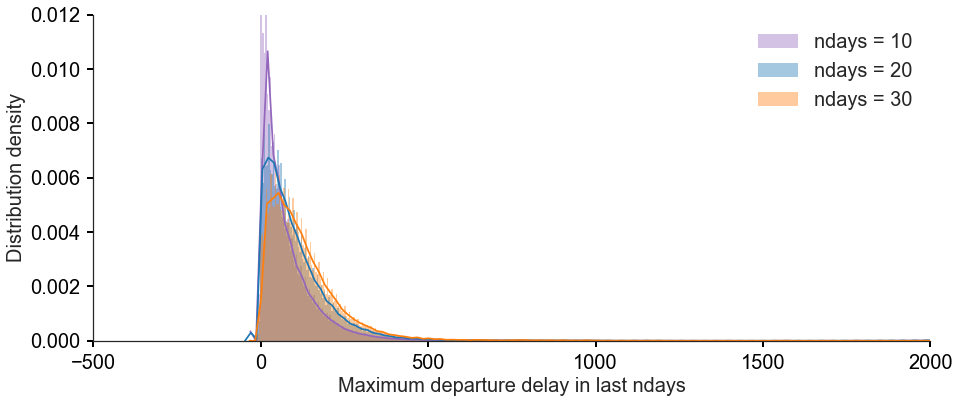

In [185]:
dist_plot_all_ndays(df, col="DepDelayMax", width=15, height=6, 
                    xlab="Maximum departure delay in last ndays", 
                    ylab="Distribution density", title="", xlim=[-500,2000], ylim=[0,0.012])

The distribution of maximum departure times is quite different from the distribution of median values. There are flights for which the similar flights in 30 days had a delay of more than a day! On the other hand, there are flights for which the similar flights in last ndays had early departures too. Lets now see the effect of maximum of departure delays in last ndays on cancellation rate.

In [186]:
dfd10 = create_canrate_by_contvar_df("DepDelayMax_10", df)
dfd20 = create_canrate_by_contvar_df("DepDelayMax_20", df)
dfd30 = create_canrate_by_contvar_df("DepDelayMax_30", df)

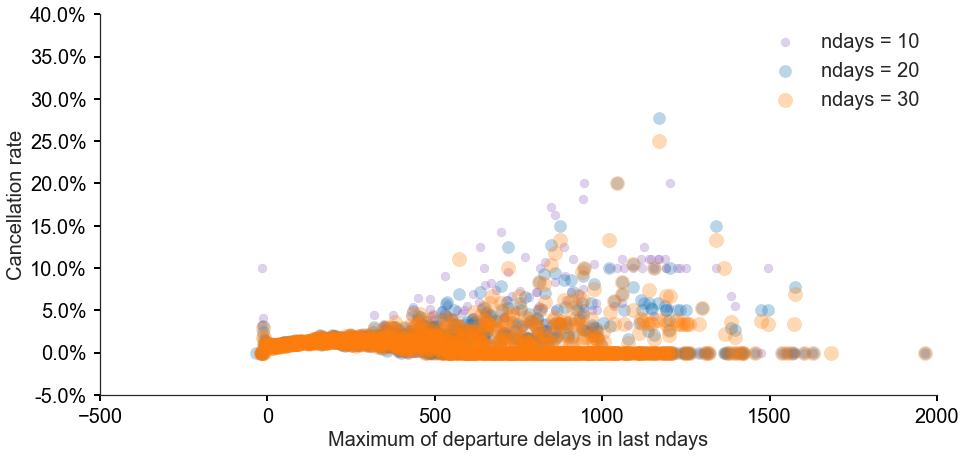

In [187]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, 
                       xlab="Maximum of departure delays in last ndays", 
                       ylab="Cancellation rate", title="", xlim=[-500,2000], ylim=[-5,40])

We do not see any clear trend here, except some monotonicity for x < 250. Lets zoom-in the plot above and see if there is any pattern.

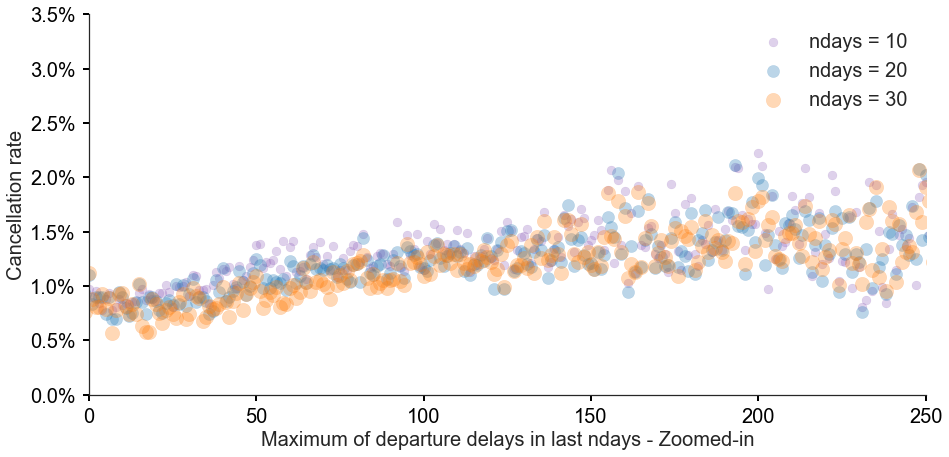

In [188]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, 
                       xlab="Maximum of departure delays in last ndays - Zoomed-in", 
                       ylab="Cancellation rate", title="", xlim=[0,250], ylim=[0,3.5])

There seems to be some linear behaviour here. Lets calculate the Spearman's $\rho$ and associated p-values for all ndays cases. 

In [189]:
#stats.spearmanr(dfd10[(dfd10.DepDelayMax_10 > 0) & (dfd10.DepDelayMax_10 < 250)][[0]], 
#                dfd10[(dfd10.DepDelayMax_10 > 0) & (dfd10.DepDelayMax_10 < 250)][[1]])
stats.spearmanr(dfd10[(dfd10.DepDelayMax_10 > 0) & (dfd10.DepDelayMax_10 < 250)].iloc[:,0], 
                dfd10[(dfd10.DepDelayMax_10 > 0) & (dfd10.DepDelayMax_10 < 250)].iloc[:,1])

SpearmanrResult(correlation=0.59570695685969688, pvalue=2.6224406404837584e-25)

In [190]:
#stats.spearmanr(dfd20[(dfd20.DepDelayMax_20 > 0) & (dfd20.DepDelayMax_20 < 250)][[0]], 
#                dfd20[(dfd20.DepDelayMax_20 > 0) & (dfd20.DepDelayMax_20 < 250)][[1]])
stats.spearmanr(dfd20[(dfd20.DepDelayMax_20 > 0) & (dfd20.DepDelayMax_20 < 250)].iloc[:,0], 
                dfd20[(dfd20.DepDelayMax_20 > 0) & (dfd20.DepDelayMax_20 < 250)].iloc[:,1])

SpearmanrResult(correlation=0.70444306257287215, pvalue=1.202747761040724e-38)

In [191]:
#stats.spearmanr(dfd30[(dfd30.DepDelayMax_30 > 0) & (dfd30.DepDelayMax_30 < 250)][[0]], 
#                dfd30[(dfd30.DepDelayMax_30 > 0) & (dfd30.DepDelayMax_30 < 250)][[1]])
stats.spearmanr(dfd30[(dfd30.DepDelayMax_30 > 0) & (dfd30.DepDelayMax_30 < 250)].iloc[:,0], 
                dfd30[(dfd30.DepDelayMax_30 > 0) & (dfd30.DepDelayMax_30 < 250)].iloc[:,1])

SpearmanrResult(correlation=0.79273766031869408, pvalue=5.0650512812126809e-55)

There are pretty good correlations between cancellation rate and maximum values of departure delays in last ndays for all ndays (10, 20, 30) and the correlations are statistically significant. The correlation above is seen for the cases when the maximum of departure delays are between 0 and 250 mins, which covers about 22% of the data points as seen in the distribution plot.

In [193]:
print(len(dfd10[(dfd10.DepDelayMax_10 > 0) & (dfd10.DepDelayMax_10 < 250)])/len(dfd10))
print(len(dfd20[(dfd20.DepDelayMax_20 > 0) & (dfd20.DepDelayMax_20 < 250)])/len(dfd20))
print(len(dfd30[(dfd30.DepDelayMax_30 > 0) & (dfd30.DepDelayMax_30 < 250)])/len(dfd30))

0.226775956284153
0.22698268003646307
0.226775956284153


We have looked at departure delays history, now lets take a look at arrival delays history for all three ndays cases in the same manner.

#### ArrDelayMedian_10, ArrDelayMedian_20, ArrDelayMedian_30

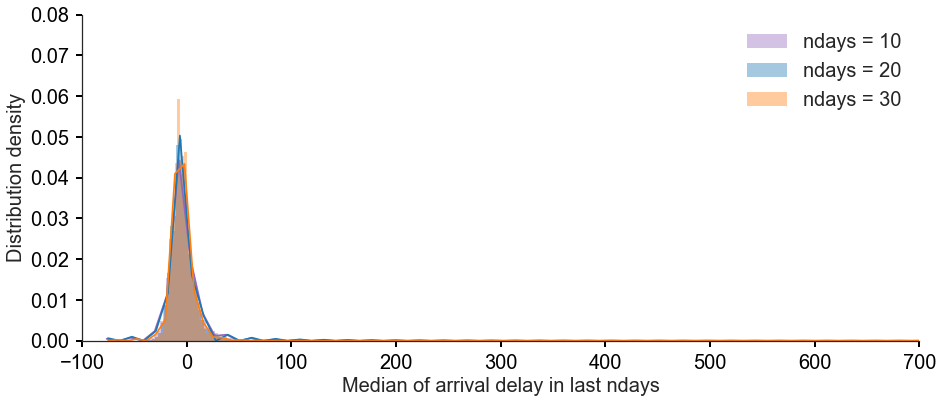

In [194]:
dist_plot_all_ndays(df, col="ArrDelayMedian", width=15, height=6, 
                    xlab="Median of arrival delay in last ndays", 
                    ylab="Distribution density", title="", xlim=[-100,700], ylim=[0,0.08])

The distributions for all ndays are pretty normal except a long tail on the right. The mean of the median distribution is very close to 0. Lets look at the effect of these median values on cancellation rates.

In [195]:
dfd10 = create_canrate_by_contvar_df("ArrDelayMedian_10", df)
dfd20 = create_canrate_by_contvar_df("ArrDelayMedian_20", df)
dfd30 = create_canrate_by_contvar_df("ArrDelayMedian_30", df)

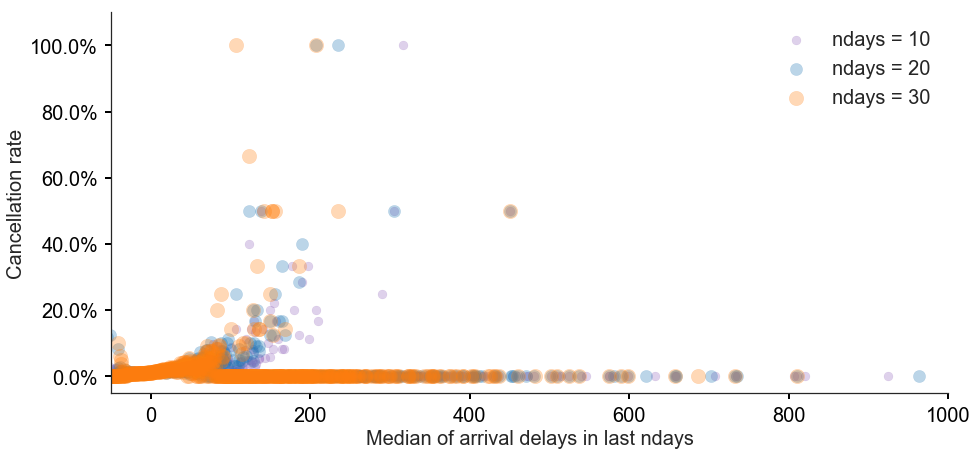

In [196]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, 
                       xlab="Median of arrival delays in last ndays", 
                       ylab="Cancellation rate", title="", xlim=[-50,1000], ylim=[-5,110])

This scatter plot lookes very similar to the one that we got for medians of departure delays. In this case also, lets zoom in from -20 to 20 and see if we get any relation between two variables.

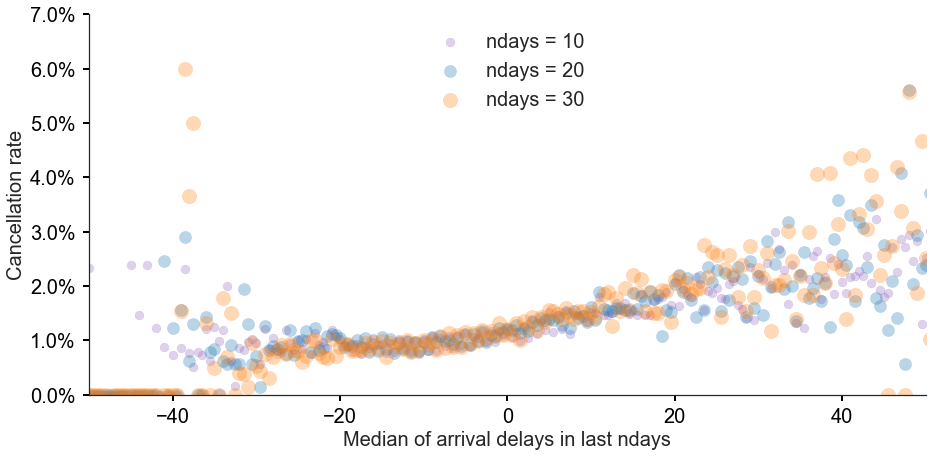

In [197]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, 
                       xlab="Median of arrival delays in last ndays", 
                       ylab="Cancellation rate", title="", xlim=[-50,50], ylim=[0,7])

There appears to a parabolic pattern here.

The pattern above is seen for the cases when the medians of arrival delays are between -50 and 50 mins, which covers about 17-20% of the data points as seen in the distribution plot.

In [199]:
print(len(dfd10[(dfd10.ArrDelayMedian_10 > -30) & (dfd10.ArrDelayMedian_10 < 30)])/len(dfd10))
print(len(dfd20[(dfd20.ArrDelayMedian_20 > -30) & (dfd20.ArrDelayMedian_20 < 30)])/len(dfd20))
print(len(dfd30[(dfd30.ArrDelayMedian_30 > -30) & (dfd30.ArrDelayMedian_30 < 30)])/len(dfd30))

0.17024320457796852
0.18364197530864199
0.20203735144312393


#### ArrDelayMax_10, ArrDelayMax_20, ArrDelayMax_30

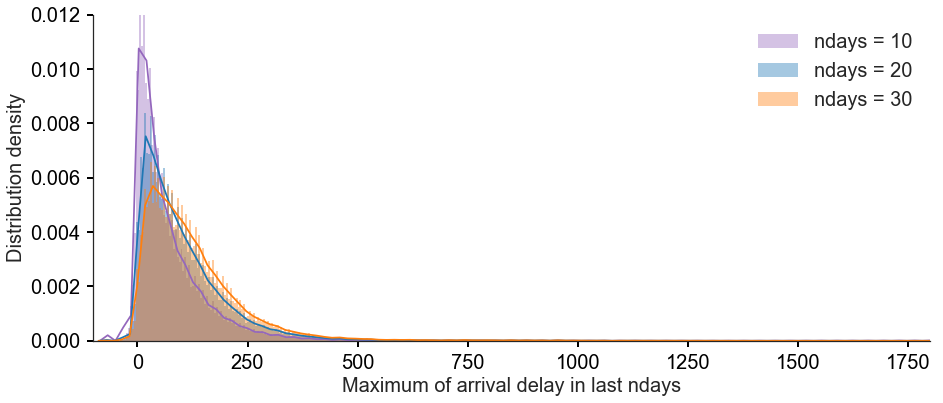

In [200]:
dist_plot_all_ndays(df, col="ArrDelayMax", width=15, height=6, 
                    xlab="Maximum of arrival delay in last ndays", 
                    ylab="Distribution density", title="", xlim=[-100,1800], ylim=[0,0.012])

In [201]:
dfd10 = create_canrate_by_contvar_df("ArrDelayMax_10", df)
dfd20 = create_canrate_by_contvar_df("ArrDelayMax_20", df)
dfd30 = create_canrate_by_contvar_df("ArrDelayMax_30", df)

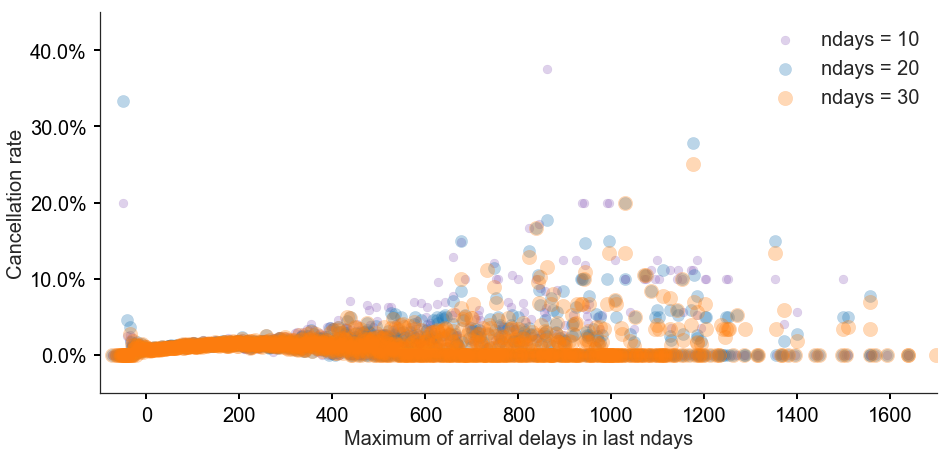

In [202]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, 
                       xlab="Maximum of arrival delays in last ndays", 
                       ylab="Cancellation rate", title="", xlim=[-100,1700], ylim=[-5,45])

Lets zoom in from 0 to 500 and see if we get any relation between two variables.

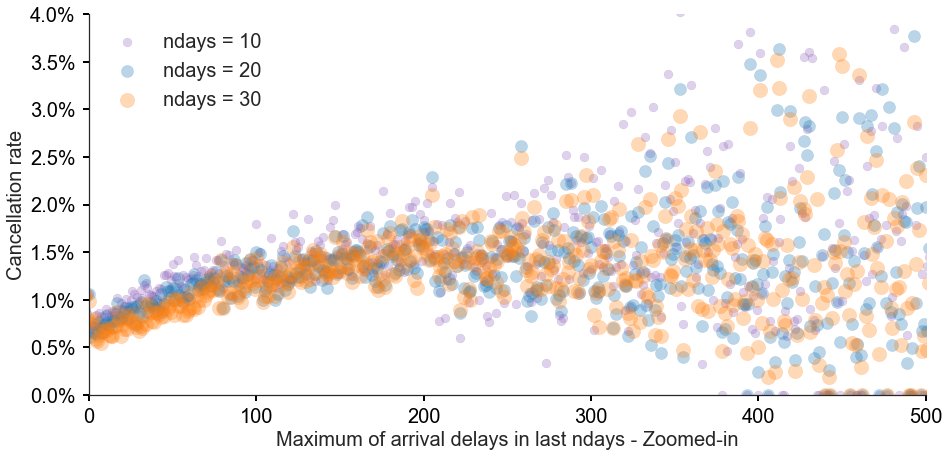

In [203]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, 
                       xlab="Maximum of arrival delays in last ndays - Zoomed-in", 
                       ylab="Cancellation rate", title="",  xlim=[0,500], ylim=[0,4])

Here also we see parabolic trends for all ndays cases. The pattern above is seen for the cases when the maximums of arrival delays are between 0 and 500 mins, which covers about 44% of the data points as seen in the distribution plot.

In [205]:
print(len(dfd10[(dfd10.ArrDelayMax_10 > 0) & (dfd10.ArrDelayMax_10 < 500)])/len(dfd10))
print(len(dfd20[(dfd20.ArrDelayMax_20 > 0) & (dfd20.ArrDelayMax_20 < 500)])/len(dfd20))
print(len(dfd30[(dfd30.ArrDelayMax_30 > 0) & (dfd30.ArrDelayMax_30 < 500)])/len(dfd30))

0.4423758865248227
0.44434550311665183
0.44316163410301956


We will now explore the histories of taxi times. Lets start with Taxi-out time. This is the time duration between the time when pilot releases the parking brake from the departing gate and the time when the plane takes off (or the wheels off time).


#### TaxiOutMedian_10, TaxiOutMedian_20, TaxiOutMedian_30

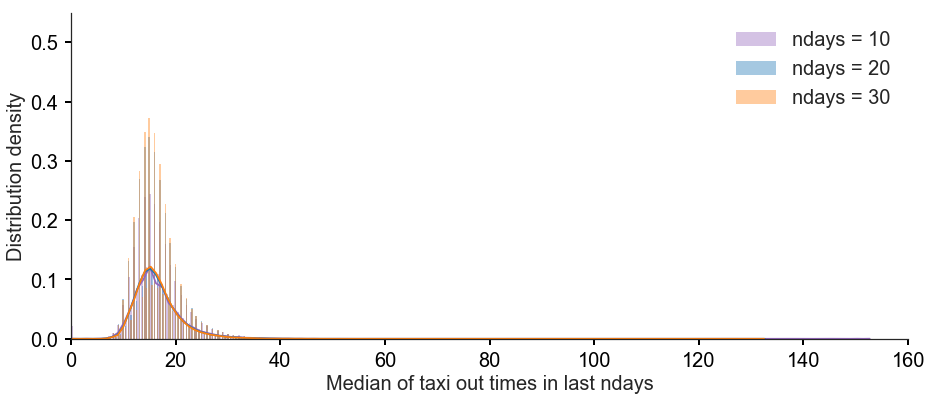

In [206]:
dist_plot_all_ndays(df, col="TaxiOutMedian", width=15, height=6, 
                    xlab="Median of taxi out times in last ndays", 
                    ylab="Distribution density", title="", xlim=[0,160], ylim=[0,0.55])

The taxi out time cannot be negative, so we dont have any negative numbers here. The distribution looks pretty normal except some heavy tails on right. Lets explore the effect of medians of taxi out times in last ndays on cancellation rates.

In [207]:
dfd10 = create_canrate_by_contvar_df("TaxiOutMedian_10", df)
dfd20 = create_canrate_by_contvar_df("TaxiOutMedian_20", df)
dfd30 = create_canrate_by_contvar_df("TaxiOutMedian_30", df)

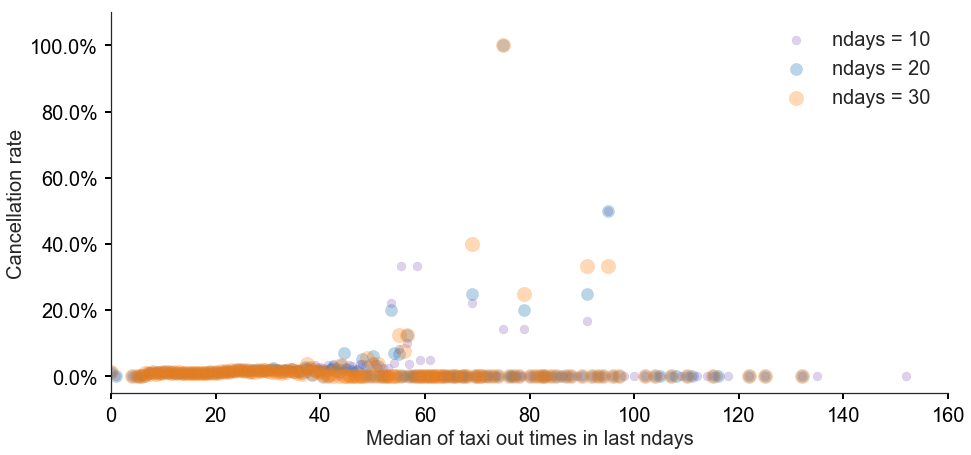

In [208]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, 
                       xlab="Median of taxi out times in last ndays", 
                       ylab="Cancellation rate", title="", xlim=[0,160], ylim=[-5,110])

We can zoom-in in abov plot to explore any possible pattern in some range of x values.

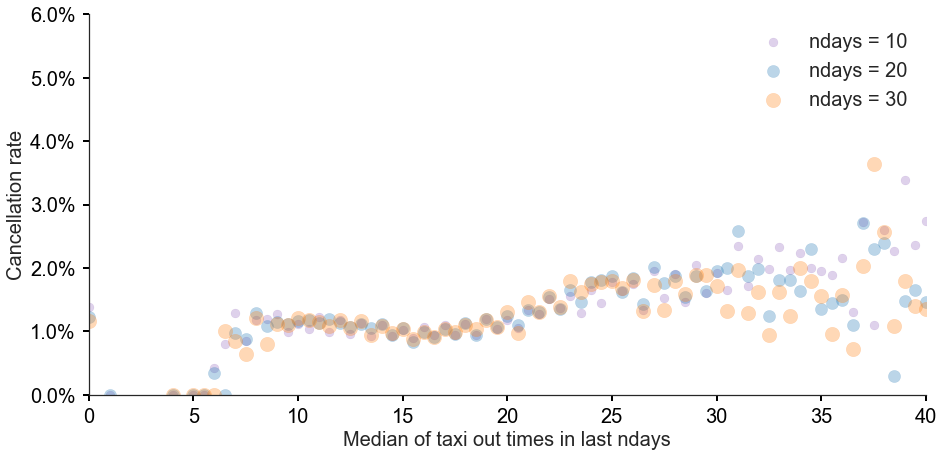

In [209]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, 
                       xlab="Median of taxi out times in last ndays", 
                       ylab="Cancellation rate", title="", xlim=[0,40], ylim=[0,6])

For x shorter than half an hour and longer than 5 mins, we see some monotonically increasing behaviour of cancellation rate as a function of median of taxi out times. Out of this bound, the pattern is non-monotonic. This range covers about 39-43% of the total data points.

In [211]:
print(len(dfd10[(dfd10.TaxiOutMedian_10 > 0) & (dfd10.TaxiOutMedian_10 < 40)])/len(dfd10))
print(len(dfd20[(dfd20.TaxiOutMedian_20 > 0) & (dfd20.TaxiOutMedian_20 < 40)])/len(dfd20))
print(len(dfd30[(dfd30.TaxiOutMedian_30 > 0) & (dfd30.TaxiOutMedian_30 < 40)])/len(dfd30))

0.391304347826087
0.4161849710982659
0.4329268292682927


#### TaxiInMedian_10, TaxiInMedian_20, TaxiInMedian_30

Taxi-in time is the time duration between the time when the plane touches down the ground (wheels on time) and the time when pilot applies parking brake at the arrival gate.

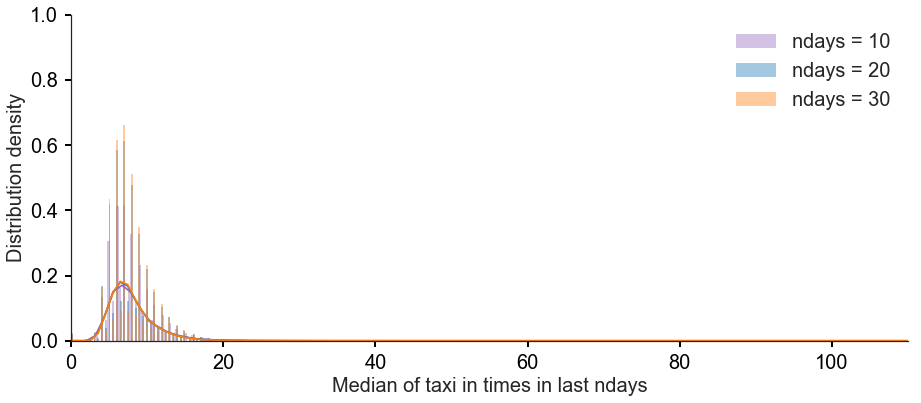

In [212]:
dist_plot_all_ndays(df, col="TaxiInMedian", width=15, height=6, 
                    xlab="Median of taxi in times in last ndays", 
                    ylab="Distribution density", title="", xlim=[0,110], ylim=[0,1])

In [213]:
dfd10 = create_canrate_by_contvar_df("TaxiInMedian_10", df)
dfd20 = create_canrate_by_contvar_df("TaxiInMedian_20", df)
dfd30 = create_canrate_by_contvar_df("TaxiInMedian_30", df)

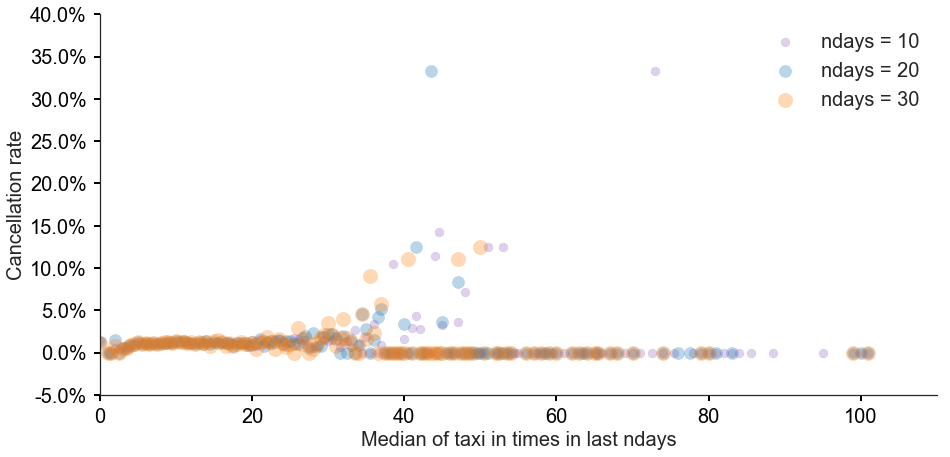

In [214]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, 
                       xlab="Median of taxi in times in last ndays", 
                       ylab="Cancellation rate", title="", xlim=[0,110], ylim=[-5,40])

We can zoom-in in abov plot to explore any possible pattern in some range of x values.

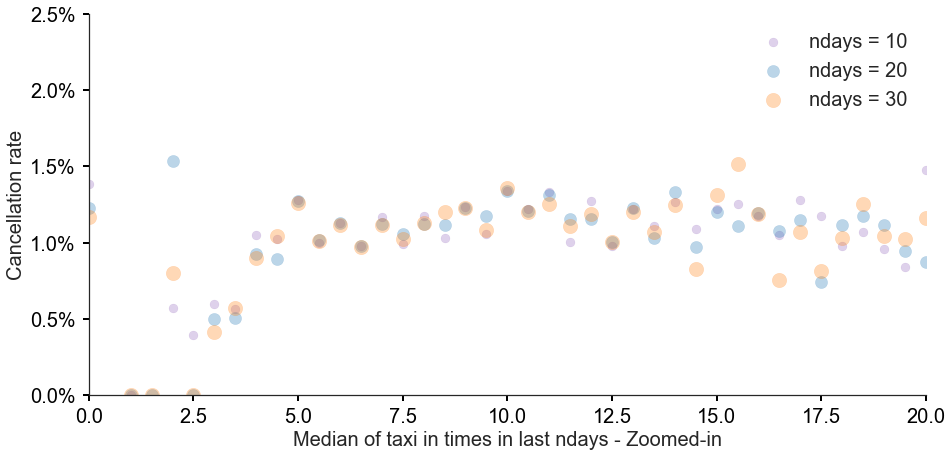

In [215]:
scatter_plot_all_ndays(dfd10, dfd20, dfd30, width=15, height=7, 
                       xlab="Median of taxi in times in last ndays - Zoomed-in", 
                       ylab="Cancellation rate", title="", xlim=[0,20], ylim=[0,2.5])

When we look at the range 0 - 20 mins, we oberve a similar pattern which we observed for taxi out time. This range covers about 24-30% of the total data points.

In [217]:
print(len(dfd10[(dfd10.TaxiInMedian_10 > 0) & (dfd10.TaxiInMedian_10 < 20)])/len(dfd10))
print(len(dfd20[(dfd20.TaxiInMedian_20 > 0) & (dfd20.TaxiInMedian_20 < 20)])/len(dfd20))
print(len(dfd30[(dfd30.TaxiInMedian_30 > 0) & (dfd30.TaxiInMedian_30 < 20)])/len(dfd30))

0.24503311258278146
0.2814814814814815
0.3089430894308943


We have looked at all the columns related with historical performances too. Lets now turn our attention to weather factors.


### Weather Factors

We have 8 weather related columns for both origin and destination locations:
Temperature, DewPoint, Humidity, WindSpeed, WindDirection, Visibility, Pressure and Condition. Lets start with Temperature.


#### Temperature ( $^\circ$F)

Though this is a continuous variable, and we could first bin it to visualize the influence of temperature in cancellation rate, but lets simply start by grouping our data frame by temperature and see if it gives any meaningful insight.

In [218]:
def dist_plot_weather_origin_dest(df, col, width, height, xlab, ylab, title, xlim, ylim):
    """ This function creates histograms for a given weather factor at both origin and destination airports
    
    Parameters
    ----------
    df (dtype: pd.DataFrame): The data frame
    col (dtype: str): The prefix of the weather factor column
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title of the plot
    xlim (dtype: list): The list of numbers to limit x-axis. Example: [2.5, 4]
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [0, 12.5]
    """
    sns.set(rc={"figure.figsize": (width, height)})
    sns.set_style("white")
    ax = sns.distplot(df[col+"_Origin"], norm_hist=False, kde = True, bins=500, label="Origin", color=tableau20[6])
    ax = sns.distplot(df[col+"_Dest"], norm_hist=False, kde = True, bins=500, label="Destination", color=tableau20[18])
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    plt.title(title, fontsize=24)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.legend(fontsize=20)
    ax.tick_params(direction='out', length=6, width=2, colors='k')
    hide_topright(ax)

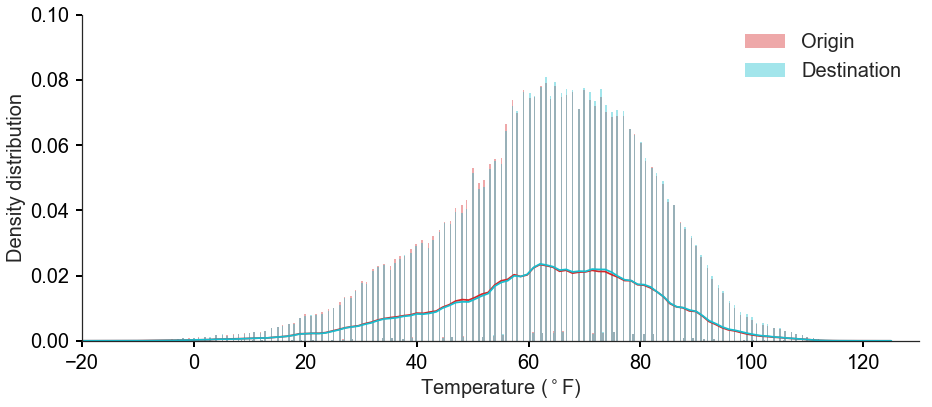

In [219]:
dist_plot_weather_origin_dest(df, col="Temperature", width=15, height=6, 
                              xlab="Temperature ($^\circ$F)", 
                              ylab="Density distribution", title="", 
                              xlim=[-20, 130], ylim=[0,0.1])

In [220]:
df.Temperature_Origin.describe()

count    2.857139e+06
mean     6.302340e+01
std      1.856471e+01
min     -2.000000e+01
25%      5.200000e+01
50%      6.400000e+01
75%      7.590000e+01
max      1.220000e+02
Name: Temperature_Origin, dtype: float64

In [221]:
df.Temperature_Dest.describe()

count    2.857139e+06
mean     6.342882e+01
std      1.851238e+01
min     -2.000000e+01
25%      5.200000e+01
50%      6.490000e+01
75%      7.700000e+01
max      1.220000e+02
Name: Temperature_Dest, dtype: float64

Distribution of temperatures at both origin and destination locations are very much normally distributed with mean around 63 $^\circ$F. Median values are bit higher because the distribution is slightly skewed on left. Lets now plot a scatter plot to see the influence of temeprature at both origin and destination locations on flight cancellation rate. For this, we will first group the data by Temeperature_Location (where Location can be Origin or Dest). For each value of temerature we will count the number of flights that got cancelled, and also the total number of flights. The ratio of these two numbers will give us the cancellation rate for chosen temperature and location.

In [222]:
dfdOrg = create_canrate_by_contvar_df("Temperature_Origin", df)
dfdDest = create_canrate_by_contvar_df("Temperature_Dest", df)

In [223]:
def scatter_plot_weather_origin_dest(dfdOrg, dfdDest, width, height, xlab, ylab, title, xlim, ylim):
    """ This function creates scatter plots for a given weather factor at both origin and destination airports
    
    Parameters
    ----------
    dfdOrg (dtype: pd.DataFrame): The small data frame containing information about origin airport
    dfdDest (dtype: pd.DataFrame): The small data frame containing information about destination airport
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title of the plot
    xlim (dtype: list): The list of numbers to limit x-axis. Example: [2.5, 4]
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [0, 12.5]
    """
    fig, ax = plt.subplots(figsize=(width,height))
    ax.scatter(dfdOrg.iloc[:,0], dfdOrg.iloc[:,1], color=tableau20[6], s=150, alpha=0.5, label="Origin")
    ax.scatter(dfdDest.iloc[:,0], dfdDest.iloc[:,1], color=tableau20[18], s=150, alpha=0.5, label="Destination")
    ax.set_xlabel(xlab, size=20)
    ax.set_ylabel(ylab, size=20)
    ax.set_title(title, size=24)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.tick_params(direction='out', length=6, width=2, colors='k')
    plt.xticks(size=20)
    plt.yticks(size=20)
    hide_topright(ax)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    plt.legend(fontsize=20, loc=2)

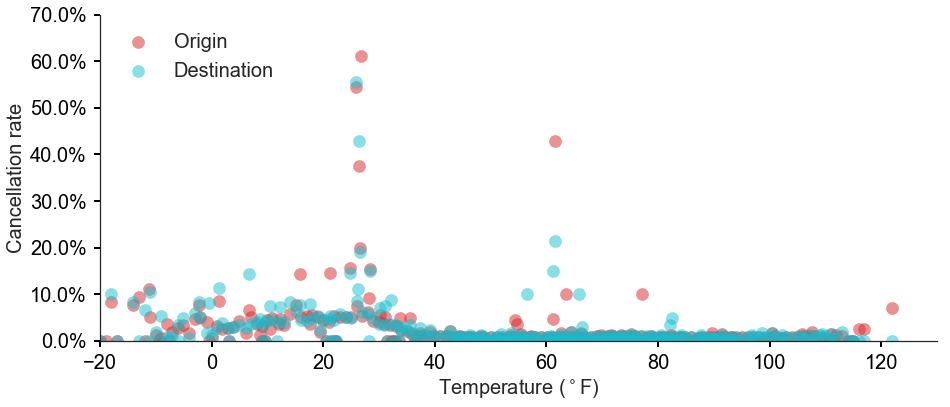

In [224]:
scatter_plot_weather_origin_dest(dfdOrg, dfdDest, width=15, height=6, 
                                 xlab="Temperature ($^\circ$F)", ylab="Cancellation rate", title="", 
                                 xlim=[-20, 130], ylim=[0,70])

Broadly, we can observe two regimes in the plot above, for less than and greater than 40 $^\circ$F. For less than 40 $^\circ$F, the cancellations occur more frequently as compared to the weather when the temepratures are greater than 40 $^\circ$F, at both origin and destination airports. There are two big spikes in cancellation rates, one for each broad regime. The higher cancellation rates in the first regime mostly correspond to bad weather in winter months. However, the data points in the first regime are not a significant fraction of the total data points as shown in the distribution plot above. It is only about 12% of the total data. 

In [226]:
sum(df.Temperature_Origin < 40)/len(df)

0.12424561773158393

In [227]:
sum(df.Temperature_Dest < 40)/len(df)

0.12065146287947488

40 $^\circ$F to 90 $^\circ$F represent a major fraction, around 81%.

In [228]:
sum((df.Temperature_Origin > 40)&(df.Temperature_Origin<90))/len(df)

0.81717375318456675

In [229]:
sum((df.Temperature_Dest > 40)&(df.Temperature_Dest<90))/len(df)

0.81764345381866266

In the range 40 $^\circ$F to 90 $^\circ$F, we can show the following scatter plot. 

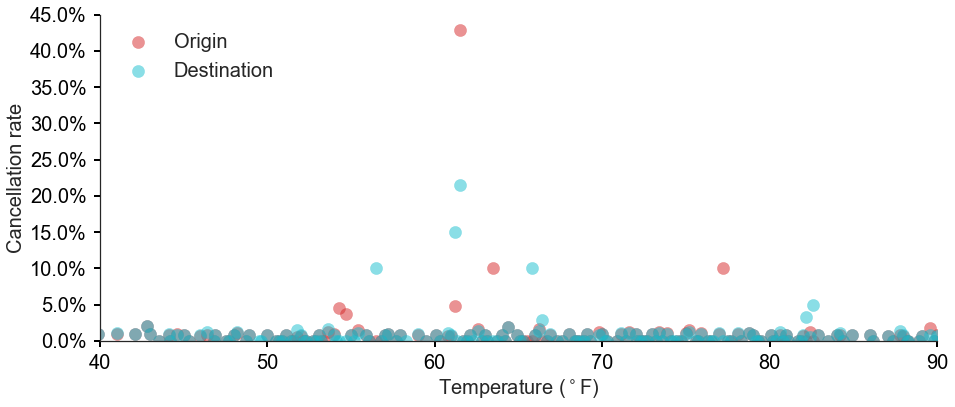

In [230]:
scatter_plot_weather_origin_dest(dfdOrg, dfdDest, width=15, height=6, 
                                 xlab="Temperature ($^\circ$F)", ylab="Cancellation rate", title="", 
                                 xlim=[40, 90], ylim=[0,45])

Except few spikes between 50 $^\circ$F to 70 $^\circ$F, the cancellation rate is almost independent from the temperatures. Therefore, only the two broad regimes and few big spikes stands out in terms of dependence on temprature. Finally lets compare the cancellation rates between the first and the second regime for both origin and destination airports.

In [231]:
def bar_plot_compare_regimes_origin_dest(df, col, thresh, width, height, xlab, ylab, title, ylim):
    """ This function creates bar chart to compare the cncellation rates for a fiven weather factor's two broad
    regime, both at origin and destination airports
    
    Parameters
    ----------
    df (dtype: pd.DataFrame): The data frame
    col (dtype: str): The prefix of the weather factor column
    thresh (dtype: float): The value of the threshold which divides between two broad regimes
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title of the plot
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [0, 12.5]
    """
    sns.set(rc={"figure.figsize": (width, height)})
    sns.set_style("white")
    dfr = pd.DataFrame(OrderedDict({"Origin":[100*sum(df.Cancelled[df[col+"_Origin"] < thresh])/sum(df[col+"_Origin"] < thresh),
                             100*sum(df.Cancelled[df[col+"_Origin"] >= thresh])/sum(df[col+"_Origin"] >= thresh)],
                   "Destination":[100*sum(df.Cancelled[df[col+"_Dest"] < thresh])/sum(df[col+"_Dest"] < thresh),
                                 100*sum(df.Cancelled[df[col+"_Dest"] >= thresh])/sum(df[col+"_Dest"] >= thresh)]}),
                  index=[col+" < "+str(thresh), col+" >= "+str(thresh)])
    ax = dfr.plot(kind="bar", colors=[tableau20[6], tableau20[18]], zorder=0)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    plt.title(title, fontsize=24)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylim(ylim)
    plt.legend(fontsize=20)
    ax.tick_params(direction='out', length=6, width=2, colors='k')
    plt.tick_params(axis='both', which='major', labelsize=20)
    ax.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0)
    hide_topright(ax)

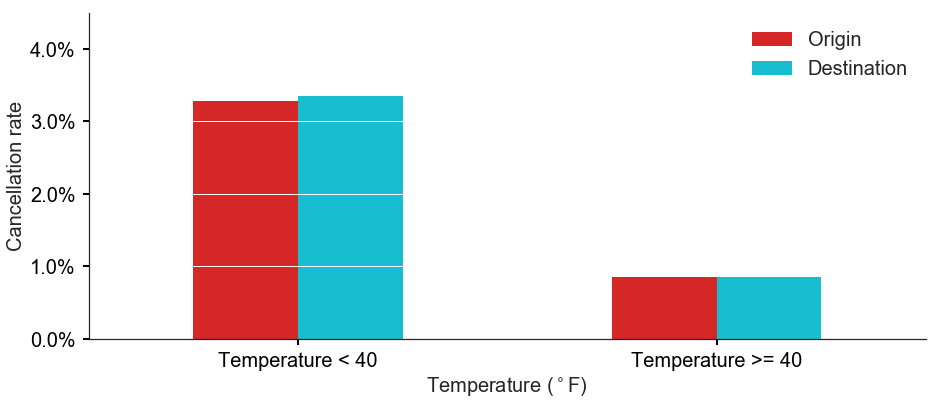

In [232]:
bar_plot_compare_regimes_origin_dest(df, col="Temperature", thresh=40, width=15, height=6, 
                                     xlab="Temperature ($^\circ$F)", ylab="Cancellation rate", title="", ylim=[0, 4.5])

By choosing a threshold value of 40 $^\circ$F, we get the above bar chart. Clearly, there is a significant difference in cancellation rates between the two temperature regimes.

#### DewPoint ( $^\circ$F)

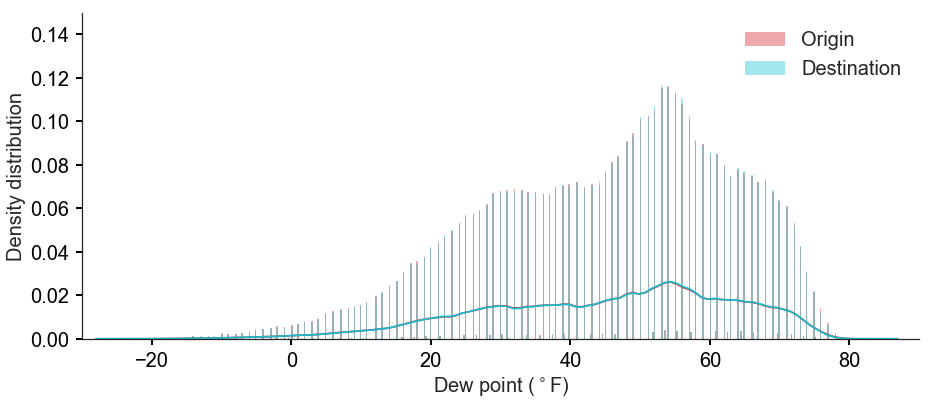

In [233]:
dist_plot_weather_origin_dest(df, col="DewPoint", width=15, height=6, 
                              xlab="Dew point ($^\circ$F)", 
                              ylab="Density distribution", title="", 
                              xlim=[-30, 90], ylim=[0,0.15])

In [234]:
df.DewPoint_Origin.describe()

count    2.857139e+06
mean     4.510002e+01
std      1.786933e+01
min     -2.510000e+01
25%      3.200000e+01
50%      4.800000e+01
75%      5.900000e+01
max      8.400000e+01
Name: DewPoint_Origin, dtype: float64

In [235]:
df.DewPoint_Dest.describe()

count    2.857139e+06
mean     4.513653e+01
std      1.784232e+01
min     -2.510000e+01
25%      3.200000e+01
50%      4.800000e+01
75%      5.900000e+01
max      8.400000e+01
Name: DewPoint_Dest, dtype: float64

In [236]:
dfdOrg = create_canrate_by_contvar_df("DewPoint_Origin", df)
dfdDest = create_canrate_by_contvar_df("DewPoint_Dest", df)

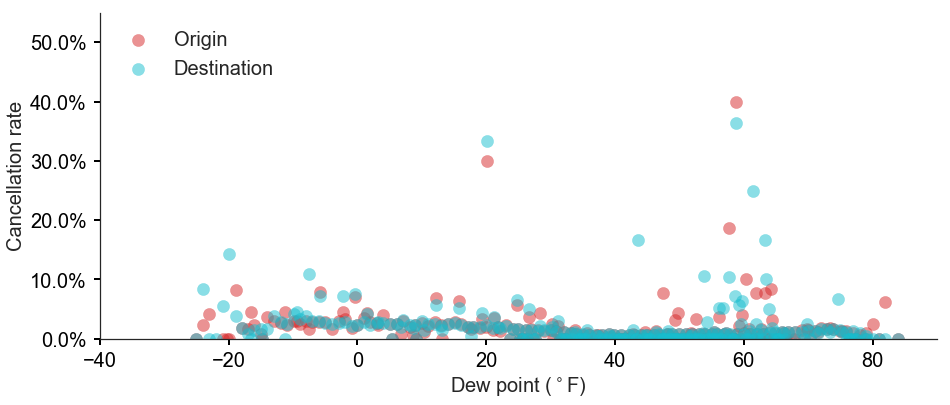

In [237]:
scatter_plot_weather_origin_dest(dfdOrg, dfdDest, width=15, height=6, 
                                 xlab="Dew point ($^\circ$F)", ylab="Cancellation rate", title="", 
                                 xlim=[-40, 90], ylim=[0,55])

For dew point, a threshold value of 30 $^\circ$F is point to divide between two regimes. Lets get the difference in cancellation rates between the two regimes.

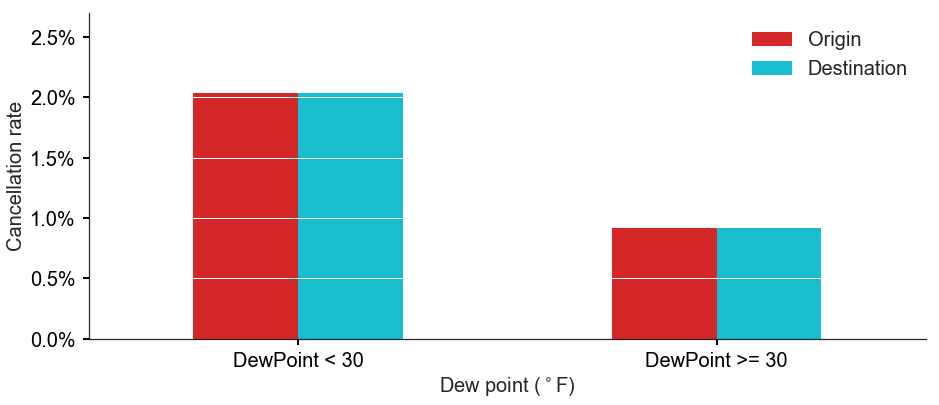

In [238]:
bar_plot_compare_regimes_origin_dest(df, col="DewPoint", thresh=30, width=15, height=6, 
                                     xlab="Dew point ($^\circ$F)", ylab="Cancellation rate", title="", ylim=[0, 2.7])

#### Humidity (%)

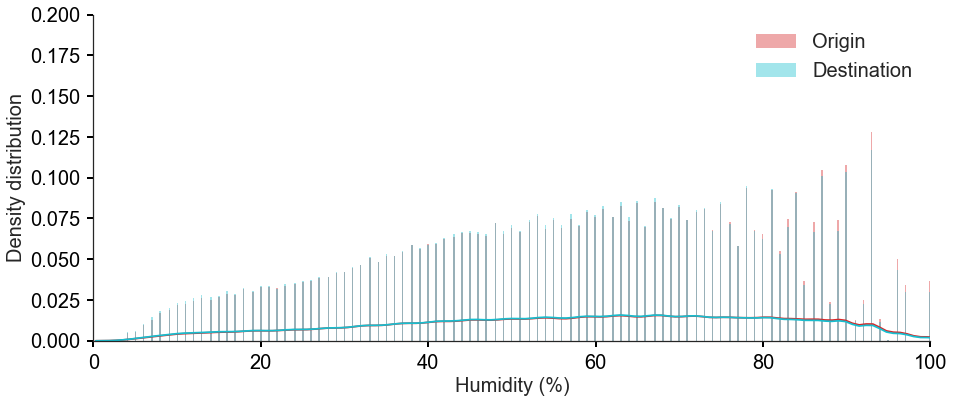

In [239]:
dist_plot_weather_origin_dest(df, col="Humidity", width=15, height=6, 
                              xlab="Humidity (%)", 
                              ylab="Density distribution", title="",  
                              xlim=[0, 100], ylim=[0,0.2])

In [240]:
df.Humidity_Origin.describe()

count    2.857139e+06
mean     5.809420e+01
std      2.294139e+01
min      4.000000e+00
25%      4.100000e+01
50%      6.000000e+01
75%      7.700000e+01
max      1.000000e+02
Name: Humidity_Origin, dtype: float64

In [241]:
df.Humidity_Dest.describe()

count    2.857139e+06
mean     5.745260e+01
std      2.283748e+01
min      4.000000e+00
25%      4.100000e+01
50%      5.900000e+01
75%      7.600000e+01
max      1.000000e+02
Name: Humidity_Dest, dtype: float64

In [242]:
dfdOrg = create_canrate_by_contvar_df("Humidity_Origin", df)
dfdDest = create_canrate_by_contvar_df("Humidity_Dest", df)

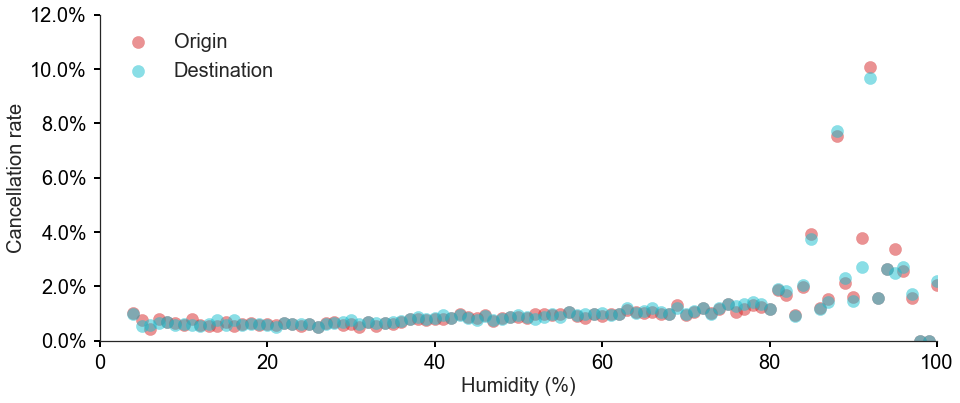

In [245]:
scatter_plot_weather_origin_dest(dfdOrg, dfdDest, width=15, height=6, 
                                 xlab="Humidity (%)", ylab="Cancellation rate", title="", 
                                 xlim=[0, 100], ylim=[0,12])

For very dry weather conditions (less than 10%), there is a decreasing trend for cancellation rate. The rate then monotonically increase for humidity more than 20%. Lets calculate the Spearman's $\rho$ to see the correlation and associated p-value.

In [246]:
stats.spearmanr(dfdOrg.iloc[:,0], dfdOrg.iloc[:,1])

SpearmanrResult(correlation=0.78920809623327859, pvalue=7.8799776412001232e-22)

In [247]:
stats.spearmanr(dfdDest.iloc[:,0], dfdDest.iloc[:,1])

SpearmanrResult(correlation=0.81783484718924726, pvalue=1.5776733911061149e-24)

The correlations are not weak and are statistically significant.

#### WindSpeed (mph)

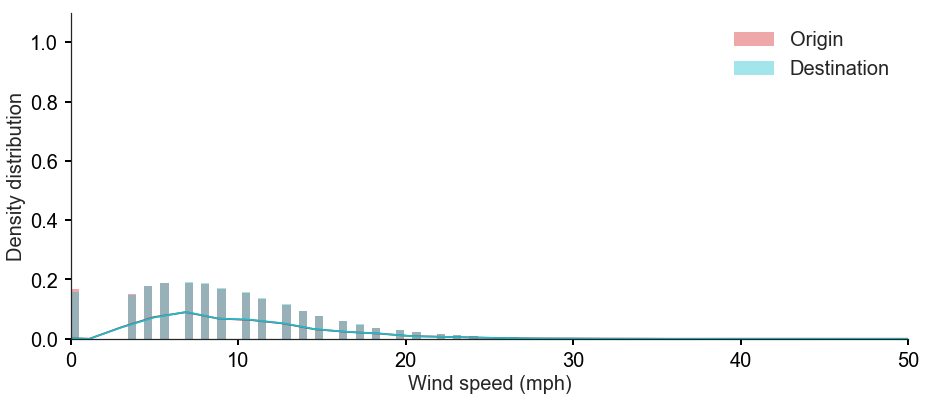

In [248]:
dist_plot_weather_origin_dest(df, col="WindSpeed", width=15, height=6, 
                              xlab="Wind speed (mph)", 
                              ylab="Density distribution", title="", 
                              xlim=[0, 50], ylim=[0,1.1])

Is there any influence of wind speed on flight cancellation rates?

In [249]:
dfdOrg = create_canrate_by_contvar_df("WindSpeed_Origin", df)
dfdDest = create_canrate_by_contvar_df("WindSpeed_Dest", df)

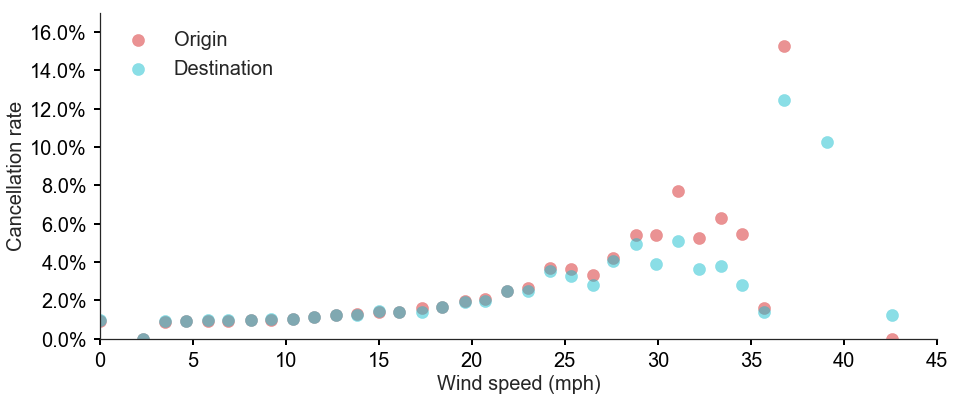

In [251]:
scatter_plot_weather_origin_dest(dfdOrg, dfdDest, width=15, height=6, 
                                 xlab="Wind speed (mph)", ylab="Cancellation rate", title="",
                                 xlim=[0, 45], ylim=[0,17])

For both origin and destination airports, we see a monotonically increasing trend for cancellation rates untill around 25 mph. For wind speed greater than that, the cancellation rates start to decrease. The maximum point for cancellation rates are different for origin and destination airports. Overall, the trends are pretty much like parabolic curves.

#### WindDirection

This is measured in degrees (0 or 360 - North, 270 - West, 90 - East, 180 - South)

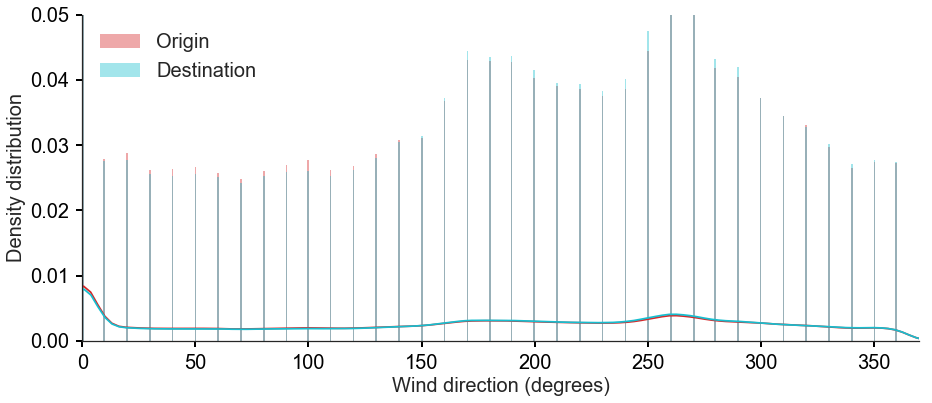

In [253]:
dist_plot_weather_origin_dest(df, col="WindDirection", width=15, height=6, 
                              xlab="Wind direction (degrees)", 
                              ylab="Density distribution", title="",
                              xlim=[0, 370], ylim=[0,0.05])

In [254]:
df.WindDirection_Origin.describe()

count    2.857139e+06
mean     1.718411e+02
std      1.114201e+02
min      0.000000e+00
25%      7.000000e+01
50%      1.800000e+02
75%      2.700000e+02
max      3.600000e+02
Name: WindDirection_Origin, dtype: float64

In [255]:
df.WindDirection_Dest.describe()

count    2.857139e+06
mean     1.749797e+02
std      1.105411e+02
min      0.000000e+00
25%      8.000000e+01
50%      1.900000e+02
75%      2.700000e+02
max      3.600000e+02
Name: WindDirection_Dest, dtype: float64

In [256]:
dfdOrg = create_canrate_by_contvar_df("WindDirection_Origin", df)
dfdDest = create_canrate_by_contvar_df("WindDirection_Dest", df)

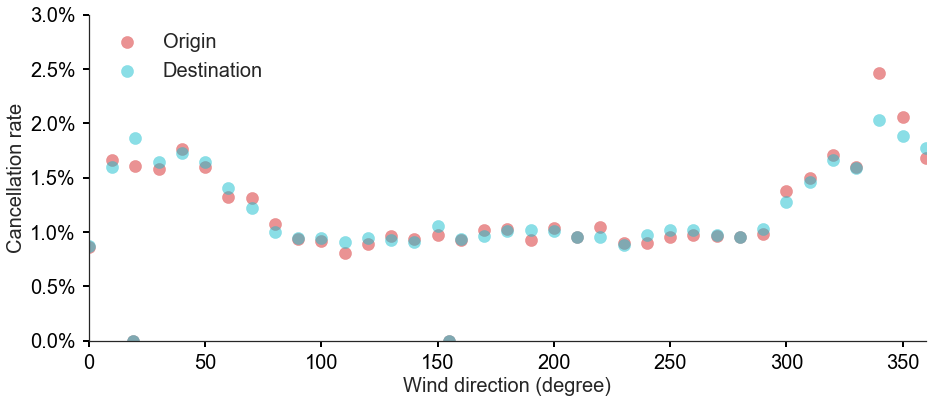

In [257]:
scatter_plot_weather_origin_dest(dfdOrg, dfdDest, width=15, height=6, 
                                 xlab="Wind direction (degree)", ylab="Cancellation rate", title="",
                                 xlim=[0, 360], ylim=[0,3])

In [258]:
def scatter_plot_weather_origin_dest_polar(dfdOrg, dfdDest, width, height, xlab, ylab, xlim, ylim):
    """ This function creates polar plots to show cancellation rates at various values of wind direction
    at both origin and destination airports
    
    Parameters
    ----------
    dfdOrg (dtype: pd.DataFrame): The small data frame containing information about origin airport
    dfdDest (dtype: pd.DataFrame): The small data frame containing information about destination airport
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title of the plot
    xlim (dtype: list): The list of numbers to limit x-axis. Example: [2.5, 4]
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [0, 12.5]
    """
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(width,height))
    
    plt.suptitle('Wind direction affects flight cancellation rates', size=26, y=1.08)
    
    ax1 = plt.subplot(1, 2, 1, projection='polar')
    ax1.set_theta_zero_location("N")
    ax1.set_theta_direction(-1)
    ax1.fill_between([np.pi*x/180 for x in dfdOrg.iloc[:,0]], dfdOrg.iloc[:,1], 0, 
                    color=tableau20[6], zorder=0)
    ax1.set_rticks([1, 2, 3])  # less radial ticks
    ax1.set_rlabel_position(120)  # get radial labels away from plotted line
    ax1.set_xlabel(xlab, size=20)
    ax1.set_ylabel(ylab, size=20)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.tick_params(direction='out', length=6, width=2, colors='k')
    plt.xticks(size=20)
    plt.yticks(size=20)
    #hide_topright(ax)
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    ax1.grid(True, which='major', axis='y', color="k", linewidth=1, zorder=1, linestyle='--')
    ax1.set_title("Origin", size=24, y=1.08)
    
    ax2 = plt.subplot(1,2,2, projection='polar')
    ax2.set_theta_zero_location("N")
    ax2.set_theta_direction(-1)
    ax2.fill_between([np.pi*x/180 for x in dfdDest.iloc[:,0]], dfdDest.iloc[:,1], 0, 
                    color=tableau20[18], zorder=0)
    ax2.set_rticks([1, 2, 3])  # less radial ticks
    ax2.set_rlabel_position(120)  # get radial labels away from plotted line
    ax2.set_xlabel(xlab, size=20)
    ax2.set_ylabel(ylab, size=20)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.tick_params(direction='out', length=6, width=2, colors='k')
    plt.xticks(size=20)
    plt.yticks(size=20)
    #hide_topright(ax)
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    ax2.grid(True, which='major', axis='y', color="k", linewidth=1, zorder=1, linestyle='--')
    ax2.set_title("Destination", size=24, y=1.08)

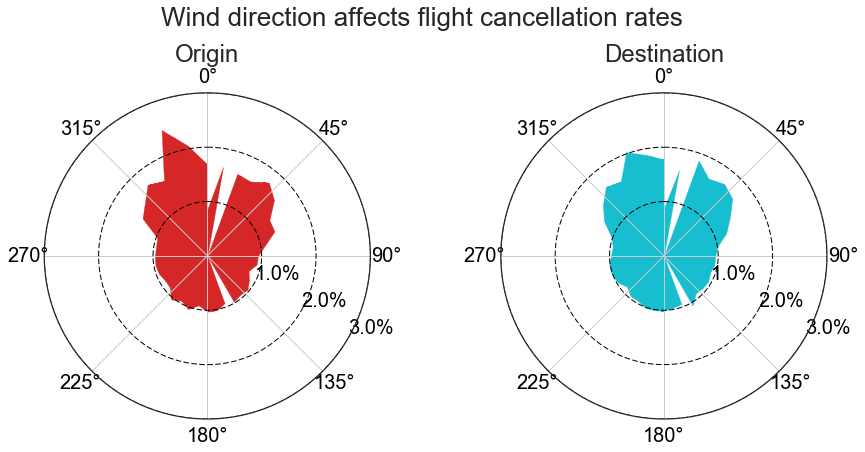

In [259]:
scatter_plot_weather_origin_dest_polar(dfdOrg, dfdDest, width=15, height=6, 
                                 xlab="", ylab="", 
                                 xlim=[0, 360], ylim=[0,3])

There appears to be a cyclic trend here. From 90 to 270 degrees,i.e. from east to south to west, the cancellation rate is around 1%. When the wind direction goes from west to close to north, the cancellation rates increased. The rates fluctuate a lot when the wind direction is close to north. From north to east wind direction, the cancellation rate start to decrease.

Why do we have more cancellations when the wind direction is few degrees around north ($\sim$ 290 - 50 degrees)? Is the temperature too low when the wind direction is northwards? It may sound strange but thats what we see below. 

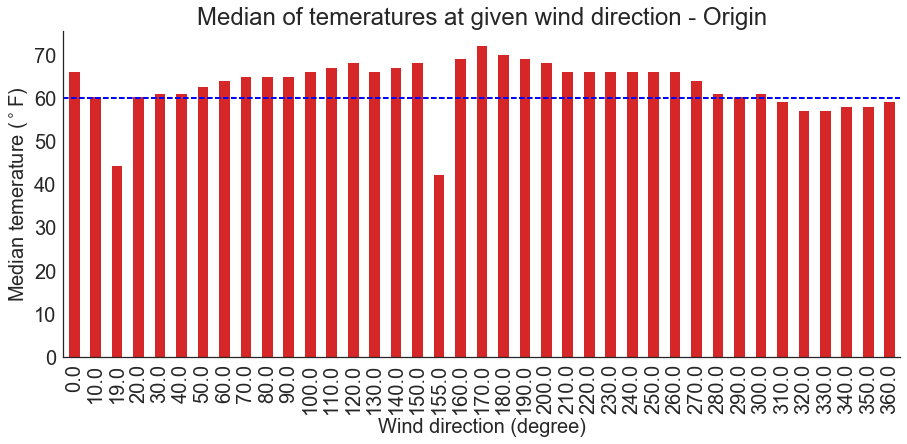

In [260]:
ax = df.groupby("WindDirection_Origin")["Temperature_Origin"].median().plot(kind="bar", color=tableau20[6])
plt.xlabel("Wind direction (degree)", fontsize=20)
plt.ylabel("Median temerature ($^\circ$F)", fontsize=20)
plt.title("Median of temeratures at given wind direction - Origin", fontsize=24)
plt.xticks(size=20)
plt.yticks(size=20)
hide_topright(ax)
plt.axhline(y=60, color="blue", linestyle='--', linewidth=2)

The dashed horizontal blue line indicates a median temerature of 60 $^\circ$F. Above 60 $^\circ$F, the wind direction is roughly between 50 to 290 which is where we see small cancellation rates. Usually, below the blue line, we have wid direction close to north, where we see high cancellation rates. So, it is quite possible that whenever the wind direction is northwards, the median temperature is low.

Do we see the same trend for destination airport wind direction? 

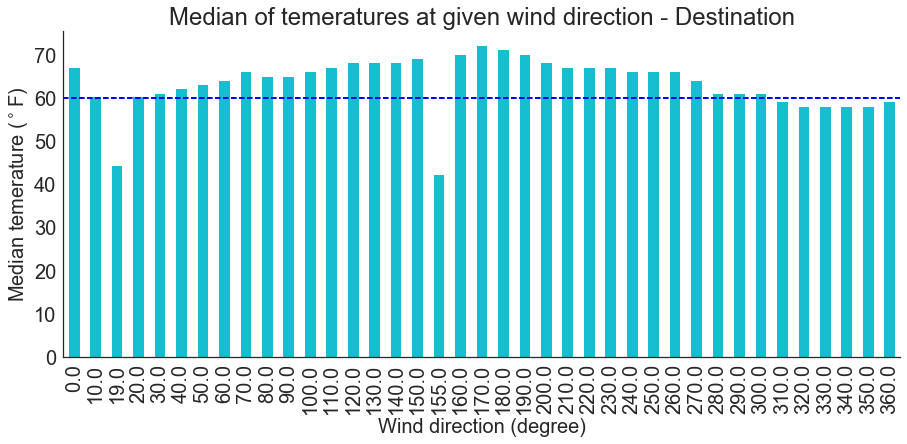

In [261]:
ax = df.groupby("WindDirection_Dest")["Temperature_Dest"].median().plot(kind="bar", color=tableau20[18])
plt.xlabel("Wind direction (degree)", fontsize=20)
plt.ylabel("Median temerature ($^\circ$F)", fontsize=20)
plt.title("Median of temeratures at given wind direction - Destination", fontsize=24)
plt.xticks(size=20)
plt.yticks(size=20)
hide_topright(ax)
plt.axhline(y=60, color="blue", linestyle='--', linewidth=2)

#### Visibility (miles)

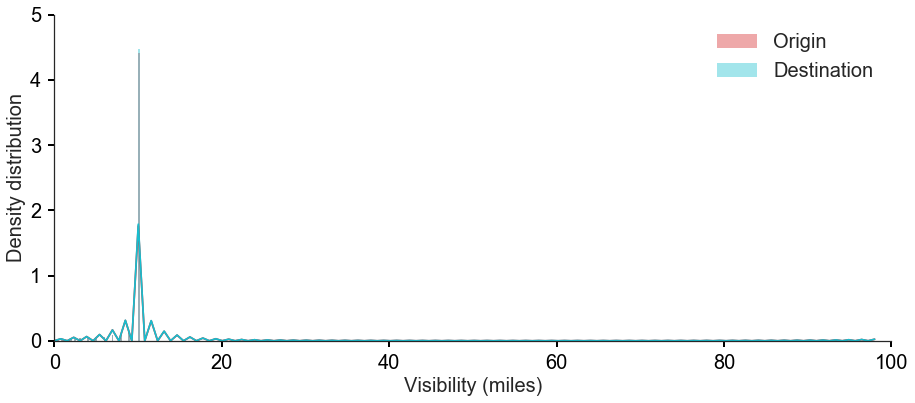

In [262]:
dist_plot_weather_origin_dest(df, col="Visibility", width=15, height=6, 
                              xlab="Visibility (miles)", 
                              ylab="Density distribution", title="", 
                              xlim=[0, 100], ylim=[0,5])

In [263]:
df.Visibility_Origin.describe()

count    2.857139e+06
mean     9.405828e+00
std      1.847539e+00
min      0.000000e+00
25%      1.000000e+01
50%      1.000000e+01
75%      1.000000e+01
max      9.800000e+01
Name: Visibility_Origin, dtype: float64

In [264]:
df.Visibility_Dest.describe()

count    2.857139e+06
mean     9.471054e+00
std      1.735762e+00
min      0.000000e+00
25%      1.000000e+01
50%      1.000000e+01
75%      1.000000e+01
max      9.800000e+01
Name: Visibility_Dest, dtype: float64

In [265]:
dfdOrg = create_canrate_by_contvar_df("Visibility_Origin", df)
dfdDest = create_canrate_by_contvar_df("Visibility_Dest", df)

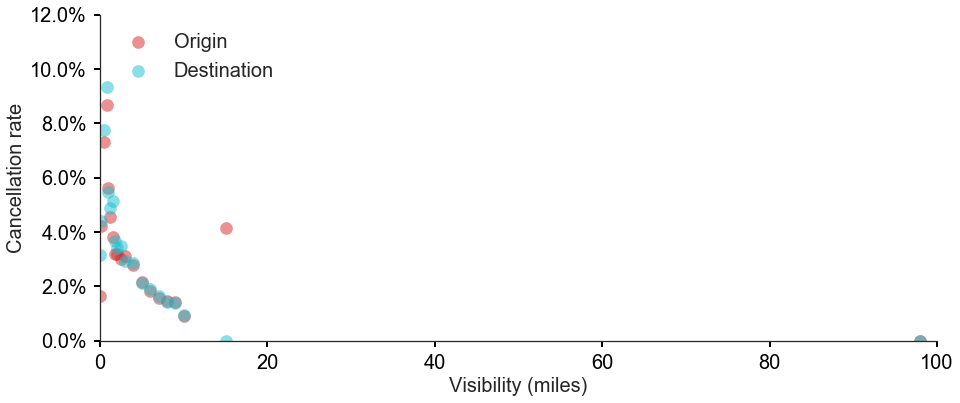

In [266]:
scatter_plot_weather_origin_dest(dfdOrg, dfdDest, width=15, height=6, 
                                 xlab="Visibility (miles)", ylab="Cancellation rate", title="", 
                                 xlim=[0, 100], ylim=[0,12])

There is only one data point which has too large value (98 miles). Lets zoom-in in the above plot by ignoring that isolated point.

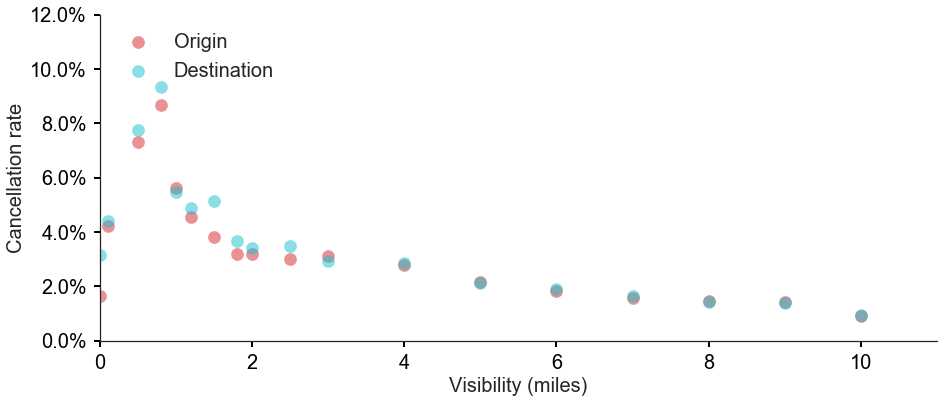

In [267]:
scatter_plot_weather_origin_dest(dfdOrg, dfdDest, width=15, height=6, 
                                 xlab="Visibility (miles)", ylab="Cancellation rate", title="", 
                                 xlim=[0, 11], ylim=[0,12])

We observe non-linear non-monotonic trend for smaller values of visibility. For visibility greater than a mile, there is a clear decreasing trend for cancellation rate.

#### Pressure (inHg)

In [268]:
df.Pressure_Origin.describe()

count    2.857139e+06
mean     3.001187e+01
std      1.992916e-01
min      2.899000e+01
25%      2.989000e+01
50%      3.000000e+01
75%      3.013000e+01
max      3.100000e+01
Name: Pressure_Origin, dtype: float64

In [269]:
df.Pressure_Dest.describe()

count    2.857139e+06
mean     3.000819e+01
std      1.987062e-01
min      2.899000e+01
25%      2.988000e+01
50%      3.000000e+01
75%      3.013000e+01
max      3.100000e+01
Name: Pressure_Dest, dtype: float64

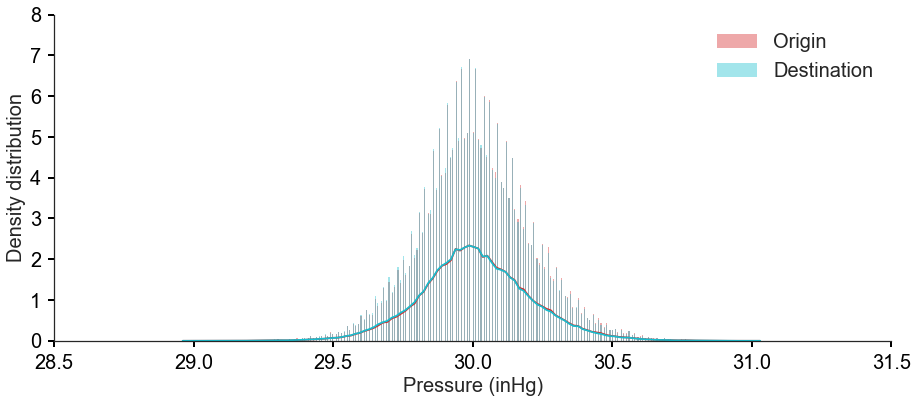

In [270]:
dist_plot_weather_origin_dest(df, col="Pressure", width=15, height=6, 
                              xlab="Pressure (inHg)", 
                              ylab="Density distribution", title="", 
                              xlim=[28.5, 31.5], ylim=[0,8])

In [271]:
dfdOrg = create_canrate_by_contvar_df("Pressure_Origin", df)
dfdDest = create_canrate_by_contvar_df("Pressure_Dest", df)

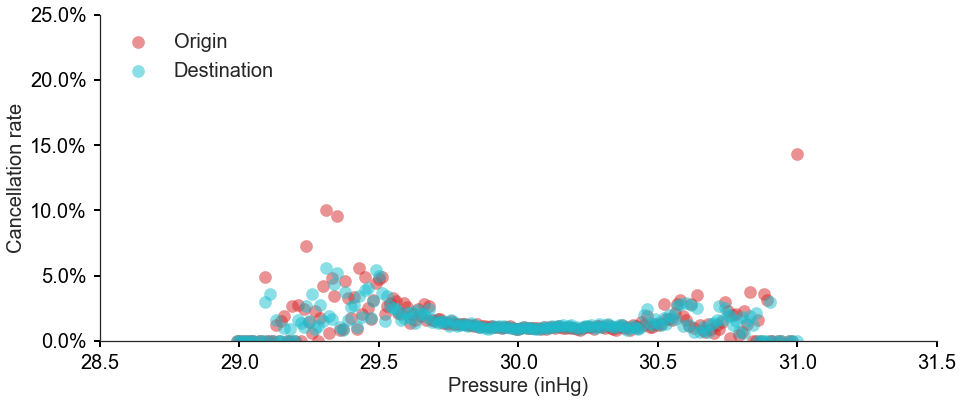

In [272]:
scatter_plot_weather_origin_dest(dfdOrg, dfdDest, width=15, height=6, 
                                 xlab="Pressure (inHg)", ylab="Cancellation rate", title="",
                                 xlim=[28.5, 31.5], ylim=[0,25])

#### Condition

We have already covered this column early in this notebook.

# Conclusions:

In [273]:
df.shape

(2857139, 92)

We have explored all the columns in the 2015 dataset to see if they influence the cancellation rates. There were columns related with flight on-performance, calander variables, weather factors and also some historical peroformance data for each flight. We have found that most of the variables affect cancellation rates. Some trends were linear and some trends were non-linear. There were some cyclic trends too. At this stage, we do not know the predictive power of all variables. Therefore, we pick a list of columns to keep for the machine learning model. This list contains almost all the columns that we explored. We are excluding some columns that contain coarse-grained information for a variables of which we already have fine-grained column. For example, we will exclude the column "Quarter" and "State" since we know "Month" and "Origin" or "Dest", respectively. We will also exclude columns that are redundant. For example, there is no point in keeping "FlightDate" but we will keep "Month", "DayofMonth" etc. We will also exclude columns that make no sense to keep for modeling. For example, DepDelay information is obtained once the flight has departed, but we have no means of knowing this information before, say 2 days.

Following is a list of columns that we will carry for the modeling:

1. Month (need to be one-hot encoded)

2. DayofMonth (need to be one-hot encoded)

3. DayOfWeek (need to be one-hot encoded)

4. Carrier (need to be one-hot encoded)

5. Origin (need to be one-hot encoded)

6. Dest (need to be one-hot encoded)

7. Cancelled (TARGET)

8. Distance

9. Nflights_10

10. DepDelayMedian_10

11. DepDelayMax_10

12. ArrDelayMedian_10

13. ArrDelayMax_10

14. TaxiOutMedian_10

15. TaxiInMedian_10

16. Ncan_10

17. Ndiv_10

18. Nflights_20

19. DepDelayMedian_20

20. DepDelayMax_20

21. ArrDelayMedian_20

22. ArrDelayMax_20

23. TaxiOutMedian_20

24. TaxiInMedian_20

25. Ncan_20

26. Ndiv_20

27. Nflights_30

28. DepDelayMedian_30

29. DepDelayMax_30

30. ArrDelayMedian_30

31. ArrDelayMax_30

32. TaxiOutMedian_30

33. TaxiInMedian_30

34. Ncan_30

35. Ndiv_30

36. CRSDepHr (need to be one-hot encoded)

37. CRSArrHr (need to be one-hot encoded)

38. Temperature_Origin

39. DewPoint_Origin

40. Humidity_Origin,

41. WindSpeed_Origin

42. WindDirection_Origin

43. Visibility_Origin

44. Pressure_Origin

45. Condition_Origin (need to be one-hot encoded)

46. Temperature_Dest

47. DewPoint_Dest

48. Humidity_Dest

49. WindSpeed_Dest

50. WindDirection_Dest

51. Visibility_Dest

52. Pressure_Dest

53. Condition_Dest (need to be one-hot encoded)

54. Month_Dest (need to be one-hot encoded)

55. DayOfMonth_Dest (need to be one-hot encoded)

56. DayOfWeek_Dest (need to be one-hot encoded)

57. TempFlight_30

58. TempFlight_20

59. TempFlight_10

60. AllCanceled_30

61. AllDiverted_30

62. AllCanceled_20

63. AllDiverted_20

64. AllCanDiv_20

65. AllCanceled_10

66. AllDiverted_10

67. AllCanDiv_30

68. AllCanDiv_10

Lets now drop the unwanted columns from the data frame and save the resultant data frame to a csv, which can be loaded for machine leanring modeling.

In [274]:
dfFinal = df.drop(['Year', 'Quarter', 'OriginCityName', 'OriginState', 'OriginWac', 'DestCityName', 'DestState', 
                   'DestWac', 'CRSDepTime', 'DepTimeBlk', 'CRSArrTime', 'ArrTimeBlk', 'Diverted', 'DistanceGroup', 
                   'DivAirportLandings', 'Year_Dest', 'Quarter_Dest', 'FlightDateTime', 'FlightDateTimeAtDest', 
                   'Canceled_A', 'Canceled_B', 'Canceled_C', 'Canceled_D', 'AirlineType'], axis=1)

In [275]:
dfFinal.shape

(2857139, 68)

In [315]:
dfFinal.to_csv("../Data/ExploredDataCleaned/FlightHistory_Weather_Jan2015-Dec2016_Top20Airports_Window60mins_ExploredCleaned.csv")

### Plots for report 

In [277]:
def plot_canrate_by_catvar_org_dst(df, catvar, xlab, ylab, yticks, xlab_angle, sort, title, fsize, width, height, 
                                   legend, legend_loc, outputfile):
    """ This function plots the bar chart for cancellation rates for all classes present in 
    two categorical variables (at origin and at destination) of the same type
    
    Parameters
    ----------
    df (dtype: pd.DataFrame) : The data frame containing the categorical variable and the "Cancelled" column
    catvar (dtype: list): The list of names (in string format) of categorical variables which are to be plotted
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    yticks (dtype: list): The list of ticks that we want on y-axis
    xlab_angle (dtpye: int): The angle for x axis lable names
    sort (dtype: boolean): True if you want to sort the data by values in Origin
    title (dtype: str): The title for the plot
    fsize (dtype: int): The font size of labels in axis and legend
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    legend (dtype: boolean): True if you want legend
    legend_loc (dtype: int): Legend location
    outputfile (dtype: str): The name of the output figure file, including the directory
    """
    fig = plt.figure()
    rcParams['figure.figsize'] = width, height
    
    Org = 100*df.groupby(catvar[0])["Cancelled"].sum() / df.groupby(catvar[0])["Cancelled"].count()
    Dst = 100*df.groupby(catvar[1])["Cancelled"].sum() / df.groupby(catvar[1])["Cancelled"].count()
    
    if sort:
        ax = pd.DataFrame(OrderedDict({"Origin": Org, "Destination": Dst})).sort_values("Origin", ascending=False).plot(kind="bar", 
                                                                        color=[tableau20[6],tableau20[18]], zorder=0) 
    else:
        ax = pd.DataFrame(OrderedDict({"Origin": Org, "Destination": Dst})).plot(kind="bar", 
                                                                        color=[tableau20[6],tableau20[18]], zorder=0)
    plt.xlabel(xlab, fontsize=fsize)
    plt.ylabel(ylab, fontsize=fsize)
    plt.xticks(fontsize=fsize)
    plt.yticks(yticks, fontsize=fsize)
    plt.title(title, fontsize=fsize)
    if legend:
        plt.legend(fontsize=fsize, loc=legend_loc)
    else:
        ax.legend_.remove()
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    hide_topright(ax)
    ax.tick_params(direction='out', length=6, width=2, colors='k')
    ax.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=xlab_angle)
    plt.tight_layout()
    savefig(outputfile)

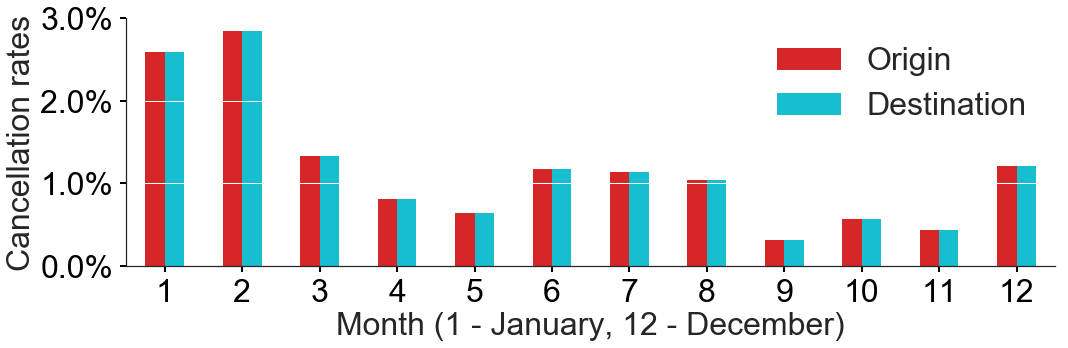

In [279]:
plot_canrate_by_catvar_org_dst(df, catvar=["Month", "Month_Dest"], xlab="Month (1 - January, 12 - December)", 
                       ylab="Cancellation rates", yticks=[0, 1, 2, 3], xlab_angle = 0, sort = False, 
                       title="", fsize=32, width=15, height=5,
                      legend = True, legend_loc=0, outputfile="MilestoneReport/monthly_canrate.pdf")

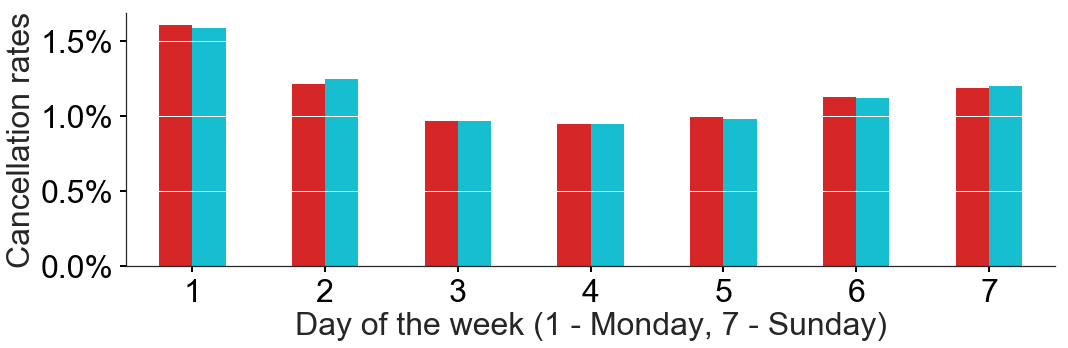

In [281]:
plot_canrate_by_catvar_org_dst(df, catvar=["DayOfWeek", "DayOfWeek_Dest"], xlab="Day of the week (1 - Monday, 7 - Sunday)", 
                       ylab="Cancellation rates", yticks=[0, 0.5, 1, 1.5], xlab_angle = 0, sort = False, 
                       title="", fsize=32, width=15, height=5,
                      legend=False, legend_loc=0, outputfile="MilestoneReport/weekly_canrate.pdf")

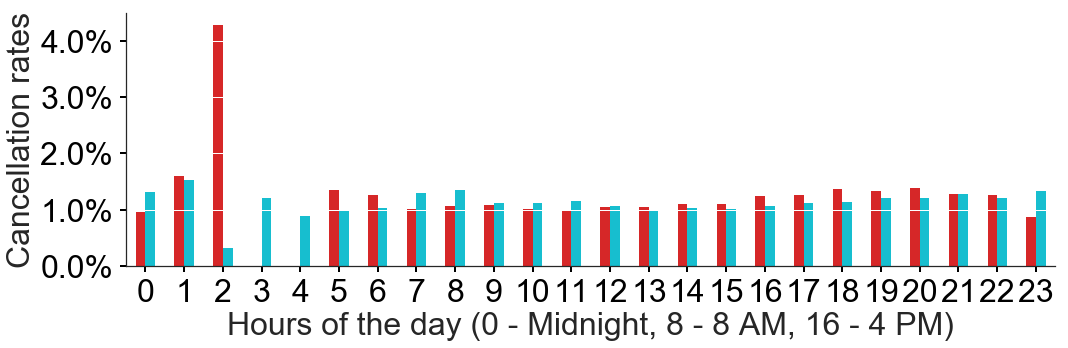

In [284]:
plot_canrate_by_catvar_org_dst(df, catvar=["CRSDepHr", "CRSArrHr"], xlab="Hours of the day (0 - Midnight, 8 - 8 AM, 16 - 4 PM)", 
                       ylab="Cancellation rates", yticks=[0, 1, 2, 3, 4], xlab_angle=0, sort = False, 
                       title="", fsize=32, width=15, height=5,
                      legend=False, legend_loc=0, outputfile="MilestoneReport/hourly_canrate.pdf")

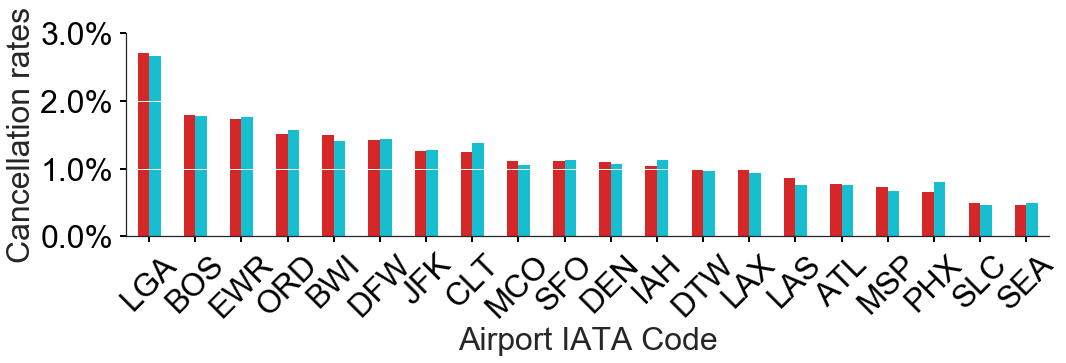

In [286]:
plot_canrate_by_catvar_org_dst(df, catvar=["Origin", "Dest"], xlab="Airport IATA Code", 
                       ylab="Cancellation rates", yticks=[0, 1, 2, 3], xlab_angle=45, sort = True, 
                       title="", fsize=32, width=15, height=5,
                      legend=False, legend_loc=0, outputfile="MilestoneReport/airport_canrate.pdf")

In [287]:
def plot_canrate_by_cat2(df, by, xlab, ylab, title, sort, width, height, tbl, ylim, outputfile):
    """ This function plots the bar chart for cancellation rates for all classes present in a 
    categorical variable. This function is very much similar to plot_canrate_by_cat1() with added file saving.
    
    Parameters
    ----------
    df (dtype: pd.DataFrame) : The data frame containing the categorical variable and the "Cancelled" column
    by (dtype: str): The name (in string format) of the categorical variable which is to be plotted
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title for the plot
    sort: (dtype: boolean): True: if you want to sort the data and then plot, False: otherwise
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    tbl (dtype: int): An integer number from 0 to 19, to pick colors from tableau20
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [2.5, 4]
    outputfile (dtype: str): The name of the output figure file, including the directory
    """
    fig, ax = plt.subplots(1, 1, figsize=(width, height))
    can_rate = (100*df.groupby(by)["Cancelled"].sum() / df.groupby(by)["Cancelled"].count())
    
    can_rate_sorted = can_rate.sort_values(ascending=False)
    
    colors = [tableau20[tbl]]
    
    if sort:
        ax = can_rate_sorted.plot(kind='bar',color=colors, zorder=0)
    else:
        ax = can_rate.plot(kind='bar',color=colors, zorder=0)
    plt.xlabel(xlab, fontsize=32)
    plt.ylabel(ylab, fontsize=32)
    plt.title(title, size=34)
    plt.ylim(ylim)
    hide_topright(ax)
    plt.tick_params(axis='both', which='major', labelsize=32)
    plt.yticks([0,2,4,6,8])
    ax.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0)
    plt.tight_layout()
    savefig(outputfile)

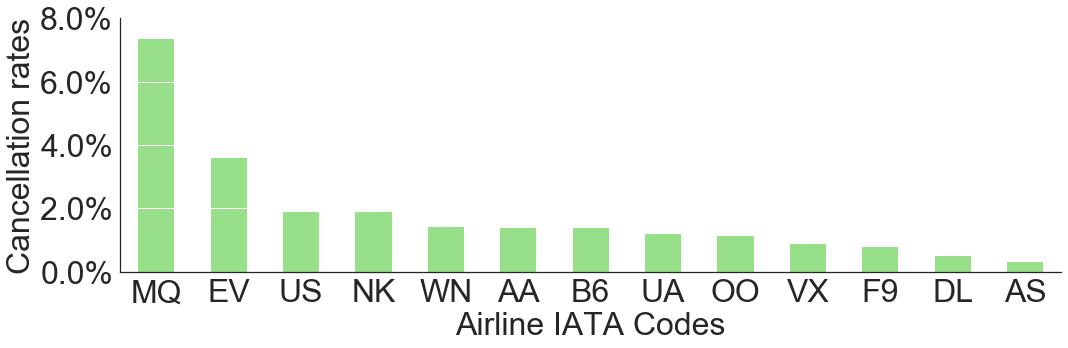

In [288]:
plot_canrate_by_cat2(df, "Carrier", "Airline IATA Codes", "Cancellation rates", "", sort=True, width=15, 
                     height=5, tbl=5, ylim=[0, 8], outputfile="MilestoneReport/airline_canrate.pdf");

In [289]:
def plot_canrate_by_contvar_inset(dft, xlab, ylab, title, xlim, ylim, xlog, tbl, width, height, outputfile):
    """ This function plots the scatter plot for cancellation rates as a function of a given continuous vaiable. This function 
    not only requires the name of the continuous variable but also a small data frame containing the continuous
    variable and cancellation rate. This small data frame is obtained using the function create_canrate_by_contvar_df().
    
    Parameters
    ----------
    dft (dtype: pd.DataFrame): a small data frame obtained by running create_canrate_by_contvar_df()
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title of the plot
    xlim (dtype: list): The list of numbers to limit x-axis. Example: [2.5, 4]
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [0, 12.5]
    xlog (dtype: boolean): True: if you want log scale on x-axis, False: linear scale
    tbl (dtype: int): An integer number from 0 to 19, to pick colors from tableau20
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    outputfile (dtype: str): The name of the output figure file, including the directory
    """
    fig, ax1 = plt.subplots(figsize=(width,height))
    #sns.set_style("whitegrid", {'axes.grid' : False})
    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.5, 0.45, 0.4, 0.4]
    ax2 = fig.add_axes([left, bottom, width, height])
    
    ax1.scatter(dft.iloc[:,0], dft.iloc[:,1], color=tableau20[tbl], s=80, alpha=0.8)
    ax1.set_xlabel(xlab, size=32)
    ax1.set_ylabel(ylab, size=32)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.tick_params(direction='out', length=6, width=2, colors='k', labelsize=32)
    if xlog:
        ax1.set_xscale('log')
    else:
        pass
    hide_topright(ax1)
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])

    ax2.scatter(dft.iloc[:,0], dft.iloc[:,1], color=tableau20[tbl], s=80, alpha=0.8)
    ax2.set_xlabel("", size=28)
    ax2.set_ylabel("", size=28)
    ax2.set_title("Inset", size=30)
    ax2.set_xlim([100, 2800])
    ax2.set_ylim([0, 7])
    ax2.set_yticks([0,2,4,6])
    ax2.tick_params(direction='out', length=6, width=2, colors='k', labelsize=28)
    if xlog:
        ax2.set_xscale('log')
    else:
        pass
    #hide_topright(ax2)
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    plt.tight_layout()
    savefig(outputfile)

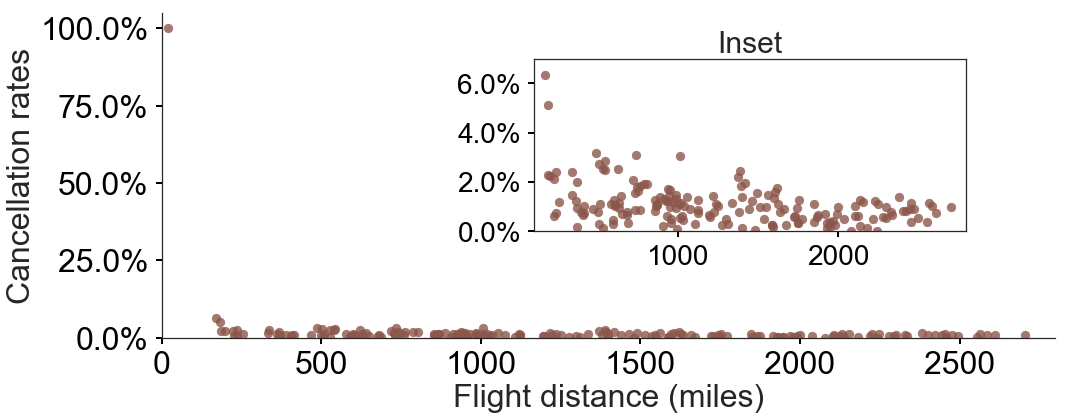

In [290]:
plot_canrate_by_contvar_inset(dft=create_canrate_by_contvar_df("Distance", df), 
                              xlab="Flight distance (miles)", ylab="Cancellation rates", title="", 
                              xlim=[0,2800], ylim=[0,105], xlog=False, tbl=10, 
                              width=15, height=6, outputfile="MilestoneReport/distance_canrate.pdf")

In [291]:
def scatter_plot_weather_origin_dest_inset(dfdOrg, dfdDest, col, thresh, width, height, xlab, 
                                           ylab, title, xlim, ylim, outputfile):
    """ This function creates scatter plots for a given weather factor at both origin and destination airports, 
    with an inset figure
    
    Parameters
    ----------
    dfdOrg (dtype: pd.DataFrame): The small data frame containing information about origin airport
    dfdDest (dtype: pd.DataFrame): The small data frame containing information about destination airport
    col (dtype: str): Column name
    thresh (dtype: float): Threshhold value
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title of the plot
    xlim (dtype: list): The list of numbers to limit x-axis. Example: [2.5, 4]
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [0, 12.5]
    outputfile (dtype: str): The name of the output figure file, including the directory
    """
    fig, ax1 = plt.subplots(figsize=(width,height))
    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.7, 0.65, 0.2, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])

    #fig, ax = plt.subplots(figsize=(width,height))
    ax1.scatter(dfdOrg.iloc[:,0], dfdOrg.iloc[:,1], color=tableau20[6], s=150, alpha=0.5, label="Origin")
    ax1.scatter(dfdDest.iloc[:,0], dfdDest.iloc[:,1], color=tableau20[18], s=150, alpha=0.5, label="Destination")
    ax1.set_xlabel(xlab, size=32)
    ax1.set_ylabel(ylab, size=32)
    ax1.set_title(title, size=34)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.tick_params(direction='out', length=6, width=2, colors='k')
    ax1.tick_params(direction='out', length=6, width=2, colors='k', labelsize=32)
    hide_topright(ax1)
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:3.0f}%'.format(y) for y in vals])
    ax1.legend(fontsize=26, loc=2)
    
    
    #sns.set(rc={"figure.figsize": (width, height)})
    #sns.set_style("white")
    dfr = pd.DataFrame(OrderedDict({"Origin":[100*sum(df.Cancelled[df[col+"_Origin"] < thresh])/sum(df[col+"_Origin"] < thresh),
                             100*sum(df.Cancelled[df[col+"_Origin"] >= thresh])/sum(df[col+"_Origin"] >= thresh)],
                   "Destination":[100*sum(df.Cancelled[df[col+"_Dest"] < thresh])/sum(df[col+"_Dest"] < thresh),
                                 100*sum(df.Cancelled[df[col+"_Dest"] >= thresh])/sum(df[col+"_Dest"] >= thresh)]}),
                  index=["T < "+str(thresh), "T >= "+str(thresh)])
                  #index=[col+" < "+str(thresh), col+" >= "+str(thresh)])
    dfr.plot(kind="bar", colors=[tableau20[6], tableau20[18]], zorder=0, ax=ax2)
    #ax2.set_xlabel(xlab, size=32)
    #ax2.set_ylabel(ylab, size=32)
    ax2.set_title("Inset", size=32)
    #ax2.set_xlim(xlim)
    #ax2.set_ylim(ylim)
    ax2.set_yticks([0,2,4])
    ax2.tick_params(direction='out', length=6, width=2, colors='k', labelsize=26)
    ax2.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:3.0f}%'.format(y) for y in vals])
    plt.setp( ax2.xaxis.get_majorticklabels(), rotation=0)
    ax2.legend_.remove()
    plt.tight_layout()
    savefig(outputfile)

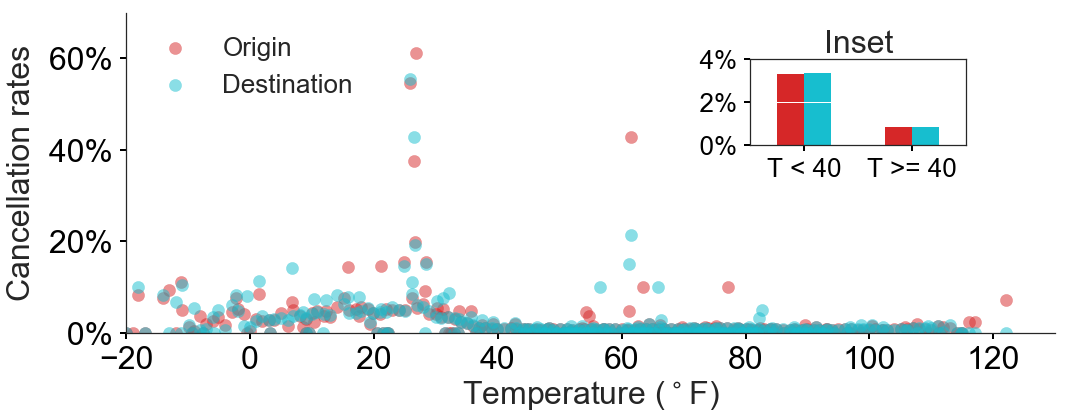

In [292]:
scatter_plot_weather_origin_dest_inset(dfdOrg=create_canrate_by_contvar_df("Temperature_Origin", df), 
                                       dfdDest=create_canrate_by_contvar_df("Temperature_Dest", df), 
                                       col="Temperature", thresh=40, width=15, height=6, 
                                 xlab="Temperature ($^\circ$F)", ylab="Cancellation rates", title="", 
                                 xlim=[-20, 130], ylim=[0,70], outputfile="MilestoneReport/temperature_canrate.pdf")

In [293]:
def scatter_plot_weather_origin_dest2(width, height, outputfile):
    """ This function creates scatter plots for a given weather factor at both origin and destination airports
    
    Parameters
    ----------
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    outputfile (dtype: str): The name of the output figure file, including the directory
    """
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(width,height))
    
    ax1 = plt.subplot(1, 2, 1)
    dfdOrg=create_canrate_by_contvar_df("Humidity_Origin", df)
    dfdDest=create_canrate_by_contvar_df("Humidity_Dest", df)
    ax1.scatter(dfdOrg.iloc[:,0], dfdOrg.iloc[:,1], color=tableau20[6], s=150, alpha=0.5, label="Origin")
    ax1.scatter(dfdDest.iloc[:,0], dfdDest.iloc[:,1], color=tableau20[18], s=150, alpha=0.5, label="Destination")
    ax1.set_xlabel("Humidity (%)", size=32)
    ax1.set_ylabel("Cancellation rates", size=32)
    ax1.set_xlim([0,105])
    ax1.set_ylim([0,12])
    ax1.tick_params(direction='out', length=6, width=2, colors='k', labelsize=32)
    ax1.set_yticks([0,4,8,12])
    hide_topright(ax1)
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:3.0f}%'.format(y) for y in vals])
    ax1.legend(fontsize=26, loc=2)
    
    ax2 = plt.subplot(1, 2, 2)
    dfdOrg=create_canrate_by_contvar_df("WindSpeed_Origin", df)
    dfdDest=create_canrate_by_contvar_df("WindSpeed_Dest", df)
    ax2.scatter(dfdOrg.iloc[:,0], dfdOrg.iloc[:,1], color=tableau20[6], s=150, alpha=0.5, label="Origin")
    ax2.scatter(dfdDest.iloc[:,0], dfdDest.iloc[:,1], color=tableau20[18], s=150, alpha=0.5, label="Destination")
    ax2.set_xlabel("Wind speed (mph)", size=32)
    ax2.set_ylabel("Cancellation rates", size=32)
    ax2.set_xlim([0,42])
    ax2.set_ylim([0,16])
    ax2.tick_params(direction='out', length=6, width=2, colors='k', labelsize=32)
    ax2.set_yticks([0,4,8,12, 16])
    hide_topright(ax2)
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:3.0f}%'.format(y) for y in vals])
    ax2.legend(fontsize=26, loc=2)

    plt.tight_layout()
    savefig(outputfile)

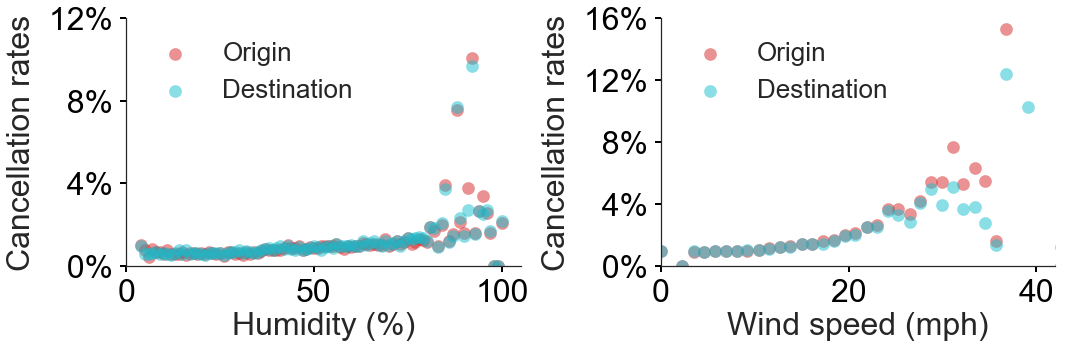

In [294]:
scatter_plot_weather_origin_dest2(width=15, height=5, outputfile="MilestoneReport/humidity_windspeed_canrate.pdf")

In [295]:
def scatter_plot_weather_origin_dest_polar1(dfdOrg, dfdDest, width, height, xlab, ylab, xlim, ylim, outputfile):
    """ This function creates polar plots to show cancellation rates at various values of wind direction
    at both origin and destination airports
    
    Parameters
    ----------
    dfdOrg (dtype: pd.DataFrame): The small data frame containing information about origin airport
    dfdDest (dtype: pd.DataFrame): The small data frame containing information about destination airport
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    xlim (dtype: list): The list of numbers to limit x-axis. Example: [2.5, 4]
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [0, 12.5]
    outputfile (dtype: str): The name of the output figure file, including the directory
    """
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(width,height))
    
    ax1 = plt.subplot(1, 2, 1, projection='polar')
    ax1.set_theta_zero_location("N")
    ax1.set_theta_direction(-1)
    ax1.fill_between([np.pi*x/180 for x in dfdOrg.iloc[:,0]], dfdOrg.iloc[:,1], 0, 
                    color=tableau20[6], zorder=0)
    ax1.set_rticks([1, 2, 3])  # less radial ticks
    ax1.set_rlabel_position(120)  # get radial labels away from plotted line
    ax1.set_xlabel(xlab, size=32)
    ax1.set_ylabel(ylab, size=32)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.tick_params(direction='out', length=6, width=2, colors='k', labelsize=32)
    #hide_topright(ax)
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:3.0f}%'.format(y) for y in vals])
    ax1.grid(True, which='major', axis='y', color="k", linewidth=1, zorder=1, linestyle='--')
    ax1.set_title("Origin", size=32, y=1.08)
    
    ax2 = plt.subplot(1,2,2, projection='polar')
    ax2.set_theta_zero_location("N")
    ax2.set_theta_direction(-1)
    ax2.fill_between([np.pi*x/180 for x in dfdDest.iloc[:,0]], dfdDest.iloc[:,1], 0, 
                    color=tableau20[18], zorder=0)
    ax2.set_rticks([1, 2, 3])  # less radial ticks
    ax2.set_rlabel_position(120)  # get radial labels away from plotted line
    ax2.set_xlabel(xlab, size=32)
    ax2.set_ylabel(ylab, size=32)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.tick_params(direction='out', length=6, width=2, colors='k', labelsize=32)
    #hide_topright(ax)
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:3.0f}%'.format(y) for y in vals])
    ax2.grid(True, which='major', axis='y', color="k", linewidth=1, zorder=1, linestyle='--')
    ax2.set_title("Destination", size=32, y=1.08)
    plt.tight_layout()
    savefig(outputfile)

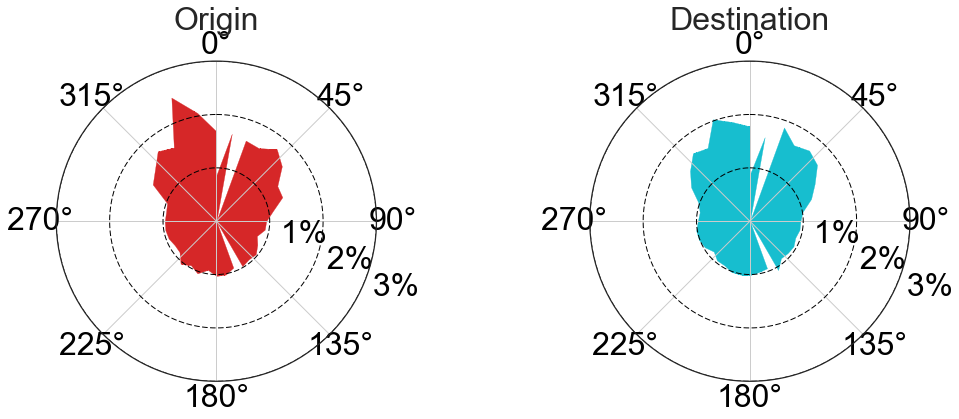

In [296]:
scatter_plot_weather_origin_dest_polar1(dfdOrg=create_canrate_by_contvar_df("WindDirection_Origin", df), 
                                        dfdDest=create_canrate_by_contvar_df("WindDirection_Dest", df), 
                                        width=15, height=6, xlab="", ylab="", xlim=[0, 360], ylim=[0,3],
                                       outputfile="MilestoneReport/winddir_canrate.pdf")

In [297]:
def plot_canrate_by_weather_conditions(df, xlab, ylab, sort, width, height, xlim, vertline, fsize):
    """ This function plots the bar chart in horizontal fashion for cancellation rates for all classes present in 
    weather condition. This function is very much similar to plot_canrate_by_temp_cat() with added features.
    
    Parameters
    ----------
    df (dtype: pd.DataFrame) : The data frame containing the categorical variable and the "Cancelled" column
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    sort: (dtype: boolean): True: if you want to sort the data and then plot, False: otherwise
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    xlim (dtype: list): The list of numbers to limit x-axis. Example: [0, 12.5]
    vertline (dtype: boolean): True: if you want to draw a vertical line at value = 10 (this number can be changed)
    fsize (dtype: int): Font size
    """
    fig = plt.figure()
    rcParams['figure.figsize'] = width, height
    
    Org = (100*df.groupby("Condition_Origin")["Cancelled"].sum() / df.groupby("Condition_Origin")["Cancelled"].count())
    Dst = (100*df.groupby("Condition_Dest")["Cancelled"].sum() / df.groupby("Condition_Dest")["Cancelled"].count())
    
    if sort:
        ax = pd.DataFrame(OrderedDict({"Origin": Org, "Destination": Dst})).sort_values("Origin", ascending=True).plot(kind="barh", 
                                                                        color=[tableau20[6],tableau20[18]], zorder=0) 
    else:
        ax = pd.DataFrame(OrderedDict({"Origin": Org, "Destination": Dst})).plot(kind="barh", 
                                                                        color=[tableau20[6],tableau20[18]], zorder=0)
    plt.xlabel(xlab, fontsize=fsize)
    plt.ylabel(ylab, fontsize=fsize)
    plt.xticks(fontsize=fsize)
    plt.yticks(fontsize=fsize)
    plt.legend(fontsize=fsize, loc=0)
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:3.0f}%'.format(x) for x in vals])
    hide_topright(ax)
    ax.tick_params(direction='out', length=6, width=2, colors='k')
    ax.grid(True, which='major', axis='x', color="white", linewidth=2, zorder=1)
    #plt.setp( ax.xaxis.get_majorticklabels(), rotation=xlab_angle)
    if vertline:
        ax.axvline(x=10, color="blue", linestyle='--', linewidth=1)
    else:
        pass
    
    plt.tight_layout()
    savefig("MilestoneReport/conditions_canrate.pdf")

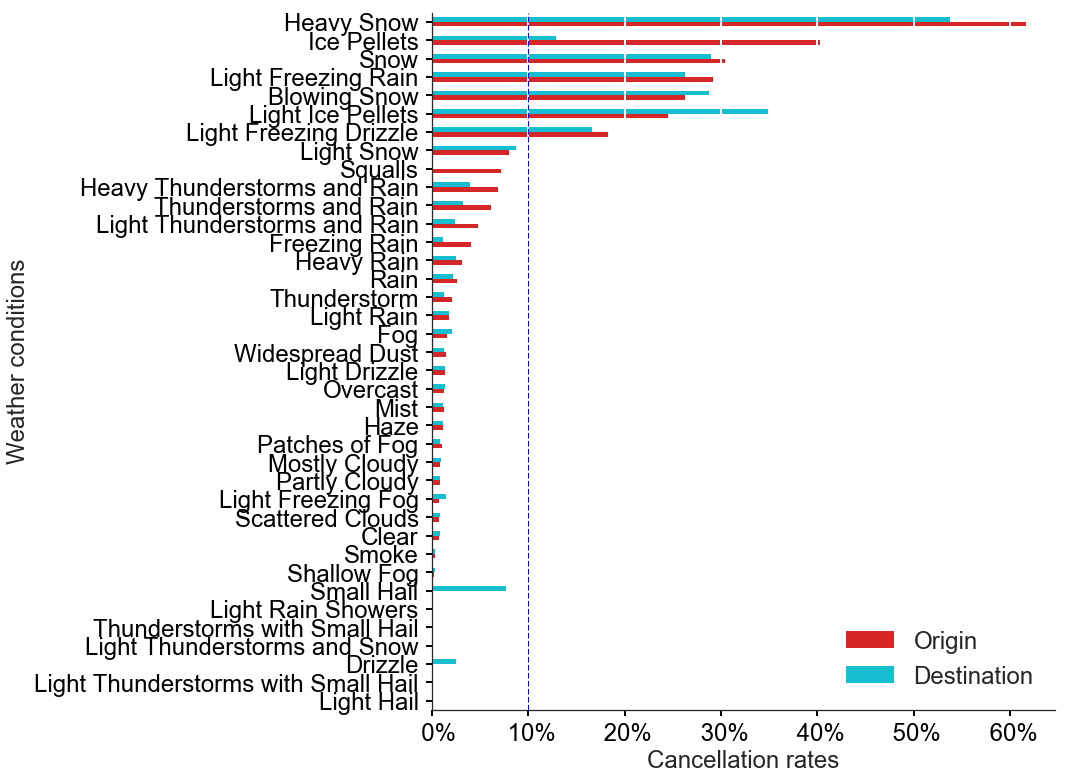

In [299]:
plot_canrate_by_weather_conditions(df, xlab="Cancellation rates", ylab="Weather conditions", sort=True, width=15, height=11, xlim=[0,70], vertline=True, fsize=24)

In [304]:
def scatter_plot_all_ndays1(df, width, height, fsize):
    """ This function plots the scatter plot for cancellation rates as a function of number of cancellations and 
    diversions in the last ndays.
    
    Parameters
    ----------
    df (dtype: pd.DataFrame): Original data frame
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    fsize (dtype: int): Font size
    """
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(width,height))
    ax1 = plt.subplot(1, 2, 1)
    dfd10 = create_canrate_by_contvar_df("Ncan_10", df)
    dfd20 = create_canrate_by_contvar_df("Ncan_20", df)
    dfd30 = create_canrate_by_contvar_df("Ncan_30", df)
    ax1.scatter(dfd10.iloc[:,0], dfd10.iloc[:,1], color=tableau20[16], s=120, alpha=0.6, label="ndays = 10")
    ax1.scatter(dfd20.iloc[:,0], dfd20.iloc[:,1], color=tableau20[0], s=190, alpha=0.6, label="ndays = 20")
    ax1.scatter(dfd30.iloc[:,0], dfd30.iloc[:,1], color=tableau20[2], s=280, alpha=0.6, label="ndays = 30")
    ax1.set_xlabel("Number of cancellations in last ndays", size=fsize)
    ax1.set_ylabel("Cancellation rates", size=fsize)
    ax1.set_xlim([0,30])
    ax1.set_ylim([0, 60])
    ax1.tick_params(direction='out', length=6, width=2, colors='k', labelsize=fsize)
    hide_topright(ax1)
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:3.0f}%'.format(y) for y in vals])
    ax1.legend(fontsize=fsize, loc=2)
    
    
    ax2 = plt.subplot(1, 2, 2)
    dfd10 = create_canrate_by_contvar_df("Ndiv_10", df)
    dfd20 = create_canrate_by_contvar_df("Ndiv_20", df)
    dfd30 = create_canrate_by_contvar_df("Ndiv_30", df)
    ax2.scatter(dfd10.iloc[:,0], dfd10.iloc[:,1], color=tableau20[16], s=120, alpha=0.6, label="ndays = 10")
    ax2.scatter(dfd20.iloc[:,0], dfd20.iloc[:,1], color=tableau20[0], s=190, alpha=0.6, label="ndays = 20")
    ax2.scatter(dfd30.iloc[:,0], dfd30.iloc[:,1], color=tableau20[2], s=280, alpha=0.6, label="ndays = 30")

    ax2.set_xlabel("Number of diversions in last ndays", size=fsize)
    ax2.set_ylabel("Cancellation rates", size=fsize)
    ax2.set_xlim([0,20])
    ax2.set_ylim([0, 9])
    ax2.tick_params(direction='out', length=6, width=2, colors='k', labelsize=fsize)
    hide_topright(ax2)
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:3.0f}%'.format(y) for y in vals])
    
    plt.tight_layout()
    savefig("MilestoneReport/candiv_canrate.pdf")

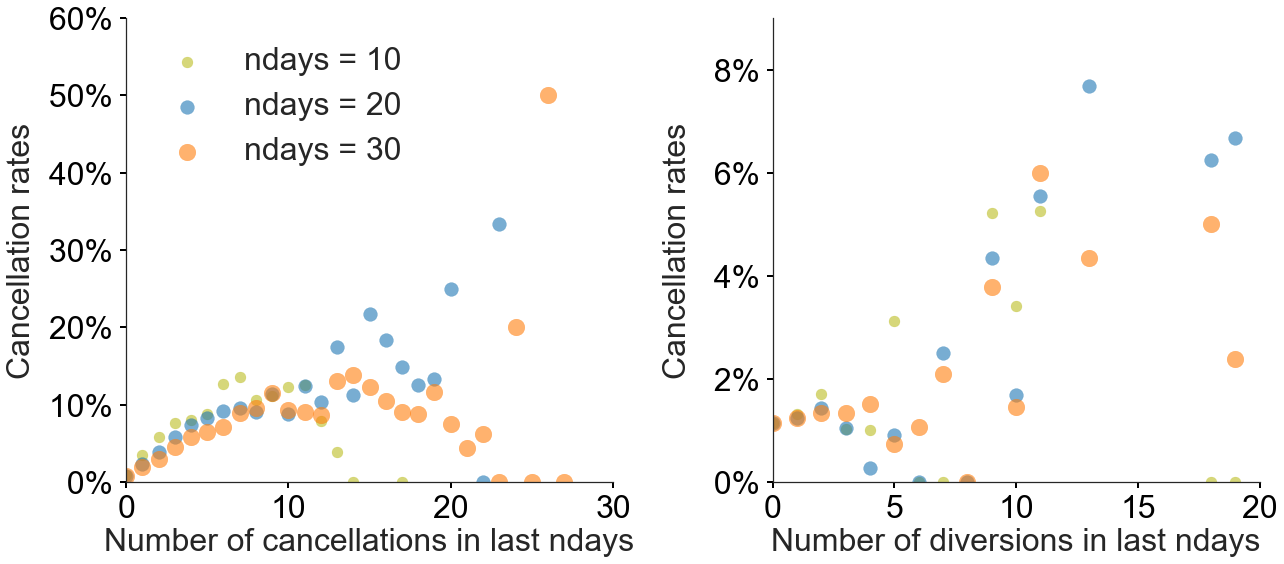

In [305]:
scatter_plot_all_ndays1(df, width=18, height=8, fsize=32)

In [306]:
def bar_plot_two_class_compare_all(df, width, height, fsize):
    """ This function creates bar charts comparing cancellation rates for three history indicator columns     
    Parameters
    ----------
    df (dtype: pd.DataFrame): The data frame
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    fsize (dtype: int): Font size
    """
    fig, (ax1,ax2, ax3) = plt.subplots(1,3,figsize=(width,height))
    ax1 = plt.subplot(1, 3, 1)
    test = pd.concat([create_canrate_by_contvar_df("TempFlight_10", df), 
           create_canrate_by_contvar_df("TempFlight_20", df),
           create_canrate_by_contvar_df("TempFlight_30", df)], 
               axis=1).iloc[:, [1,3,5]]
    
    ax1.bar(left=test.index.values, width=0.2, height=test.iloc[:,0],color=tableau20[16], zorder=0)
    ax1.bar(left=test.index.values+0.2, width=0.2, height=test.iloc[:,1], color=tableau20[0], zorder=0)
    ax1.bar(left=test.index.values+0.4, width=0.2, height=test.iloc[:,2], color=tableau20[2], zorder=0)
    
    ax1.set_ylabel("Cancellation rates", fontsize=fsize)
    ax1.tick_params(direction='out', length=6, width=2, colors='k', labelsize=fsize)
    ax1.set_title("(a) Temporary flight?", fontsize=fsize)
    #ax1.legend(["ndays = 10", "ndays = 20", "ndays = 30"], fontsize=fsize, loc=2)
    hide_topright(ax1)
    ax1.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    labels = [item.get_text() for item in ax1.get_xticklabels()]
    labels[1] = 'No'
    labels[2] = 'Yes'
    ax1.set_xticklabels(labels)
    plt.legend(["10", "20", "30"], fontsize=14, loc=2)
    
    #############################
    ax2 = plt.subplot(1, 3, 2)
    test = pd.concat([create_canrate_by_contvar_df("AllCanceled_10", df), 
           create_canrate_by_contvar_df("AllCanceled_20", df),
           create_canrate_by_contvar_df("AllCanceled_30", df)], 
               axis=1).iloc[:, [1,3,5]]
    
    ax2.bar(left=test.index.values, width=0.2, height=test.iloc[:,0],color=tableau20[16], zorder=0)
    ax2.bar(left=test.index.values+0.2, width=0.2, height=test.iloc[:,1], color=tableau20[0], zorder=0)
    ax2.bar(left=test.index.values+0.4, width=0.2, height=test.iloc[:,2], color=tableau20[2], zorder=0)
    ax2.set_ylabel("Cancellation rates", fontsize=fsize)
    ax2.tick_params(direction='out', length=6, width=2, colors='k', labelsize=fsize)
    ax2.set_title("(b) All cancelled?", fontsize=fsize)
    hide_topright(ax2)
    ax2.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    labels = [item.get_text() for item in ax2.get_xticklabels()]
    labels[1] = 'No'
    labels[2] = 'Yes'
    ax2.set_xticklabels(labels)
    
    #############################
    ax3 = plt.subplot(1, 3, 3)
    test = pd.concat([create_canrate_by_contvar_df("AllDiverted_10", df), 
           create_canrate_by_contvar_df("AllDiverted_20", df),
           create_canrate_by_contvar_df("AllDiverted_30", df)], 
               axis=1).iloc[:, [1,3,5]]
    
    ax3.bar(left=test.index.values, width=0.2, height=test.iloc[:,0],color=tableau20[16], zorder=0)
    ax3.bar(left=test.index.values+0.2, width=0.2, height=test.iloc[:,1], color=tableau20[0], zorder=0)
    ax3.bar(left=test.index.values+0.4, width=0.2, height=test.iloc[:,2], color=tableau20[2], zorder=0)
    ax3.set_ylabel("Cancellation rates", fontsize=fsize)
    ax3.tick_params(direction='out', length=6, width=2, colors='k', labelsize=fsize)
    ax3.set_title("(c) All diverted?", fontsize=fsize)
    hide_topright(ax3)
    ax3.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
    vals = ax3.get_yticks()
    ax3.set_yticklabels(['{:3.1f}%'.format(y) for y in vals])
    labels = [item.get_text() for item in ax3.get_xticklabels()]
    labels[1] = 'No'
    labels[2] = 'Yes'
    ax3.set_xticklabels(labels)
    plt.tight_layout()
    savefig("MilestoneReport/history_indicator_canrate.pdf")

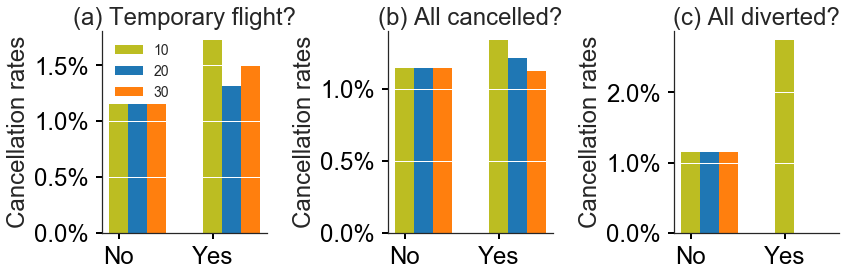

In [307]:
bar_plot_two_class_compare_all(df, width=12, height=4, fsize=24)

In [308]:
def scatter_plot_all_ndays_inset(dfd10, dfd20, dfd30, width, height, xlab, ylab, title, xlim, ylim, fsize, legend_loc,
                                 xlim_inset, ylim_inset, l, b, w, h, outputfile):
    """ This function plots the scatter plot for cancellation rates as a function of given historical feield 
    for all three values of ndays, with an inset figure.
    
    Parameters
    ----------
    dfd10 (dtype: pd.DataFrame): The small data frame for ndays = 10
    dfd20 (dtype: pd.DataFrame): The small data frame for ndays = 20
    dfd30 (dtype: pd.DataFrame): The small data frame for ndays = 30
    width (dtype: float): Width of the figure
    height (dtype: float): Height of the figure
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title of the plot
    xlim (dtype: list): The list of numbers to limit x-axis. Example: [2.5, 4]
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [0, 12.5]
    fsize (dtype: int): Font size
    legend_loc (dtype: int): Legend location
    xlim_inset (dtype: list): The list of numbers to limit x-axis in the inset figure. Example: [2.5, 4]
    ylim_inset (dtype: list): The list of numbers to limit y-axis in the inset figure. Example: [0, 12.5]
    l,b,w,h (dtypes: float):  left, bottom, width, height. Unitless percentages of the figure size. (0,0 is bottom left)
    outputfile (dtype: str): The name of the output figure file, including the directory
    """
    fig, ax1 = plt.subplots(figsize=(width,height))
    ax2 = fig.add_axes([l, b, w, h])
    
    ax1.scatter(dfd10.iloc[:,0], dfd10.iloc[:,1], color=tableau20[16], s=120, alpha=0.6, label="10")
    ax1.scatter(dfd20.iloc[:,0], dfd20.iloc[:,1], color=tableau20[0], s=190, alpha=0.6, label="20")
    ax1.scatter(dfd30.iloc[:,0], dfd30.iloc[:,1], color=tableau20[2], s=280, alpha=0.6, label="30")

    ax1.set_xlabel(xlab, size=fsize)
    ax1.set_ylabel(ylab, size=fsize)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_title(title, size=fsize)
    ax1.tick_params(direction='out', length=6, width=2, colors='k', labelsize=fsize)
    hide_topright(ax1)
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:3.0f}%'.format(y) for y in vals])
    ax1.legend(fontsize=26, loc=legend_loc)
    
    ax2.scatter(dfd10.iloc[:,0], dfd10.iloc[:,1], color=tableau20[16], s=120, alpha=0.6, label="ndays = 10")
    ax2.scatter(dfd20.iloc[:,0], dfd20.iloc[:,1], color=tableau20[0], s=190, alpha=0.6, label="ndays = 20")
    ax2.scatter(dfd30.iloc[:,0], dfd30.iloc[:,1], color=tableau20[2], s=280, alpha=0.6, label="ndays = 30")
    ax2.set_xlabel("", size=0.8*fsize)
    ax2.set_ylabel("", size=0.8*fsize)
    ax2.set_title("Zoomed-in Inset", size=0.8*fsize)
    ax2.set_xlim(xlim_inset)
    ax2.set_ylim(ylim_inset)
    ax2.tick_params(direction='out', length=6, width=2, colors='k', labelsize=0.8*fsize)
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:3.0f}%'.format(y) for y in vals])
    plt.tight_layout()
    savefig(outputfile)

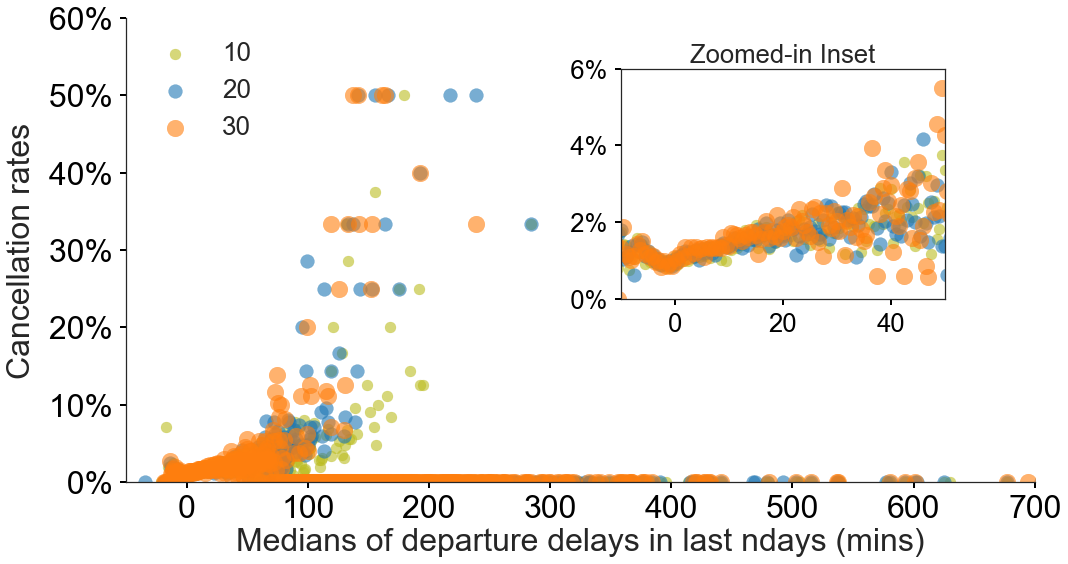

In [313]:
scatter_plot_all_ndays_inset(dfd10=create_canrate_by_contvar_df("DepDelayMedian_10", df), 
                             dfd20=create_canrate_by_contvar_df("DepDelayMedian_20", df), 
                             dfd30=create_canrate_by_contvar_df("DepDelayMedian_30", df), 
                             width=15, height=8, xlab="Medians of departure delays in last ndays (mins)", 
                             ylab="Cancellation rates", title="", 
                             xlim=[-50, 700], ylim=[0, 60], fsize=32, legend_loc=2, 
                             xlim_inset=[-10, 50], ylim_inset=[0, 6], l=0.58, b=0.47, w=0.3, h=0.4,
                            outputfile="MilestoneReport/depdelaymedian_canrate.pdf")

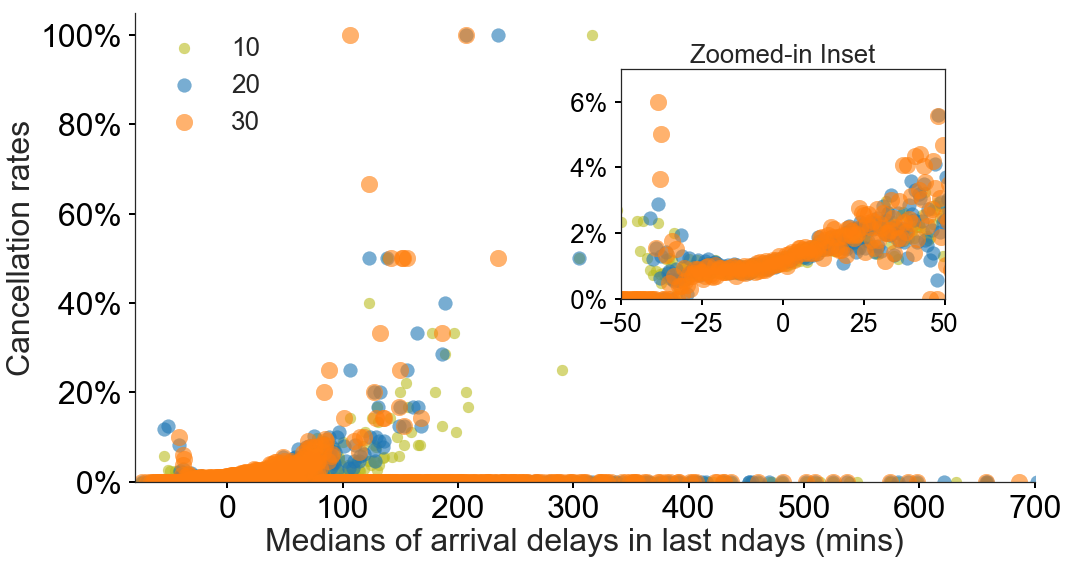

In [314]:
scatter_plot_all_ndays_inset(dfd10=create_canrate_by_contvar_df("ArrDelayMedian_10", df), 
                             dfd20=create_canrate_by_contvar_df("ArrDelayMedian_20", df), 
                             dfd30=create_canrate_by_contvar_df("ArrDelayMedian_30", df), 
                             width=15, height=8, xlab="Medians of arrival delays in last ndays (mins)", 
                             ylab="Cancellation rates", title="", 
                             xlim=[-80, 700], ylim=[0, 105], fsize=32, legend_loc=2, 
                             xlim_inset=[-50, 50], ylim_inset=[0, 7], l=0.58, b=0.47, w=0.3, h=0.4,
                            outputfile="MilestoneReport/arrdelaymedian_canrate.pdf")